<a href="https://colab.research.google.com/github/codingxperience/malaria-detection-app/blob/main/Malaria_Detection_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

fredokorio00_m_detect_path = kagglehub.dataset_download('fredokorio00/m-detect')
fredokorio00_test_dataset_path = kagglehub.dataset_download('fredokorio00/test-dataset')

print('Data source import complete.')


100%|██████████| 2.80G/2.80G [00:18<00:00, 161MB/s]

Extracting files...


100%|██████████| 1.19G/1.19G [00:07<00:00, 170MB/s]


Extracting files...
Data source import complete.


In [3]:
# !ls -R /root/.kagglehub/datasets/
import os

print("Extracted m-detect dataset path:", fredokorio00_m_detect_path)
print("Extracted test-dataset path:", fredokorio00_test_dataset_path)

# List extracted files
print("Contents of extracted dataset:")
print(os.listdir(fredokorio00_m_detect_path))



Extracted m-detect dataset path: /root/.cache/kagglehub/datasets/fredokorio00/m-detect/versions/1
Extracted test-dataset path: /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1
Contents of extracted dataset:
['labels', 'images']


In [4]:
# Import necessary libraries for training
!pip install -q -U pyyaml ultralytics albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import shutil
import os
import cv2
import random
from scipy.spatial import distance
import numpy as np
import yaml
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress display
from matplotlib.patches import Rectangle
import albumentations as A

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Trophozoite augmentation transformation
trophozoite_transform = A.Compose([
    # A.GaussNoise(p=0.3, var_limit=(10.0, 50.0), per_channel=True, mean=31.91),
#     A.CenterCrop(always_apply=False, p=0.1, height=1536, width=2048),
    A.RandomCropFromBorders(p=0.2, crop_left=0.09, crop_right=0.09, crop_top=0.0, crop_bottom=0.0),
#     A.RandomResizedCrop(height=1536, width=2048, scale=(0.01, 0.25), ratio=(0.10, 3.25), always_apply=False, p=1.0),
#     A.RandomScale(always_apply=False, p=1.0, interpolation=1, scale_limit=(-0.13, 0.14)),
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids'], min_visibility=0.35))

# Negative augmentation transformation
negative_transform = A.Compose([
#     A.RandomScale(always_apply=False, p=1.0, interpolation=1, scale_limit=(-0.13, 0.14)),
    A.Blur(blur_limit=3, p=0.1),
    # A.GaussNoise(p=0.3, var_limit=(10.0, 50.0), per_channel=True, mean=31.91),
    A.RandomCropFromBorders(p=1.0, crop_left=0.16, crop_right=0.12, crop_top=0.0, crop_bottom=0.0),
    A.Rotate(limit=15, p=0.4),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=1, p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids'], min_visibility=0.35))


wbc_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    # A.GaussNoise(p=0.3, var_limit=(10.0, 50.0), per_channel=True, mean=31.91),
    A.RandomScale(p=1.0, interpolation=1, scale_limit=(-0.13, 0.14)),
    A.GridDistortion(p=0.4),
    A.RandomCropFromBorders(p=1.0, crop_left=0.16, crop_right=0.12, crop_top=0.0, crop_bottom=0.0),
#     A.CenterCrop(always_apply=False, p=1.0, height=915, width=1024),
    A.Rotate(limit=15, p=0.4),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=1, p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids'], min_visibility=0.35))

In [7]:
# Helper functions
def voc_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height):
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return x_center, y_center, width, height


In [8]:
def detect_hard_negative(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)
    edge_density = np.sum(edges) / edges.size
    return edge_density > 0.02

In [9]:
# Tracking the display limit for each augmentation type

display_counts = {"troph": 0, "wbc": 0, "neg": 0}

MAX_DISPLAY_PER_CATEGORY = 5  # Set max display for each category



def save_augmented_image(augmented, img_name, lbl_name, output_img_dir, output_lbl_dir, split, aug_index, display, aug_type):

    aug_img = augmented['image']

    aug_bboxes = augmented.get('bboxes', [])

    aug_category_ids = augmented.get('category_ids', [])



    # Construct the output file paths with the augmentation index and type

    base_name = f"{img_name}_aug_{aug_type}_{aug_index+1}"

    output_img_path = f"{output_img_dir}/{split}/{base_name}.jpg"

    output_lbl_path = f"{output_lbl_dir}/{split}/{base_name}.txt"



    # Save the augmented image and bounding boxes

    cv2.imwrite(output_img_path, aug_img)

    with open(output_lbl_path, 'w') as f:

        for bbox, category_id in zip(aug_bboxes, aug_category_ids):

            x_center, y_center, width, height = bbox

            f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")



    # Display the augmented image with bounding boxes if within max display limit

    if display and display_counts[aug_type] < MAX_DISPLAY_PER_CATEGORY:

        plot_image_with_bboxes(aug_img, aug_bboxes, aug_category_ids, image_id=img_name, title=f"Augmented Image {aug_index+1} ({aug_type.capitalize()})")

        display_counts[aug_type] += 1  # Increment count for this category


In [10]:
# Adjusted clip_and_filter_bboxes function with visibility log
def clip_and_filter_bboxes(bboxes):
    valid_bboxes = []
    for bbox in bboxes:
        x, y, w, h = bbox
        x = max(0.0, min(x, 1.0))
        y = max(0.0, min(y, 1.0))
        w = max(0.0, min(w, 1.0 - x))
        h = max(0.0, min(h, 1.0 - y))
        if 0.0 <= x <= 1.0 and 0.0 <= y <= 1.0 and 0.0 < w <= 1.0 and 0.0 < h <= 1.0:
            valid_bboxes.append([x, y, w, h])
    if not valid_bboxes:
        print("Warning: All bounding boxes were filtered out for an image.")
    return valid_bboxes

In [11]:
# Display count control for each augmentation type
display_counts = {"troph": 0, "wbc": 0, "neg": 0}
MAX_DISPLAY_PER_CATEGORY = 5  # Set max display for each category

def plot_image_with_bboxes(image, bboxes, category_ids, image_id, title=""):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax = plt.gca()
    colors = {1: 'red', 0: 'blue'}
    plt.text(10, 20, f"Image ID: {image_id}", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    for bbox, category_id in zip(bboxes, category_ids):
        x_center, y_center, width, height = bbox
        x_min = (x_center - width / 2) * image.shape[1]
        y_min = (y_center - height / 2) * image.shape[0]
        width *= image.shape[1]
        height *= image.shape[0]
        rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=colors[category_id], facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min - 5, f"Class: {category_id}", color=colors[category_id], fontsize=5, bbox=dict(facecolor='black', alpha=0.1))
    plt.axis('off')
    plt.show()

In [12]:
def augment_with_pasted_trophozoites_grid(image, bboxes, category_ids, target_count=10, img_name="", display=False, grid_size=50, min_distance=30):
    img_height, img_width = image.shape[:2]
    current_troph_count = category_ids.count(1)
    troph_bboxes = [bbox for bbox, cat_id in zip(bboxes, category_ids) if cat_id == 1]
    additional_bboxes, additional_category_ids = [], []

    grid_rows, grid_cols = img_height // grid_size, img_width // grid_size

    def is_non_black_area(x_min, y_min, w_px, h_px):
        if y_min + h_px > img_height or x_min + w_px > img_width:
            return False
        non_black_pixels = np.count_nonzero(image[y_min:y_min + h_px, x_min:x_min + w_px] > 30)
        return non_black_pixels / (w_px * h_px) > 0.70

    def is_far_enough(new_bbox, existing_bboxes):
        """Ensure that pasted objects don't overlap too closely."""
        new_x, new_y, new_w, new_h = new_bbox
        new_center = (new_x + new_w / 2, new_y + new_h / 2)
        for bbox in existing_bboxes:
            x, y, w, h = bbox
            center = (x + w / 2, y + h / 2)
            if distance.euclidean(new_center, center) < min_distance:
                return False
        return True

    while current_troph_count < target_count and troph_bboxes:
        for bbox in troph_bboxes:
            x_center, y_center, width, height = bbox
            w_px, h_px = int(width * img_width), int(height * img_height)

            for _ in range(15):  # Try 15 placements to find a valid one
                row, col = np.random.randint(0, grid_rows), np.random.randint(0, grid_cols)
                x_min, y_min = col * grid_size, row * grid_size

                if is_non_black_area(x_min, y_min, w_px, h_px) and is_far_enough([x_min, y_min, w_px, h_px], additional_bboxes):
                    obj_region = image[int((y_center - height / 2) * img_height):int((y_center + height / 2) * img_height),
                                       int((x_center - width / 2) * img_width):int((x_center + width / 2) * img_width)]

                    # Resize the region to fit the calculated width and height in pixels
                    obj_region = cv2.resize(obj_region, (w_px, h_px))

                    # Paste the resized region into the target location
                    image[y_min:y_min + h_px, x_min:x_min + w_px] = obj_region

                    # Calculate new YOLO bounding box coordinates
                    new_x_center = (x_min + w_px / 2) / img_width
                    new_y_center = (y_min + h_px / 2) / img_height
                    new_width, new_height = w_px / img_width, h_px / img_height

                    # Append the new bounding box and update count
                    additional_bboxes.append([new_x_center, new_y_center, new_width, new_height])
                    additional_category_ids.append(1)
                    current_troph_count += 1
                    break

    # Update the original bboxes and categories
    bboxes.extend(additional_bboxes)
    category_ids.extend(additional_category_ids)

    return image, bboxes, category_ids

In [13]:
# Define transformations and other necessary functions here (you already have these defined, so I’ll skip re-pasting them)

def prepare_yolo_dataset(input_img_dir, input_lbl_dir, output_img_dir, output_lbl_dir, aug_threshold=3, display=False, max_display=10, grid_size=50):
    images = sorted([img for img in os.listdir(input_img_dir) if img.endswith('.jpg')])
    labels = sorted([lbl for lbl in os.listdir(input_lbl_dir) if lbl.endswith('.txt')])

    # Ensure output directories exist
    os.makedirs(os.path.join(output_img_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_img_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_lbl_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_lbl_dir, 'val'), exist_ok=True)

    images_train, images_val, labels_train, labels_val = train_test_split(
        images, labels, test_size=0.2, stratify=[lbl.split('_')[0] for lbl in labels]
    )

    def process_images(images_list, labels_list, split, augment=False):
        with tqdm(total=len(images_list), desc=f"Processing {split} set") as pbar:
            for img_name, lbl_name in zip(images_list, labels_list):
                img_path = os.path.join(input_img_dir, img_name)
                lbl_path = os.path.join(input_lbl_dir, lbl_name)

                # Try reading the image and label, log a warning if unable to read
                try:
                    image = cv2.imread(img_path)
                    img_height, img_width = image.shape[:2]

                    with open(lbl_path, 'r') as f:
                        lines = f.readlines()
                    voc_bboxes = [list(map(float, line.split()[1:])) for line in lines]
                    category_ids = [int(line.split()[0]) for line in lines]
                    yolo_bboxes = [voc_to_yolo(*bbox, img_width, img_height) for bbox in voc_bboxes]

                except Exception as e:
                    print(f"Warning: Could not process {img_name} or {lbl_name} due to {e}")
                    continue

                # Counts of each object type
                trophozoite_count = category_ids.count(1)
                wbc_count = category_ids.count(0)

#                 if augment:
#                     if wbc_count > trophozoite_count:
#                         for i in range(2):
#                             try:
#                                 augmented = wbc_transform(image=image, bboxes=yolo_bboxes, category_ids=category_ids)
#                                 save_augmented_image(augmented, img_name, lbl_name, output_img_dir, output_lbl_dir, split, i, display, aug_type="wbc")
#                             except ValueError as e:
#                                 print(f"Skipping WBC augmentation for {img_name} due to error: {e}")

#                     elif (img_width, img_height) in [(4160, 3120), (4032, 3016), (4000, 3000)] and 3 <= trophozoite_count <= 5:
#                         for i in range(1):
#                             try:
#                                 augmented = trophozoite_transform(image=image, bboxes=yolo_bboxes, category_ids=category_ids)
#                                 save_augmented_image(augmented, img_name, lbl_name, output_img_dir, output_lbl_dir, split, i, display, aug_type="troph")
#                             except ValueError as e:
#                                 print(f"Skipping Trophozoite augmentation for {img_name} due to error: {e}")

#                     elif len(category_ids) == 0 and detect_hard_negative(image):
#                         for i in range(3):
#                             try:
#                                 augmented = negative_transform(image=image, bboxes=[], category_ids=[])
#                                 save_augmented_image(augmented, img_name, lbl_name, output_img_dir, output_lbl_dir, split, i, display, aug_type="neg")
#                             except ValueError as e:
#                                 print(f"Skipping hard negative augmentation for {img_name} due to error: {e}")

                if augment and 1 <= trophozoite_count <= 5:
                    image, yolo_bboxes, category_ids = augment_with_pasted_trophozoites_grid(
                        image, yolo_bboxes, category_ids, target_count=15, img_name=img_name, display=display, grid_size=grid_size
                    )

                output_img_path = os.path.join(output_img_dir, split, img_name)
                output_lbl_path = os.path.join(output_lbl_dir, split, lbl_name)

                cv2.imwrite(output_img_path, image)
                with open(output_lbl_path, 'w') as f_out:
                    for bbox, class_id in zip(yolo_bboxes, category_ids):
                        x_center, y_center, width, height = bbox
                        f_out.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")

                if display and display_counts["troph"] < MAX_DISPLAY_PER_CATEGORY and split == 'train':
                    plot_image_with_bboxes(image, yolo_bboxes, category_ids, img_name, title=f"Train Image: {img_name}")
                    display_counts["troph"] += 1

                pbar.update(1)

    # Process training and validation sets
    process_images(images_train, labels_train, split='train', augment=True)
    process_images(images_val, labels_val, split='val', augment=False)


Processing train set:   0%|          | 0/2197 [00:00<?, ?it/s]

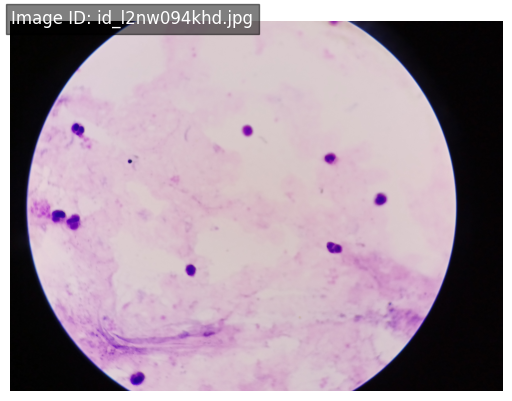

Processing train set:   0%|          | 1/2197 [00:01<45:19,  1.24s/it]

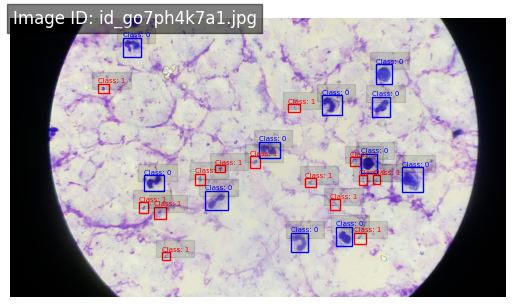

Processing train set:   0%|          | 2/2197 [00:01<33:10,  1.10it/s]

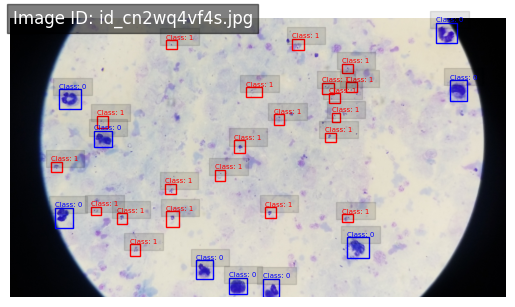

Processing train set:   0%|          | 3/2197 [00:02<31:18,  1.17it/s]

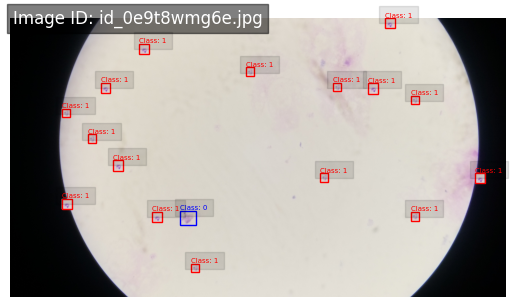

Processing train set:   0%|          | 4/2197 [00:03<31:46,  1.15it/s]

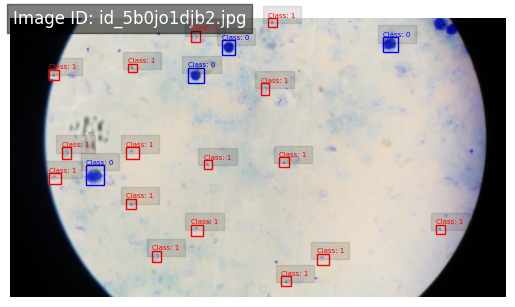

Processing val set: 100%|██████████| 550/550 [00:59<00:00,  9.22it/s]


In [14]:
# Usage
prepare_yolo_dataset(
    input_img_dir='/root/.cache/kagglehub/datasets/fredokorio00/m-detect/versions/1/images/train',
    input_lbl_dir='/root/.cache/kagglehub/datasets/fredokorio00/m-detect/versions/1/labels/train',
    output_img_dir='/kaggle/working/images',
    output_lbl_dir='/kaggle/working/labels',
    display=True  # Set True to view displays
)

In [15]:
# Directories for labels
train_label_dir = '/kaggle/working/labels/train'
val_label_dir = '/kaggle/working/labels/val'

def get_class_distribution(label_dir):
    class_counts = {'trophozoite': 0, 'WBC': 0, 'negative': 0}
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)

        # Check if label file is empty (negative image)
        if os.path.getsize(label_path) == 0:
            class_counts['negative'] += 1
        else:
            with open(label_path, 'r') as f:
                for line in f:
                    # Convert to float first, then to int
                    class_id = int(float(line.split()[0]))
                    if class_id == 1:
                        class_counts['trophozoite'] += 1
                    elif class_id == 0:
                        class_counts['WBC'] += 1

    return class_counts

# Get class distributions for train and val sets
train_distribution = get_class_distribution(train_label_dir)
val_distribution = get_class_distribution(val_label_dir)

print("Class Distribution in Training Set:", train_distribution)
print("Class Distribution in Validation Set:", val_distribution)

Class Distribution in Training Set: {'trophozoite': 23652, 'WBC': 5712, 'negative': 555}
Class Distribution in Validation Set: {'trophozoite': 3300, 'WBC': 1287, 'negative': 133}


In [16]:
# Define paths (update for Kaggle)
base_path = '/kaggle/working/'
dest_path = '/kaggle/working'

In [17]:
# Step 3: Generate YAML File
def create_data_yaml(base_path, class_names):
    data_yaml = {
        'train': os.path.join(base_path, 'images/train'),
        'val': os.path.join(base_path, 'images/val'),
        'nc': len(class_names),
        'names': class_names
    }
    yaml_path = '/kaggle/working/data.yaml'
    with open(yaml_path, 'w') as yaml_file:
        yaml.dump(data_yaml, yaml_file)
    print(f"'data.yaml' created at {yaml_path}")

In [18]:
# Create data.yaml
create_data_yaml(dest_path, class_names=['WBC', 'Trophozoite'])

'data.yaml' created at /kaggle/working/data.yaml


In [19]:
# # Define the YAML content as a string
# yaml_content = """
# # Ultralytics YOLO 🚀, AGPL-3.0 license
# # YOLOv8 object detection model with P2-P4 outputs

# # Parameters
# nc: 2  # Set number of classes: 0 = WBC, 1 = Trophozoite
# depth_multiple: 0.33 # scales module repeats
# width_multiple: 0.50 # scales convolution channels

# # YOLOv8.0 backbone
# backbone:
#   # [from, repeats, module, args]
#   - [-1, 1, Conv, [64, 3, 2]] # 0-P1/2
#   - [-1, 1, Conv, [128, 3, 2]] # 1-P2/4
#   - [-1, 3, C2f, [128, True]]
#   - [-1, 1, Conv, [256, 3, 2]] # 3-P3/8
#   - [-1, 6, C2f, [256, True]]
#   - [-1, 1, Conv, [512, 3, 2]] # 5-P4/16
#   - [-1, 6, C2f, [512, True]]
#   - [-1, 1, Conv, [1024, 3, 2]] # 7-P5/32
#   - [-1, 3, C2f, [1024, True]]
#   - [-1, 1, SPPF, [1024, 5]] # 9

# # YOLOv8.0-p2 head
# head:
#   - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
#   - [[-1, 6], 1, Concat, [1]] # cat backbone P4
#   - [-1, 3, C2f, [512]] # 12

#   - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
#   - [[-1, 4], 1, Concat, [1]] # cat backbone P3
#   - [-1, 3, C2f, [256]] # 15 (P3/8-small)

#   - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
#   - [[-1, 2], 1, Concat, [1]] # cat backbone P2
#   - [-1, 3, C2f, [128]] # 18 (P2/4-xsmall)

#   - [-1, 1, Conv, [128, 3, 2]]
#   - [[-1, 15], 1, Concat, [1]] # cat head P3
#   - [-1, 3, C2f, [256]] # 21 (P3/8-small)

#   - [-1, 1, Conv, [256, 3, 2]]
#   - [[-1, 12], 1, Concat, [1]] # cat head P4
#   - [-1, 3, C2f, [512]] # 24 (P4/16-medium)

#   - [-1, 1, Conv, [512, 3, 2]]
#   - [[-1, 9], 1, Concat, [1]] # cat head P5
#   - [-1, 3, C2f, [1024]] # 27 (P5/32-large)

#   - [[18, 21, 24, 27], 1, Detect, [nc]] # Detect(P2, P3, P4, P5)
# """

# # Write the content to a file in the Kaggle working directory
# file_path = '/kaggle/working/yolov8-p2-custom.yaml'

# with open(file_path, 'w') as f:
#     f.write(yaml_content)

# print(f"Custom YOLOv8 P2-P4 YAML file saved at {file_path}")

In [20]:
# # Load the model with the custom configuration
# model = YOLO(file_path).load('yolov8s.pt')


# Load the YOLOv8 model
model = YOLO("yolov8s.pt")


# # Load the YOLOv8 model
# model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 235MB/s]


In [21]:
# os.environ["WANDB_MODE"] = "disabled"

In [22]:
# import gc

# gc.collect()

In [23]:
# from IPython.display import clear_output

# clear_output()

In [24]:
# Train the model using the modified P2-P4 configuration
model.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    patience=300,
    imgsz=1024,
    batch=8
)

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=300, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 2197 images, 555 backgrounds, 0 corrupt: 100%|██████████| 2197/2197 [00:03<00:00, 643.17it/s]

train: WARNING ⚠️ /kaggle/working/images/train/id_1c93ihgovo.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_557cyy9hsg.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_5lp8nvwny7.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_6qvsxn1wp2.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_99wdvjeavb.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_aa5go0vd7g.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_bqs4luq4kl.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_e5cvk28krq.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_g2f1mg6pet.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_i5tsin8ztt.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/images/train/id_q7m74i9e8z.jpg: 2 du


val: Scanning /kaggle/working/labels/val... 550 images, 133 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:00<00:00, 1040.00it/s]


val: New cache created: /kaggle/working/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.24G      1.536      1.361      1.035        129       1024: 100%|██████████| 275/275 [03:19<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:36<00:00,  1.05s/it]

                   all        550       4587       0.62      0.721       0.67      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.04G       1.42     0.9875      1.005        127       1024: 100%|██████████| 275/275 [03:17<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]


                   all        550       4587      0.592      0.636      0.617      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.55G      1.375      0.954     0.9977        131       1024: 100%|██████████| 275/275 [03:11<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.02s/it]

                   all        550       4587      0.673      0.759      0.726      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       5.3G      1.349     0.9015     0.9867        116       1024: 100%|██████████| 275/275 [03:19<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


                   all        550       4587      0.651      0.745      0.717      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.66G      1.344     0.8684     0.9846         72       1024: 100%|██████████| 275/275 [03:09<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.03s/it]


                   all        550       4587      0.703      0.733      0.741      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.58G      1.317     0.8547     0.9799         99       1024: 100%|██████████| 275/275 [03:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:42<00:00,  1.21s/it]


                   all        550       4587      0.666      0.776      0.752      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.92G      1.314     0.8429     0.9828        124       1024: 100%|██████████| 275/275 [03:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:42<00:00,  1.21s/it]


                   all        550       4587      0.711      0.738      0.745      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.02G      1.301     0.8178     0.9774         71       1024: 100%|██████████| 275/275 [02:58<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:38<00:00,  1.10s/it]


                   all        550       4587      0.711       0.78      0.762      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.64G      1.275     0.8002      0.969        116       1024: 100%|██████████| 275/275 [03:54<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [01:00<00:00,  1.72s/it]

                   all        550       4587      0.736      0.753      0.767      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.87G      1.276     0.7933     0.9731        139       1024: 100%|██████████| 275/275 [03:24<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [01:15<00:00,  2.16s/it]


                   all        550       4587      0.751      0.806      0.789      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.49G      1.259     0.7769     0.9718        105       1024: 100%|██████████| 275/275 [02:56<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:45<00:00,  1.30s/it]

                   all        550       4587      0.744      0.747      0.776      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.11G      1.269     0.7665     0.9703         84       1024: 100%|██████████| 275/275 [03:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [01:25<00:00,  2.43s/it]


                   all        550       4587      0.646      0.718      0.695      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.09G      1.273     0.7645     0.9671        126       1024: 100%|██████████| 275/275 [03:42<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [01:53<00:00,  3.24s/it]

                   all        550       4587      0.721      0.792      0.776      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.67G      1.249     0.7425      0.966         76       1024: 100%|██████████| 275/275 [04:33<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [01:58<00:00,  3.37s/it]


                   all        550       4587      0.746      0.805      0.801      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.92G      1.253     0.7491     0.9674        102       1024: 100%|██████████| 275/275 [04:09<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:48<00:00,  1.37s/it]


                   all        550       4587      0.685      0.784      0.782      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.46G      1.235     0.7356     0.9667        107       1024: 100%|██████████| 275/275 [02:51<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:51<00:00,  1.47s/it]


                   all        550       4587      0.735      0.803      0.799        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.45G      1.214     0.7158     0.9561         73       1024: 100%|██████████| 275/275 [02:54<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.01s/it]


                   all        550       4587      0.739      0.785      0.787      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.53G      1.223     0.7231      0.964        175       1024: 100%|██████████| 275/275 [02:59<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.02s/it]

                   all        550       4587      0.737      0.795      0.787      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.36G      1.204     0.7072      0.961        116       1024: 100%|██████████| 275/275 [02:56<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.02s/it]


                   all        550       4587      0.767      0.803      0.812      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.19G      1.217     0.7171     0.9607        141       1024: 100%|██████████| 275/275 [02:52<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.01s/it]


                   all        550       4587       0.74      0.778      0.788       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.62G      1.221     0.7216     0.9583        147       1024: 100%|██████████| 275/275 [03:10<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.03s/it]


                   all        550       4587      0.757      0.784      0.802      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.51G      1.233     0.7155     0.9637        119       1024: 100%|██████████| 275/275 [03:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]


                   all        550       4587      0.745      0.804      0.805      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.04G      1.231     0.7069     0.9637         62       1024: 100%|██████████| 275/275 [03:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.01s/it]

                   all        550       4587       0.72      0.794      0.766      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.48G      1.202     0.6961     0.9567         88       1024: 100%|██████████| 275/275 [02:59<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.01s/it]


                   all        550       4587      0.749      0.817      0.808      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.99G      1.204     0.6924     0.9589         87       1024: 100%|██████████| 275/275 [02:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:36<00:00,  1.05s/it]

                   all        550       4587      0.747       0.81      0.817      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.39G        1.2     0.6864     0.9542         97       1024: 100%|██████████| 275/275 [02:48<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:39<00:00,  1.13s/it]

                   all        550       4587      0.755      0.808      0.799      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.34G      1.207     0.6876     0.9559        112       1024: 100%|██████████| 275/275 [02:50<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:37<00:00,  1.08s/it]

                   all        550       4587      0.762      0.806      0.811      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.08G      1.176     0.6702     0.9476        130       1024: 100%|██████████| 275/275 [02:49<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:42<00:00,  1.21s/it]


                   all        550       4587      0.732      0.811      0.797      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.58G       1.18     0.6691     0.9527        132       1024: 100%|██████████| 275/275 [02:50<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:43<00:00,  1.23s/it]


                   all        550       4587      0.767      0.809      0.813      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.82G      1.182     0.6686     0.9533         61       1024: 100%|██████████| 275/275 [02:49<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:38<00:00,  1.10s/it]


                   all        550       4587      0.752      0.833      0.829      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.08G       1.19     0.6629     0.9539        105       1024: 100%|██████████| 275/275 [02:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:41<00:00,  1.19s/it]


                   all        550       4587       0.76      0.825      0.825      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.52G      1.184     0.6655     0.9472         84       1024: 100%|██████████| 275/275 [02:55<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:42<00:00,  1.20s/it]

                   all        550       4587      0.755      0.819      0.818      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.89G      1.176     0.6466      0.948        103       1024: 100%|██████████| 275/275 [02:52<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:41<00:00,  1.18s/it]


                   all        550       4587      0.769      0.811      0.822      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.62G      1.189     0.6581     0.9513         49       1024: 100%|██████████| 275/275 [02:50<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:39<00:00,  1.13s/it]

                   all        550       4587      0.768      0.812      0.828      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.31G      1.161     0.6415     0.9474         82       1024: 100%|██████████| 275/275 [02:52<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:39<00:00,  1.14s/it]


                   all        550       4587      0.768      0.815      0.822      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.66G      1.156     0.6352     0.9447         95       1024: 100%|██████████| 275/275 [02:52<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:39<00:00,  1.13s/it]

                   all        550       4587       0.77      0.824      0.831      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.6G      1.156     0.6346     0.9459        109       1024: 100%|██████████| 275/275 [02:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:39<00:00,  1.14s/it]

                   all        550       4587      0.766      0.826       0.83      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.21G      1.168     0.6446     0.9452        187       1024: 100%|██████████| 275/275 [02:52<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:39<00:00,  1.12s/it]

                   all        550       4587      0.756      0.813       0.81      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         6G       1.16     0.6358     0.9454        132       1024: 100%|██████████| 275/275 [02:51<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:40<00:00,  1.15s/it]

                   all        550       4587       0.77      0.826       0.83      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.29G       1.15     0.6243      0.942        141       1024: 100%|██████████| 275/275 [03:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:41<00:00,  1.18s/it]


                   all        550       4587      0.769      0.841      0.835      0.427
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.73G      1.152     0.6295     0.9698         65       1024: 100%|██████████| 275/275 [03:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:36<00:00,  1.03s/it]

                   all        550       4587       0.78      0.827      0.836      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       4.8G      1.145     0.6186     0.9686         83       1024: 100%|██████████| 275/275 [02:58<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]


                   all        550       4587      0.775      0.827      0.833      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.76G      1.133     0.6151     0.9659         86       1024: 100%|██████████| 275/275 [02:56<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]

                   all        550       4587      0.772      0.822      0.833      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.78G      1.135     0.6041     0.9593         53       1024: 100%|██████████| 275/275 [02:58<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]

                   all        550       4587      0.783      0.832      0.841      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.87G       1.13     0.6032     0.9634         45       1024: 100%|██████████| 275/275 [02:55<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.02s/it]


                   all        550       4587      0.771      0.835      0.837      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.75G      1.117     0.5939     0.9612         55       1024: 100%|██████████| 275/275 [02:56<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


                   all        550       4587      0.782      0.826      0.835      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       4.9G      1.133      0.598     0.9647         75       1024: 100%|██████████| 275/275 [03:04<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:36<00:00,  1.04s/it]

                   all        550       4587      0.779      0.835       0.84      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.75G      1.124     0.5914     0.9676         66       1024: 100%|██████████| 275/275 [03:09<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:35<00:00,  1.01s/it]


                   all        550       4587      0.781      0.837      0.841      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.76G       1.11      0.581     0.9595        142       1024: 100%|██████████| 275/275 [03:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]

                   all        550       4587      0.779      0.829      0.838      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.88G      1.109     0.5783     0.9578         56       1024: 100%|██████████| 275/275 [03:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:34<00:00,  1.00it/s]

                   all        550       4587      0.778       0.84      0.841      0.435



50 epochs completed in 3.213 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


                   all        550       4587      0.783      0.832      0.841      0.439
                   WBC        316       1287      0.917      0.951      0.979      0.601
           Trophozoite        409       3300      0.648      0.713      0.704      0.277
Speed: 0.4ms preprocess, 8.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3bd5943b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [25]:
# # Train the model using the modified P2-P4 configuration
# model.train(
#     data='/kaggle/working/data.yaml',
#     epochs=30,
#     patience=300,
#     imgsz=2048,
#     batch=0.70,
#     optimizer="AdamW",
#     cos_lr=True,
#     momentum= 0.9,
#     weight_decay= 0.00066,
#     warmup_epochs= 2.45078,
#     warmup_momentum= 0.63286,
#     box= 4.77134,
#     cls= 0.60022,
#     dfl= 1.14252,
#     hsv_h= 0.01391,
#     hsv_s= 0.78829,
#     hsv_v= 0.45897,
#     degrees= 0.0,
#     translate= 0.10931,
#     scale= 0.40096,
#     shear= 0.0,
#     perspective= 0.0,
#     flipud= 0.0,
#     fliplr= 0.44802,
#     bgr= 0.0,
#     mosaic= 1.0,
#     mixup= 0.0,
#     amp=False,
#     copy_paste= 0.0,
# )

In [26]:
import os
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image

In [29]:
# Extracting and displaying training results images
training_results_dir = '/content/runs/detect/train'

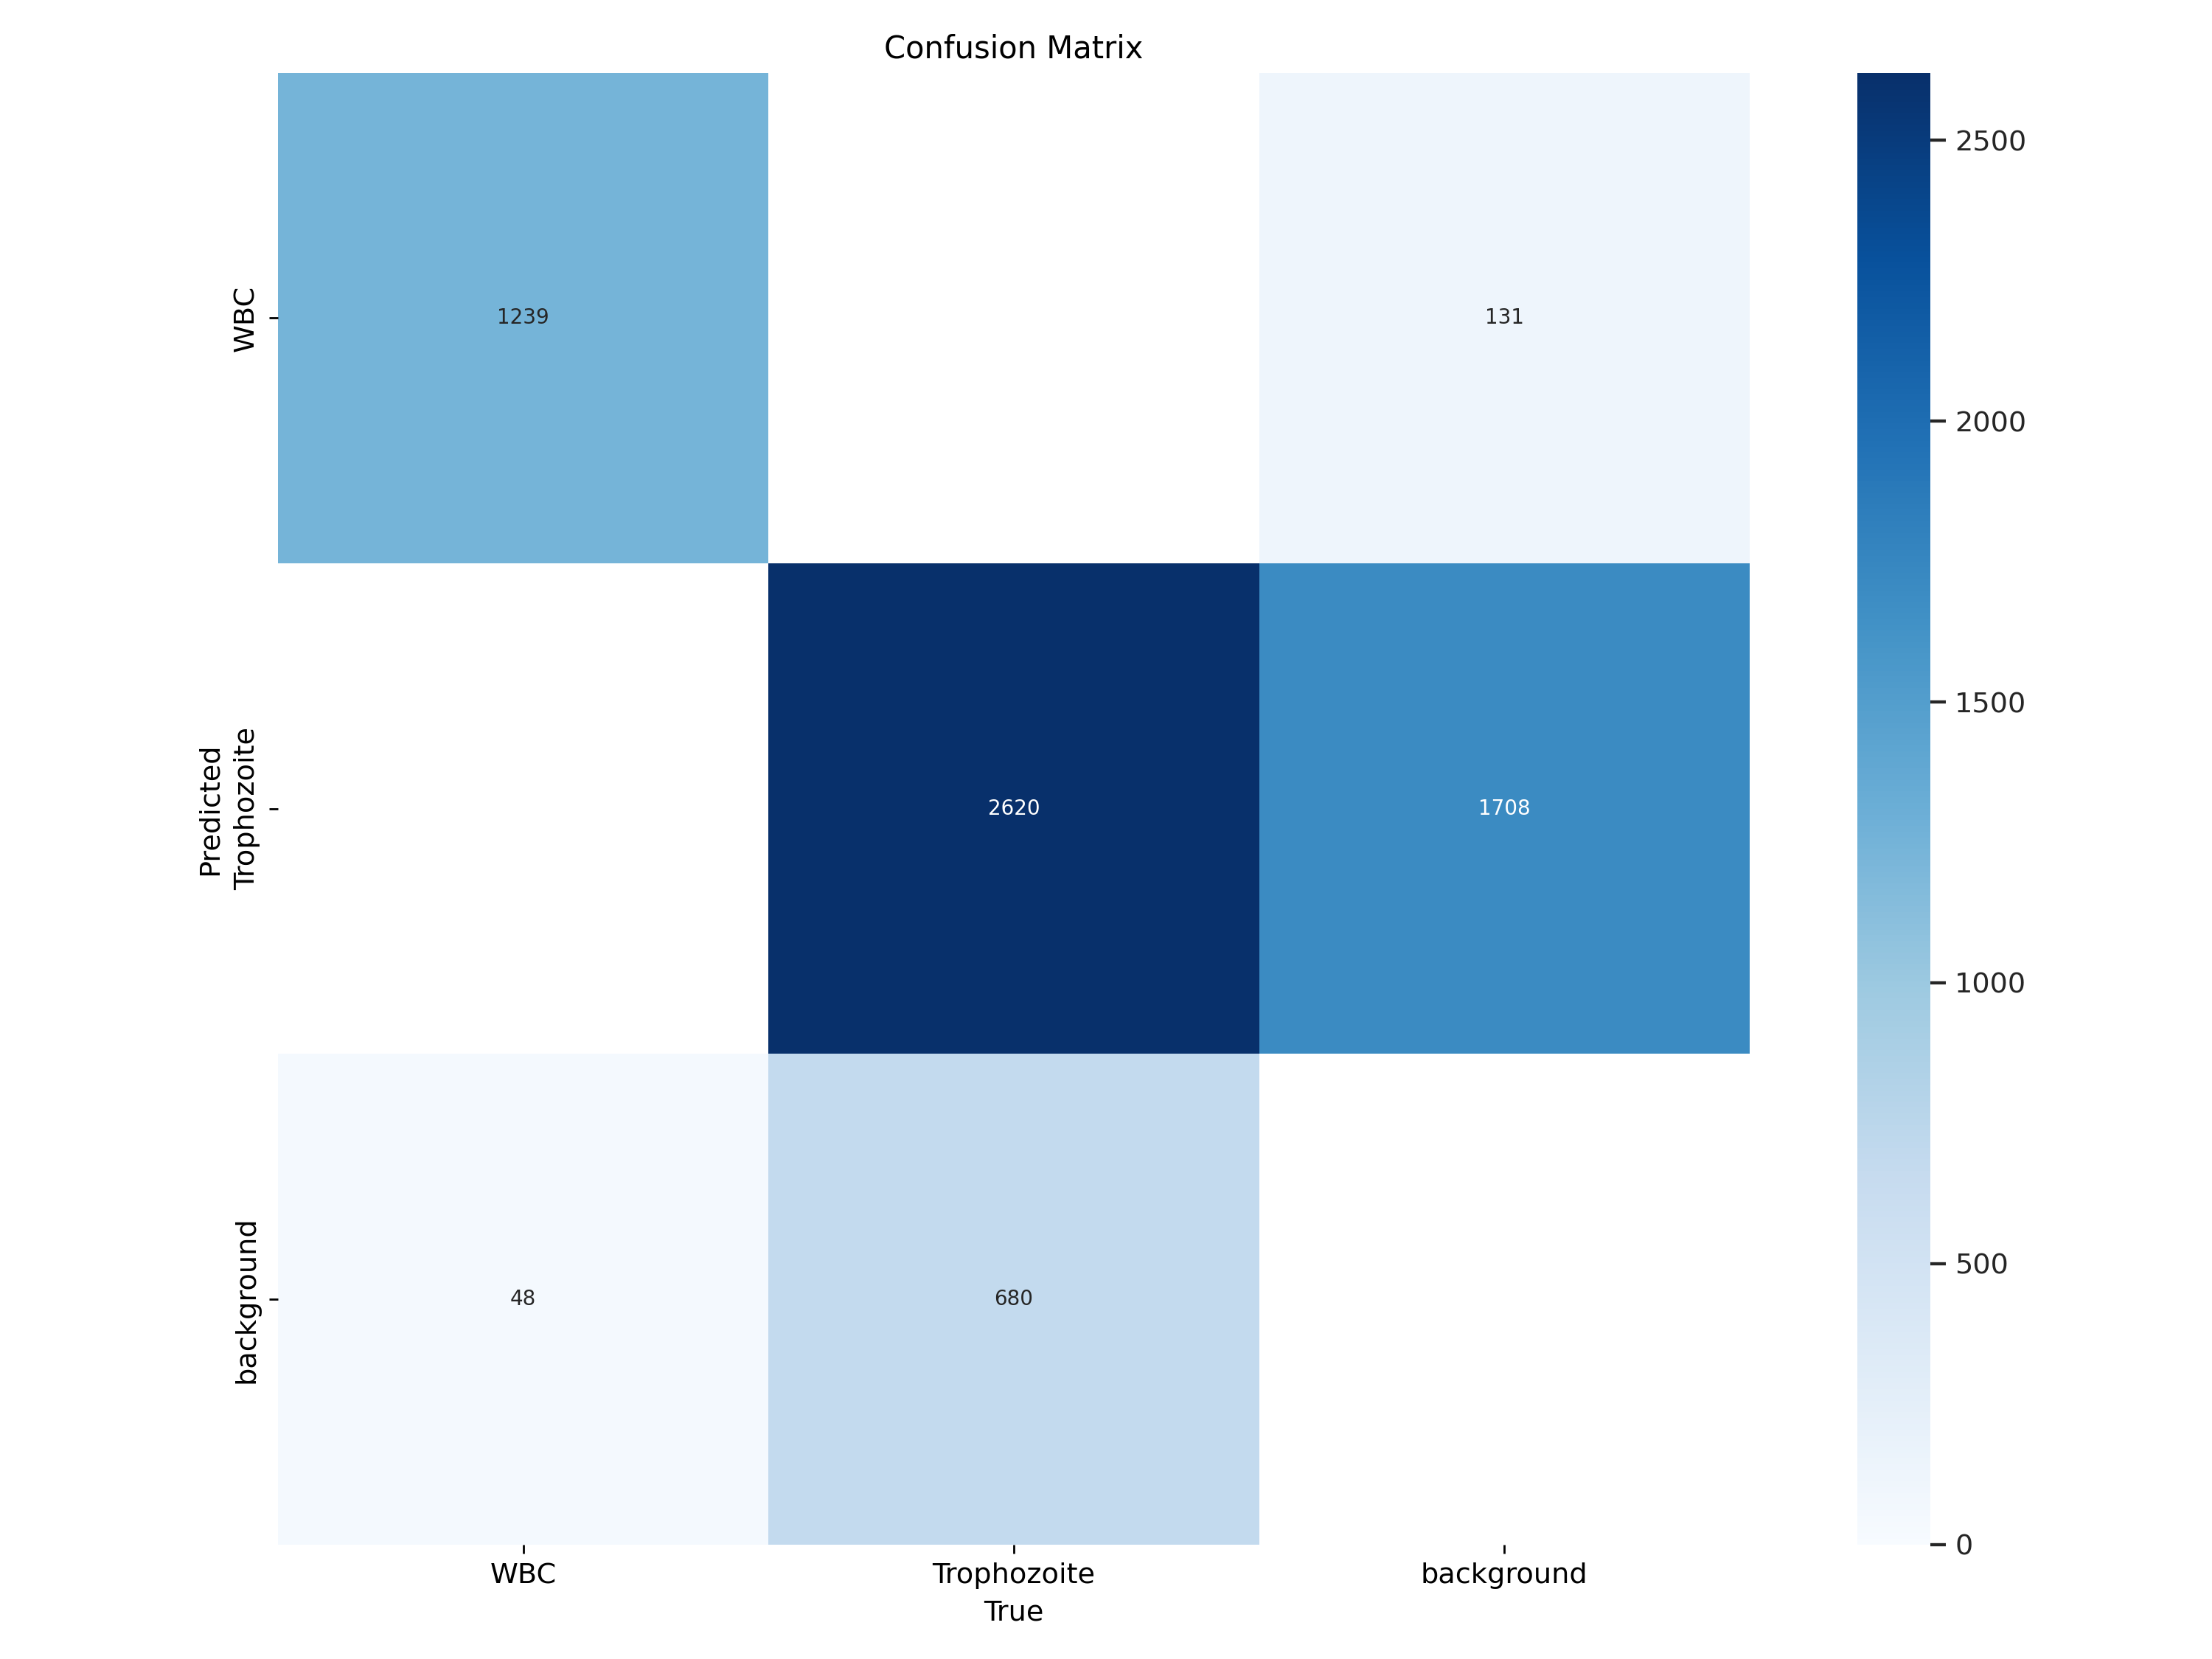

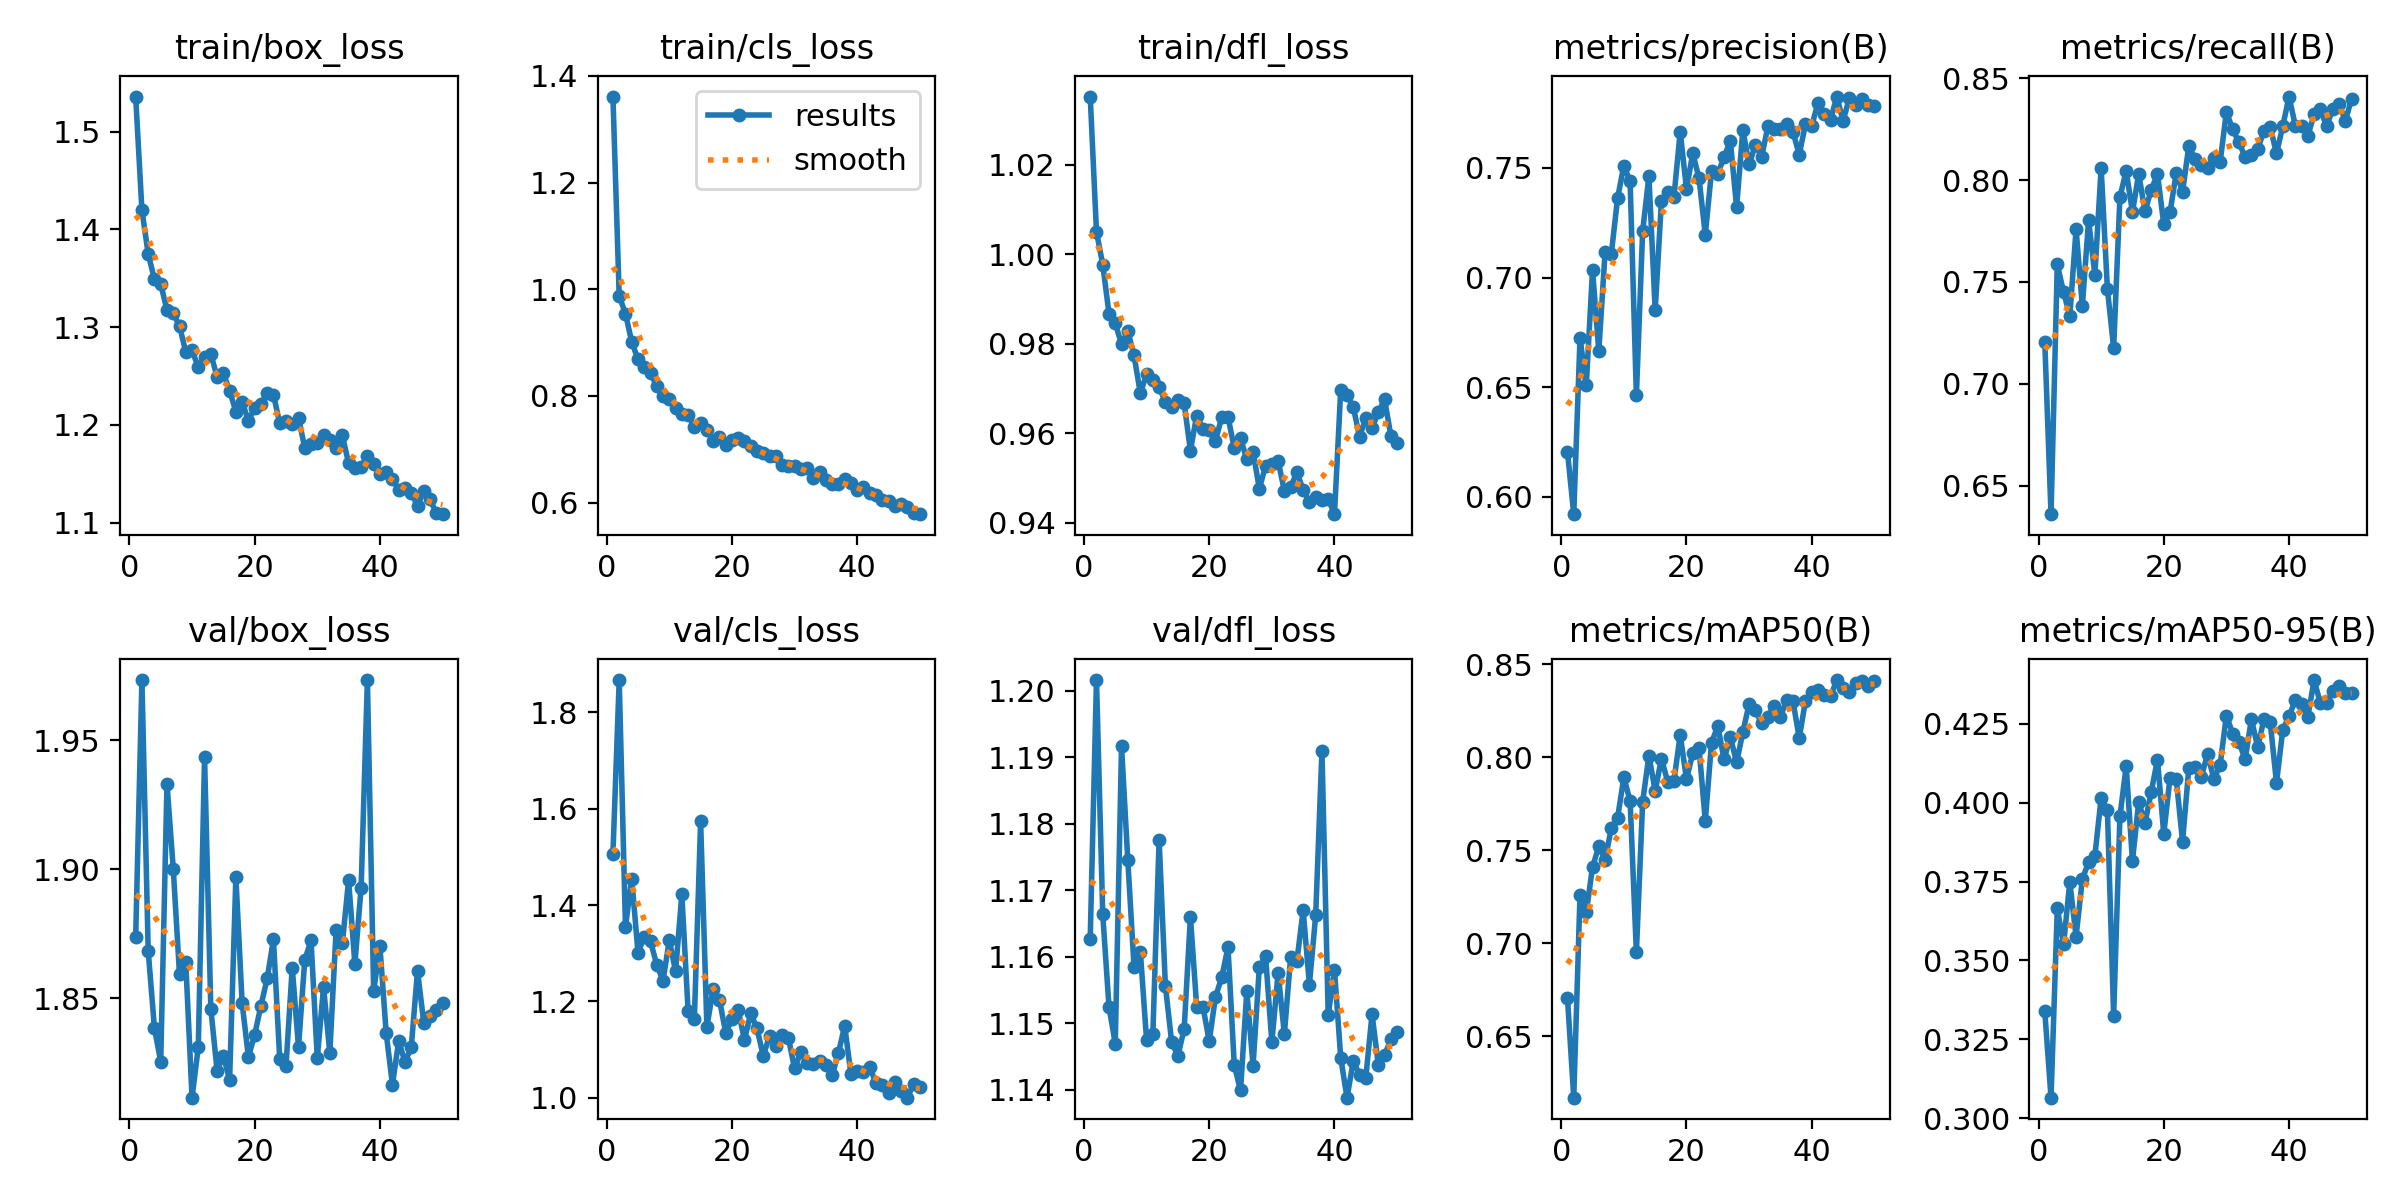

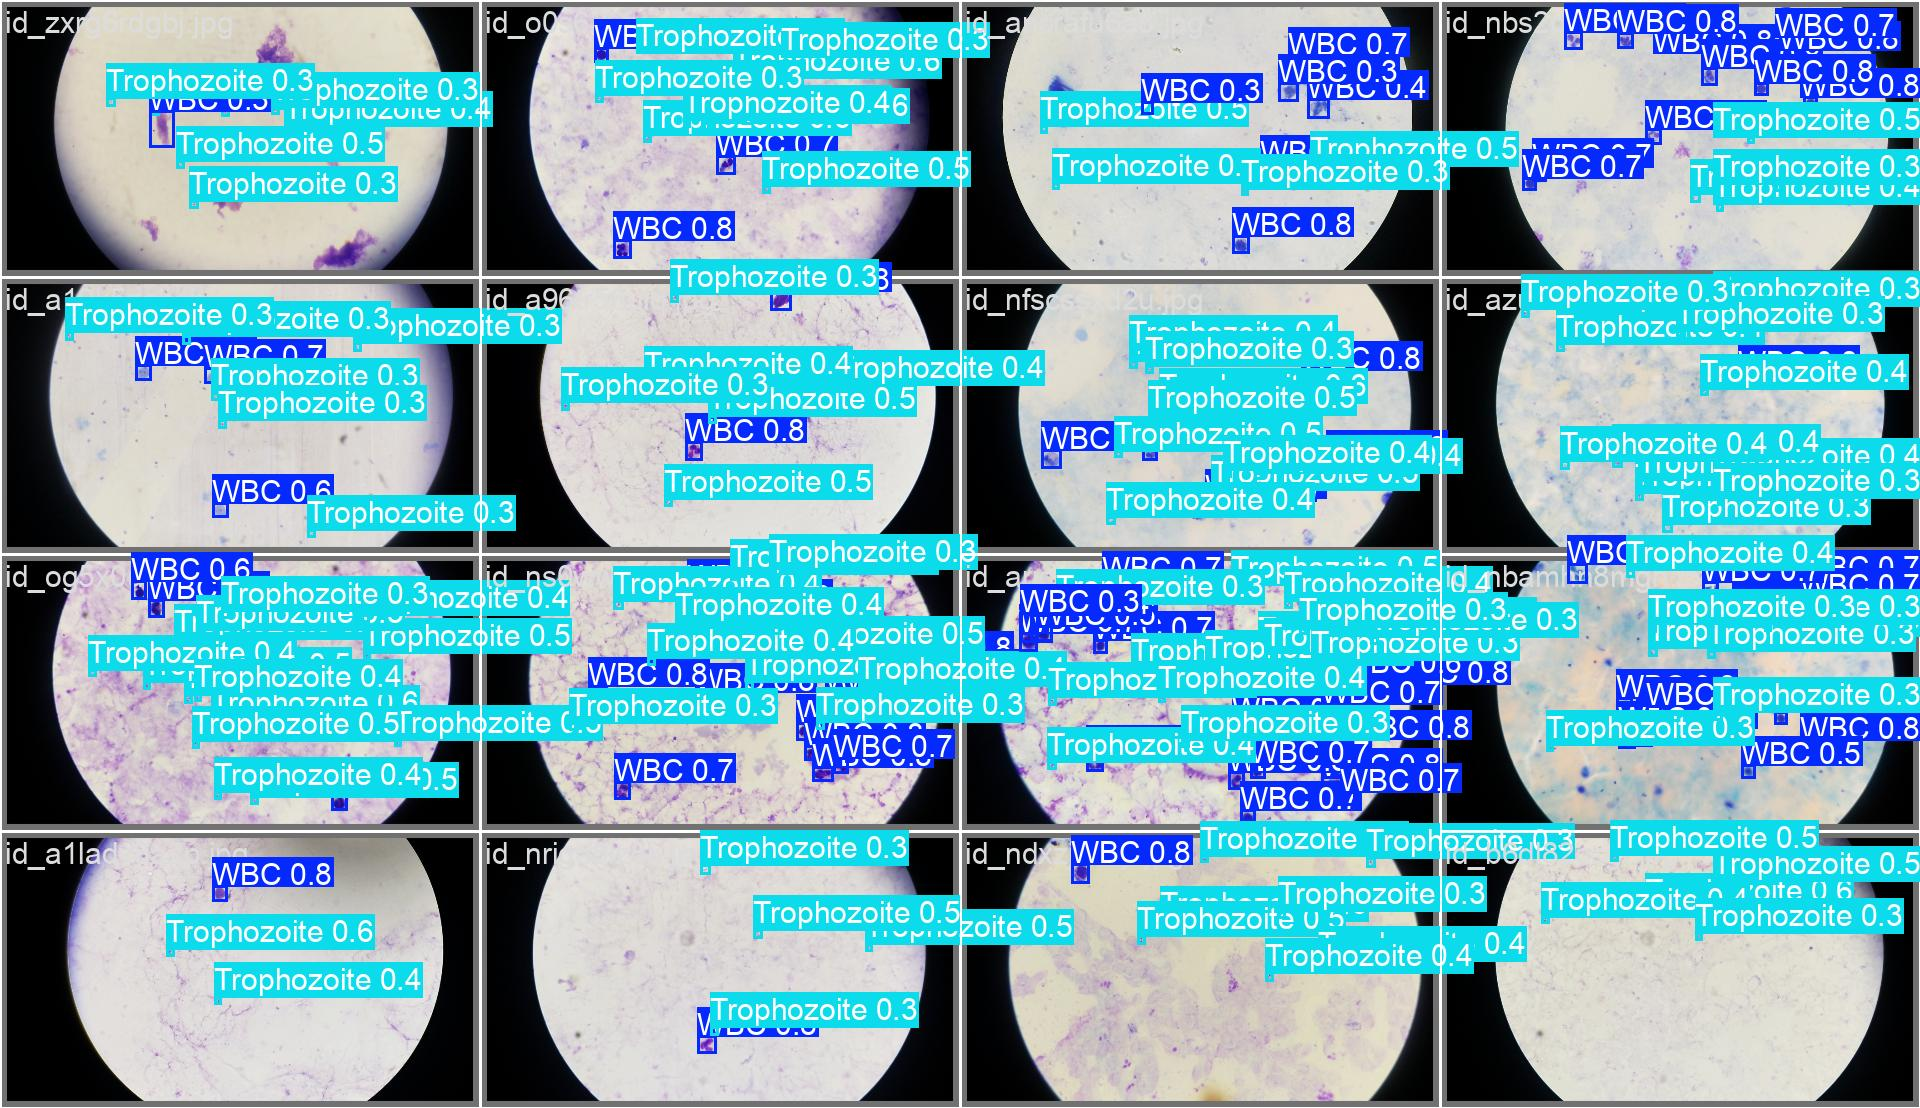

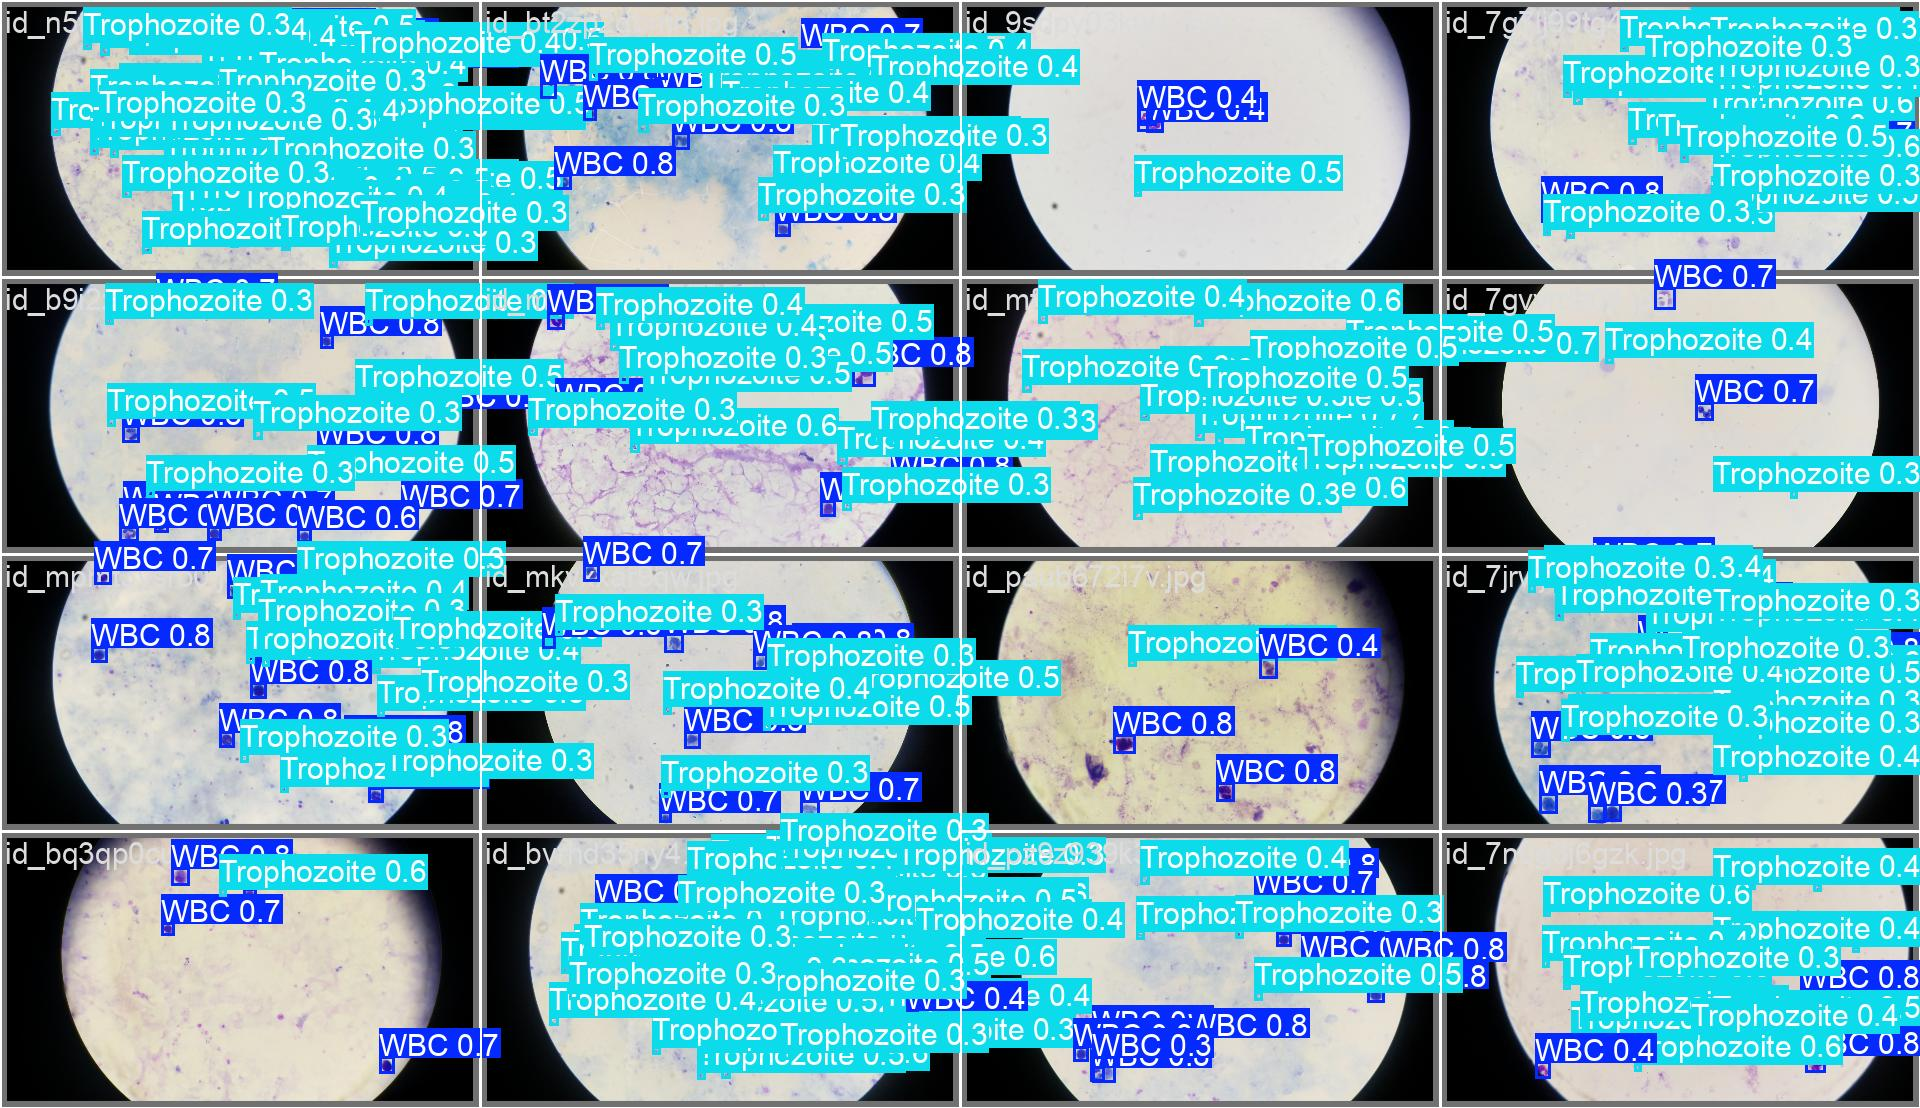

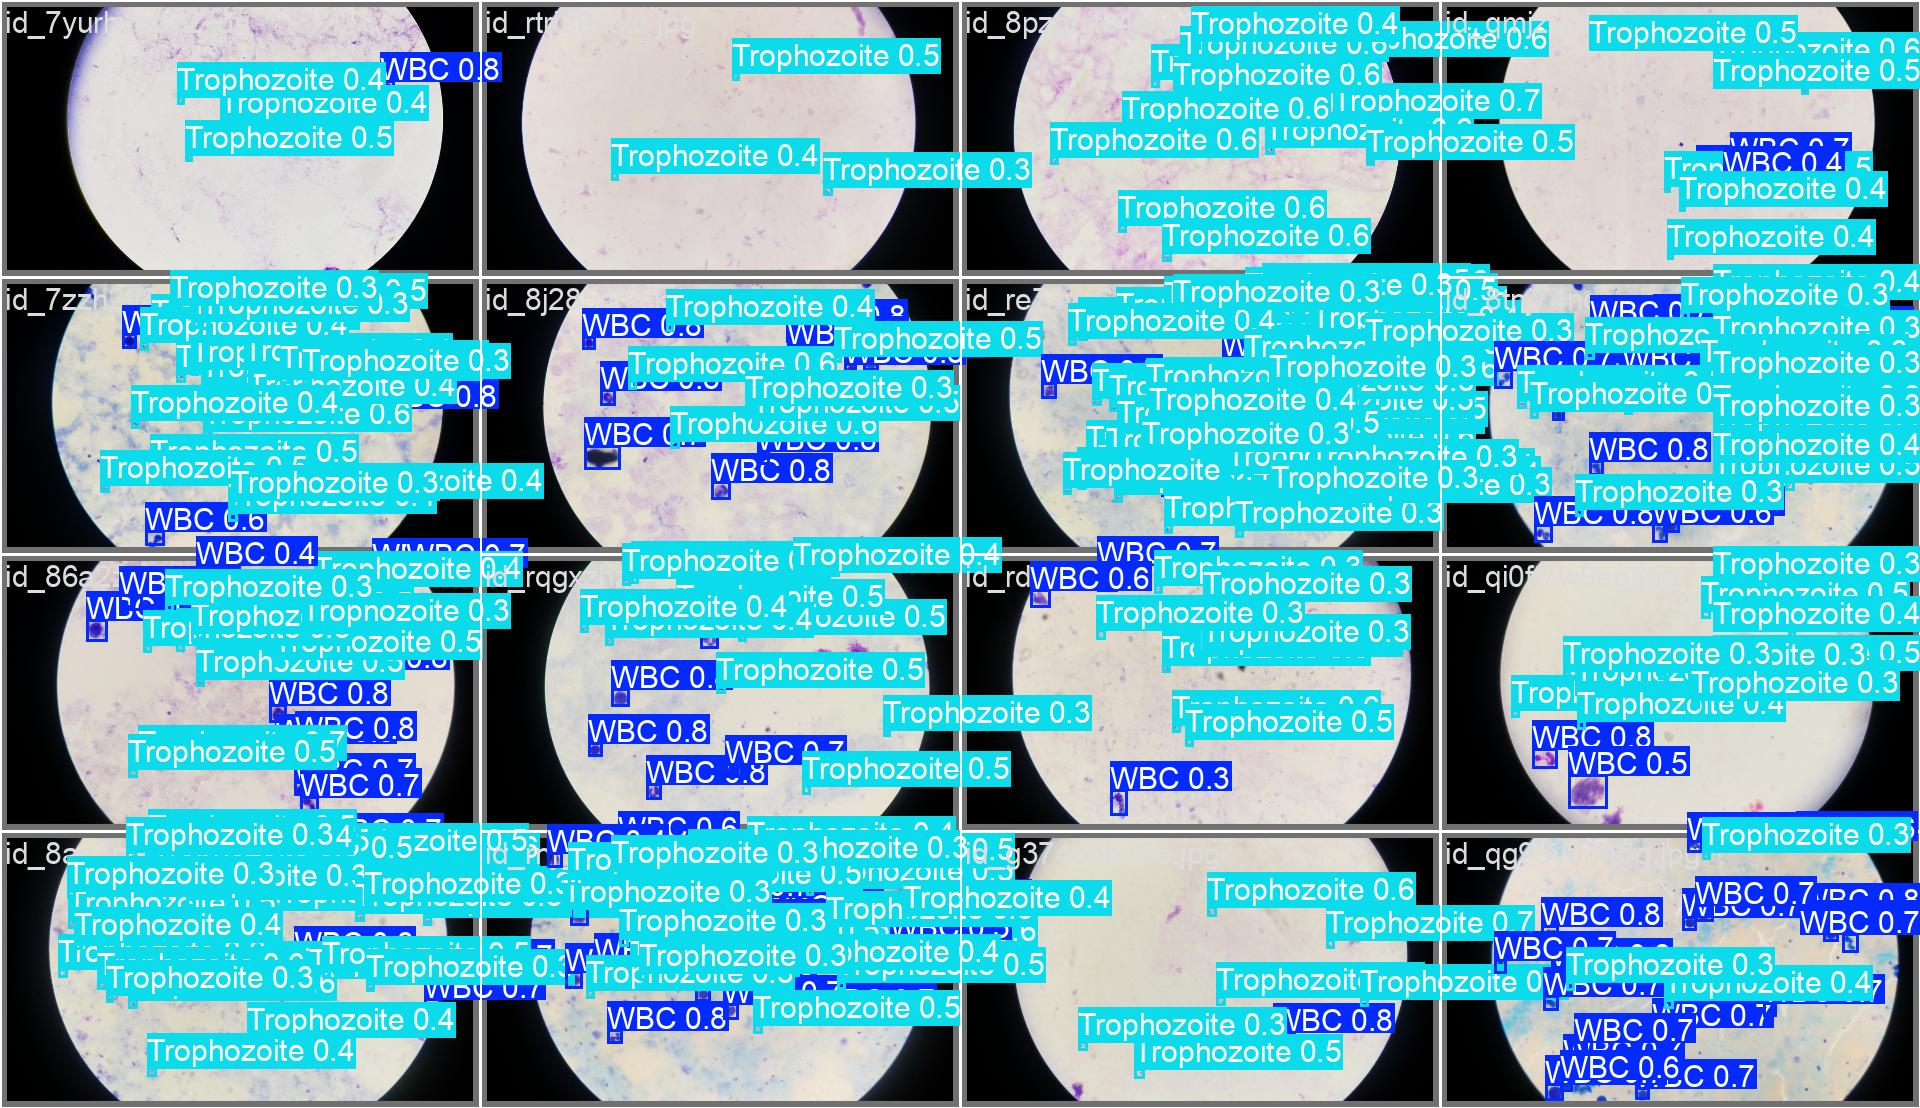

In [30]:
# Display confusion matrix and validation images
def display_training_images():
    image_files = [
        'confusion_matrix.png',
        'results.png',
        'val_batch0_pred.jpg',
        'val_batch1_pred.jpg',
        'val_batch2_pred.jpg'
    ]

    for img_file in image_files:
        img_path = os.path.join(training_results_dir, img_file)
        if os.path.exists(img_path):
            display(Image(filename=img_path))
display_training_images()

In [31]:
# Required Libraries
import os
import zipfile
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import multiprocessing
import numpy as np

In [32]:
test_dir_path = '/root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test'

In [33]:
# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [34]:
# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

In [35]:
# Initialize an empty list to store the results for all images
all_data = []

In [36]:
# Initialize the number of images to display with bounding boxes
display_count = 5
displayed = 0

  0%|          | 0/1178 [00:00<?, ?it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2lhrbf77z4.jpg: 768x1024 (no detections), 41.2ms
Speed: 6.8ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 1/1178 [00:00<07:51,  2.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u2tz4d81aj.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 2/1178 [00:00<04:27,  4.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_powu3799u2.jpg: 576x1024 3 Trophozoites, 67.5ms
Speed: 9.5ms preprocess, 67.5ms inference, 11.4ms postprocess per image at shape (1, 3, 576, 1024)


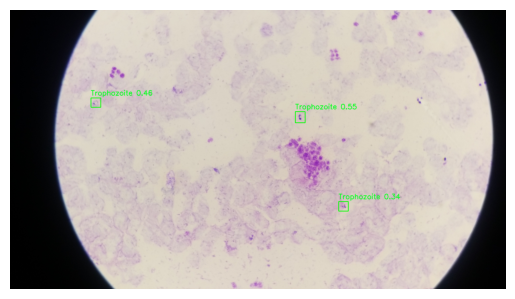

  0%|          | 3/1178 [00:01<07:36,  2.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vxva40gwqs.jpg: 768x1024 6 WBCs, 3 Trophozoites, 26.9ms
Speed: 10.2ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


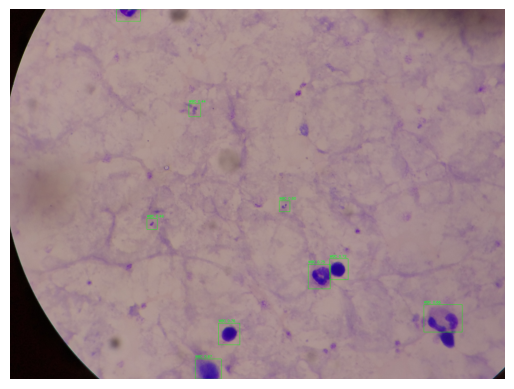

  0%|          | 4/1178 [00:02<16:32,  1.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_99tjq11ke4.jpg: 576x1024 6 WBCs, 5 Trophozoites, 20.9ms
Speed: 11.4ms preprocess, 20.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)


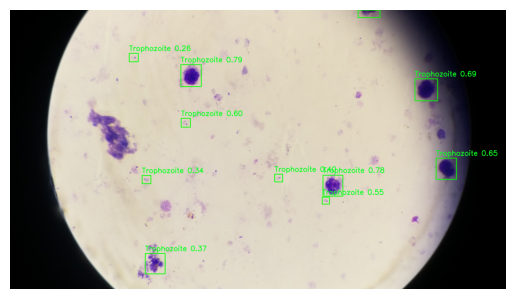

  0%|          | 5/1178 [00:02<12:59,  1.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8m6prlbhsm.jpg: 768x1024 7 Trophozoites, 27.7ms
Speed: 6.5ms preprocess, 27.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


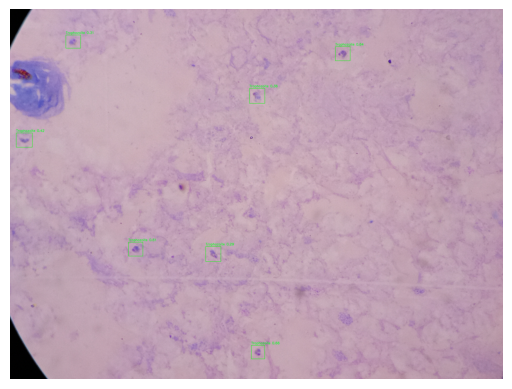

  1%|          | 6/1178 [00:04<15:56,  1.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_obcwfz1rep.jpg: 576x1024 2 WBCs, 15 Trophozoites, 22.2ms
Speed: 8.2ms preprocess, 22.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)


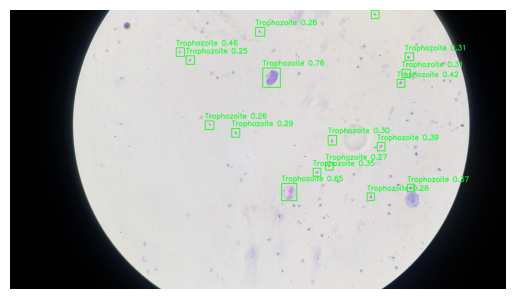

  1%|          | 7/1178 [00:04<12:43,  1.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hgbjiahk9e.jpg: 768x1024 1 WBC, 18 Trophozoites, 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 8/1178 [00:04<09:32,  2.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2ownnbdbb3.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 9/1178 [00:04<07:25,  2.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8lnvvn9bfu.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 10/1178 [00:04<06:05,  3.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h4ly87ik2t.jpg: 768x1024 4 WBCs, 3 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 11/1178 [00:04<05:02,  3.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t4y03l1pft.jpg: 768x1024 9 Trophozoites, 25.9ms
Speed: 6.6ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 12/1178 [00:05<04:29,  4.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3rwwlb4s55.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 13/1178 [00:05<03:58,  4.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n7lkbmg09s.jpg: 768x1024 5 WBCs, 8 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 14/1178 [00:05<03:39,  5.30it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_adje7d6p6o.jpg: 576x1024 2 WBCs, 17 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rub1289twm.jpg: 576x1024 2 WBCs, 5 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


  1%|▏         | 16/1178 [00:05<02:26,  7.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nnurq35wvp.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_llogo91lpl.jpg: 768x1024 1 WBC, 15 Trophozoites, 25.8ms
Speed: 8.2ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 18/1178 [00:05<02:32,  7.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_knukwh53dg.jpg: 768x1024 4 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 19/1178 [00:05<02:33,  7.56it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e92tr3rpox.jpg: 576x1024 3 WBCs, 1 Trophozoite, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_te8l04zfrd.jpg: 768x1024 3 Trophozoites, 26.7ms
Speed: 6.4ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 21/1178 [00:06<02:18,  8.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4x8jxbdd4k.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 22/1178 [00:06<02:24,  7.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_02kpdbnrfn.jpg: 768x1024 11 WBCs, 8 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 23/1178 [00:06<02:29,  7.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9c63zqxmqc.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 24/1178 [00:06<02:34,  7.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_do31k8wo88.jpg: 576x1024 6 WBCs, 11 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vap1fogdnd.jpg: 576x1024 3 WBCs, 6 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 26/1178 [00:06<01:56,  9.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rabc5okoix.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w4h5g5vplj.jpg: 576x1024 10 WBCs, 3 Trophozoites, 20.4ms
Speed: 7.7ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 28/1178 [00:06<01:54, 10.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u9ifnx7sy7.jpg: 768x1024 1 WBC, 4 Trophozoites, 26.8ms
Speed: 8.1ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ta8ulnvuuu.jpg: 576x1024 2 WBCs, 3 Trophozoites, 20.6ms
Speed: 8.1ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 30/1178 [00:07<01:54, 10.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c3a6itth3n.jpg: 768x1024 (no detections), 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6y0igbi0m3.jpg: 768x1024 5 WBCs, 7 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 32/1178 [00:07<02:08,  8.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_97fz35hieo.jpg: 768x1024 11 Trophozoites, 25.8ms
Speed: 7.3ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 33/1178 [00:07<02:22,  8.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_grxayh1ze5.jpg: 576x1024 12 WBCs, 9 Trophozoites, 20.8ms
Speed: 8.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zsxlj9qtf8.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 35/1178 [00:07<02:12,  8.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gaymjiq7c5.jpg: 768x1024 3 WBCs, 10 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 36/1178 [00:07<02:17,  8.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cf9s4lwjmi.jpg: 768x1024 3 WBCs, 3 Trophozoites, 25.8ms
Speed: 7.5ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 37/1178 [00:08<02:23,  7.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_taszbfxxkp.jpg: 576x1024 5 WBCs, 9 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7wtgwt24ou.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.7ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 39/1178 [00:08<02:10,  8.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xfyvahb8tg.jpg: 576x1024 26 WBCs, 14 Trophozoites, 20.5ms
Speed: 7.9ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pk5ee56h6i.jpg: 768x1024 1 WBC, 1 Trophozoite, 26.9ms
Speed: 6.6ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 41/1178 [00:08<02:03,  9.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_09j11tkrz0.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 42/1178 [00:08<02:11,  8.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cgexp6c80c.jpg: 576x1024 10 WBCs, 18 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_90gdtlqky1.jpg: 576x1024 12 WBCs, 7 Trophozoites, 19.6ms
Speed: 6.9ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▎         | 44/1178 [00:08<01:45, 10.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s18arv2vna.jpg: 768x1024 10 WBCs, 7 Trophozoites, 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_auvl05xbb0.jpg: 576x1024 7 WBCs, 13 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 46/1178 [00:08<01:47, 10.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y9xmd0vjl6.jpg: 576x1024 2 WBCs, 14 Trophozoites, 19.7ms
Speed: 7.7ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cyd5mhg6xf.jpg: 768x1024 13 Trophozoites, 26.6ms
Speed: 7.4ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 48/1178 [00:09<01:53,  9.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sbil497x0b.jpg: 576x1024 35 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v0frvu3x6x.jpg: 768x1024 7 Trophozoites, 27.0ms
Speed: 6.5ms preprocess, 27.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 50/1178 [00:09<01:55,  9.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rx25niusfd.jpg: 768x1024 8 WBCs, 9 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3t874dlfwd.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 52/1178 [00:09<02:08,  8.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ltv9pmj2el.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 53/1178 [00:09<02:14,  8.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pvfkzd2ina.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.8ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 54/1178 [00:09<02:19,  8.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ktr9tuu6vv.jpg: 768x1024 2 WBCs, 7 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 55/1178 [00:10<02:22,  7.88it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ycctsdjzt4.jpg: 576x1024 11 WBCs, 13 Trophozoites, 20.6ms
Speed: 7.4ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hzq703z3bf.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 57/1178 [00:10<02:10,  8.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ivy4bzueea.jpg: 768x1024 8 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 58/1178 [00:10<02:19,  8.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tffz6u6gqz.jpg: 768x1024 4 WBCs, 4 Trophozoites, 25.8ms
Speed: 8.8ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 59/1178 [00:10<02:24,  7.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vqhzarwyqr.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 60/1178 [00:10<02:28,  7.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yfaan268o7.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 61/1178 [00:10<02:30,  7.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0fwcplj2bp.jpg: 768x1024 4 WBCs, 2 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 62/1178 [00:10<02:30,  7.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yfssovxo2l.jpg: 576x1024 12 Trophozoites, 21.0ms
Speed: 7.7ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_a02yjsdagb.jpg: 576x1024 8 WBCs, 6 Trophozoites, 19.6ms
Speed: 8.9ms preprocess, 19.6ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 64/1178 [00:11<01:52,  9.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e0fxcrm3hg.jpg: 576x1024 8 WBCs, 10 Trophozoites, 19.7ms
Speed: 8.1ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_aomyd41llq.jpg: 576x1024 6 WBCs, 7 Trophozoites, 19.6ms
Speed: 7.8ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 66/1178 [00:11<01:33, 11.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lltmikwiqu.jpg: 768x1024 8 Trophozoites, 26.6ms
Speed: 6.6ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hbf04mshwf.jpg: 768x1024 8 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 68/1178 [00:11<02:01,  9.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ob4nb0r9m7.jpg: 576x1024 2 WBCs, 4 Trophozoites, 23.0ms
Speed: 10.5ms preprocess, 23.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lyik8bvy4d.jpg: 576x1024 1 WBC, 3 Trophozoites, 19.6ms
Speed: 7.0ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 70/1178 [00:11<01:42, 10.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_knag3u90ae.jpg: 768x1024 5 Trophozoites, 26.7ms
Speed: 6.8ms preprocess, 26.7ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6peodc0rxm.jpg: 768x1024 4 WBCs, 6 Trophozoites, 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 72/1178 [00:11<02:03,  8.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i96memkp09.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.7ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dq0b8an5k9.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▋         | 74/1178 [00:12<02:14,  8.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ve7bpb1ouv.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▋         | 75/1178 [00:12<02:19,  7.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s6p2a9lupx.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▋         | 76/1178 [00:12<02:23,  7.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zhar8at1nq.jpg: 768x1024 5 WBCs, 10 Trophozoites, 25.7ms
Speed: 7.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 77/1178 [00:12<02:28,  7.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pv6ghvn6ox.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 78/1178 [00:12<02:29,  7.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_di2hwdr3ad.jpg: 768x1024 2 WBCs, 6 Trophozoites, 25.8ms
Speed: 10.3ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 79/1178 [00:12<02:40,  6.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ww0nb4y3ip.jpg: 768x1024 8 WBCs, 3 Trophozoites, 30.1ms
Speed: 14.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 80/1178 [00:13<02:51,  6.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ztmiz149m1.jpg: 768x1024 (no detections), 25.9ms
Speed: 9.2ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 81/1178 [00:13<02:56,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nu3iyv45gw.jpg: 576x1024 10 WBCs, 10 Trophozoites, 20.8ms
Speed: 7.9ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cjgaqn1ig6.jpg: 576x1024 8 WBCs, 11 Trophozoites, 19.8ms
Speed: 7.9ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 83/1178 [00:13<02:06,  8.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v2ksyykjks.jpg: 768x1024 2 WBCs, 3 Trophozoites, 29.0ms
Speed: 10.9ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 84/1178 [00:13<02:22,  7.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_238738v2x6.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 85/1178 [00:13<02:36,  7.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8fl68udpol.jpg: 576x1024 12 WBCs, 94 Trophozoites, 24.7ms
Speed: 10.5ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5t3wpy23rc.jpg: 768x1024 (no detections), 27.2ms
Speed: 10.7ms preprocess, 27.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 87/1178 [00:14<02:28,  7.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mvael7b5ar.jpg: 768x1024 (no detections), 25.8ms
Speed: 21.1ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 88/1178 [00:14<02:59,  6.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4wqxt35op6.jpg: 768x1024 (no detections), 40.8ms
Speed: 24.9ms preprocess, 40.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 89/1178 [00:14<03:45,  4.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n87hn2eg5k.jpg: 768x1024 1 WBC, 3 Trophozoites, 29.5ms
Speed: 23.7ms preprocess, 29.5ms inference, 3.4ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 90/1178 [00:14<04:07,  4.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_19t2jeax4w.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 91/1178 [00:15<04:02,  4.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ntv9yuxczt.jpg: 576x1024 4 WBCs, 6 Trophozoites, 20.8ms
Speed: 11.7ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_77jnlmiwe5.jpg: 768x1024 (no detections), 26.7ms
Speed: 10.1ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 93/1178 [00:15<03:13,  5.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mbcekw2a5j.jpg: 576x1024 2 WBCs, 6 Trophozoites, 25.5ms
Speed: 12.6ms preprocess, 25.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mxwpb51i2g.jpg: 768x1024 9 Trophozoites, 27.2ms
Speed: 8.6ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 95/1178 [00:15<02:58,  6.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_saiwybb23h.jpg: 768x1024 7 Trophozoites, 25.8ms
Speed: 10.1ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 96/1178 [00:15<03:06,  5.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s9u0fh5ysa.jpg: 768x1024 5 WBCs, 7 Trophozoites, 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 97/1178 [00:16<03:04,  5.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t3it3ae1zq.jpg: 576x1024 2 WBCs, 3 Trophozoites, 20.9ms
Speed: 11.4ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6xiz7ozoa3.jpg: 576x1024 4 WBCs, 6 Trophozoites, 19.6ms
Speed: 8.8ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 99/1178 [00:16<02:15,  7.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ympkzkmzis.jpg: 768x1024 3 WBCs, 4 Trophozoites, 26.8ms
Speed: 11.8ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 100/1178 [00:16<02:28,  7.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gshkwenm75.jpg: 576x1024 9 WBCs, 12 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8808ge2vjf.jpg: 576x1024 4 Trophozoites, 19.7ms
Speed: 9.9ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 102/1178 [00:16<01:56,  9.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hjz7mrzs0z.jpg: 768x1024 4 WBCs, 8 Trophozoites, 28.0ms
Speed: 12.5ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b6aggvh5mo.jpg: 768x1024 4 WBCs, 4 Trophozoites, 25.8ms
Speed: 7.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 104/1178 [00:16<02:22,  7.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3il5b5w7oe.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 105/1178 [00:16<02:27,  7.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v5f29ajik8.jpg: 576x1024 1 Trophozoite, 20.9ms
Speed: 9.2ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ntb0vmduwc.jpg: 576x1024 2 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 107/1178 [00:17<01:55,  9.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7cahlewdis.jpg: 768x1024 2 WBCs, 17 Trophozoites, 26.7ms
Speed: 6.6ms preprocess, 26.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_osola6o3wc.jpg: 576x1024 5 WBCs, 2 Trophozoites, 20.3ms
Speed: 7.8ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 109/1178 [00:17<01:52,  9.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i9ewptr6hl.jpg: 768x1024 (no detections), 26.5ms
Speed: 7.1ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8i960rzke1.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 111/1178 [00:17<02:05,  8.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nwba60jcii.jpg: 768x1024 5 WBCs, 8 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 112/1178 [00:17<02:10,  8.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hfqqfm9i58.jpg: 768x1024 4 WBCs, 19 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 113/1178 [00:17<02:13,  7.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6uga4j2wdu.jpg: 576x1024 6 WBCs, 7 Trophozoites, 20.9ms
Speed: 8.1ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bjb5cbk3ge.jpg: 768x1024 3 WBCs, 4 Trophozoites, 26.9ms
Speed: 6.6ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 115/1178 [00:18<02:03,  8.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lafvsvft7n.jpg: 768x1024 8 WBCs, 11 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 116/1178 [00:18<02:11,  8.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jtk75kmue0.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 117/1178 [00:18<02:17,  7.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ejc71yvhrn.jpg: 768x1024 (no detections), 25.7ms
Speed: 7.3ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 118/1178 [00:18<02:20,  7.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6k34wx0iqg.jpg: 576x1024 5 WBCs, 5 Trophozoites, 20.5ms
Speed: 7.8ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_757gg6410g.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.6ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 120/1178 [00:18<02:06,  8.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5whi7wnd3e.jpg: 576x1024 15 WBCs, 5 Trophozoites, 20.5ms
Speed: 7.9ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lxutittd8p.jpg: 768x1024 (no detections), 26.4ms
Speed: 6.6ms preprocess, 26.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 122/1178 [00:18<01:57,  8.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gs3jxuriz2.jpg: 576x1024 17 WBCs, 23.8ms
Speed: 7.9ms preprocess, 23.8ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ekbcm1s1gc.jpg: 768x1024 1 WBC, 5 Trophozoites, 26.7ms
Speed: 7.8ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 124/1178 [00:19<01:55,  9.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8pfpu7zm2c.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 125/1178 [00:19<02:00,  8.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5h9byqfx7x.jpg: 576x1024 1 WBC, 11 Trophozoites, 20.6ms
Speed: 8.0ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nlwpwbie4k.jpg: 768x1024 6 Trophozoites, 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 127/1178 [00:19<01:53,  9.26it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t5sklk78fx.jpg: 768x1024 2 WBCs, 2 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 128/1178 [00:19<02:00,  8.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lk8v7lhats.jpg: 576x1024 3 WBCs, 5 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3su13btien.jpg: 768x1024 (no detections), 29.1ms
Speed: 6.5ms preprocess, 29.1ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 130/1178 [00:19<01:55,  9.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vhpkv93jhn.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 131/1178 [00:19<02:03,  8.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zzeqlbyhta.jpg: 576x1024 17 WBCs, 19 Trophozoites, 21.0ms
Speed: 7.7ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sueejj6rn7.jpg: 768x1024 (no detections), 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 133/1178 [00:20<01:59,  8.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rmaystltgx.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 134/1178 [00:20<02:05,  8.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6ttmu9eh7o.jpg: 768x1024 1 WBC, 13 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 135/1178 [00:20<02:08,  8.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_takxmc0c1v.jpg: 768x1024 7 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 136/1178 [00:20<02:18,  7.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7c4t2fykmq.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 137/1178 [00:20<02:21,  7.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7l122v70fp.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 138/1178 [00:20<02:23,  7.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_peqagrhdz0.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 139/1178 [00:20<02:24,  7.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q065al6twy.jpg: 576x1024 20 WBCs, 18 Trophozoites, 20.9ms
Speed: 7.8ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wu45v4wmz6.jpg: 768x1024 7 Trophozoites, 26.6ms
Speed: 6.6ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 141/1178 [00:21<02:12,  7.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_twft9r61zp.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 142/1178 [00:21<02:16,  7.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1mf35d73se.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 143/1178 [00:21<02:19,  7.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bz9mk8i05d.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 144/1178 [00:21<02:25,  7.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4201tpw5k7.jpg: 768x1024 6 WBCs, 10 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 145/1178 [00:21<02:24,  7.15it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zvipbz5x8l.jpg: 576x1024 6 WBCs, 3 Trophozoites, 20.6ms
Speed: 6.3ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5n9ov0rr22.jpg: 768x1024 2 WBCs, 13 Trophozoites, 26.4ms
Speed: 6.5ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 147/1178 [00:21<02:04,  8.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fbzk8ozrjy.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 148/1178 [00:22<02:14,  7.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6y47760yc3.jpg: 576x1024 1 WBC, 5 Trophozoites, 20.6ms
Speed: 7.7ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2uc8ow849t.jpg: 576x1024 9 WBCs, 16 Trophozoites, 19.7ms
Speed: 8.6ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 150/1178 [00:22<01:44,  9.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6irbw5zd3h.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.5ms preprocess, 26.7ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zd19abdjrt.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 152/1178 [00:22<01:59,  8.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nvvnargqlh.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 153/1178 [00:22<02:02,  8.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w7ffbt8mn3.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 154/1178 [00:22<02:12,  7.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7dpe8landj.jpg: 768x1024 1 Trophozoite, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 155/1178 [00:22<02:13,  7.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ep94vmxw7e.jpg: 768x1024 9 Trophozoites, 25.8ms
Speed: 7.5ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 156/1178 [00:23<02:26,  6.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k8i7zx22wr.jpg: 576x1024 4 WBCs, 4 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eolvvnntb2.jpg: 768x1024 (no detections), 26.4ms
Speed: 6.6ms preprocess, 26.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 158/1178 [00:23<02:06,  8.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ym2q93cgkd.jpg: 768x1024 9 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 159/1178 [00:23<02:14,  7.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8zzqe9y36l.jpg: 768x1024 6 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 160/1178 [00:23<02:20,  7.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kw30dj6ngz.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 161/1178 [00:23<02:23,  7.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_upzukj6bar.jpg: 768x1024 1 WBC, 13 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 162/1178 [00:23<02:22,  7.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ovbss3576v.jpg: 768x1024 10 Trophozoites, 25.9ms
Speed: 11.8ms preprocess, 25.9ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 163/1178 [00:24<02:32,  6.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7mfpjkr863.jpg: 576x1024 5 WBCs, 22 Trophozoites, 20.6ms
Speed: 8.3ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3i73f5tlyy.jpg: 768x1024 5 WBCs, 10 Trophozoites, 26.4ms
Speed: 6.4ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 165/1178 [00:24<02:08,  7.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7h5gr9it2s.jpg: 576x1024 19 WBCs, 3 Trophozoites, 20.5ms
Speed: 7.8ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yjirqzklk4.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 167/1178 [00:24<01:56,  8.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2thtagu0zp.jpg: 768x1024 1 WBC, 3 Trophozoites, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 168/1178 [00:24<02:04,  8.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_epr49kxfdt.jpg: 576x1024 4 WBCs, 50 Trophozoites, 25.4ms
Speed: 49.8ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 169/1178 [00:24<02:15,  7.46it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rz5gftyagu.jpg: 768x1024 9 WBCs, 2 Trophozoites, 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 170/1178 [00:24<02:19,  7.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ls63t11ouc.jpg: 768x1024 12 Trophozoites, 25.8ms
Speed: 10.1ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 171/1178 [00:25<02:31,  6.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8r8s66ywit.jpg: 768x1024 8 WBCs, 12 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 172/1178 [00:25<02:28,  6.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mor89a47be.jpg: 576x1024 4 WBCs, 8 Trophozoites, 20.6ms
Speed: 7.0ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o9lqswex7w.jpg: 768x1024 7 Trophozoites, 27.0ms
Speed: 22.8ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 174/1178 [00:25<02:26,  6.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ijjpc914s4.jpg: 576x1024 12 WBCs, 10 Trophozoites, 20.6ms
Speed: 9.4ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tbrfcsggso.jpg: 768x1024 24 Trophozoites, 26.7ms
Speed: 7.3ms preprocess, 26.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 176/1178 [00:25<02:08,  7.82it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_aj6j6z6b5d.jpg: 576x1024 5 WBCs, 5 Trophozoites, 21.2ms
Speed: 7.9ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h5dl7mzh9m.jpg: 768x1024 4 WBCs, 24 Trophozoites, 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 178/1178 [00:26<01:58,  8.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2490duivzq.jpg: 576x1024 31 WBCs, 4 Trophozoites, 22.0ms
Speed: 10.7ms preprocess, 22.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t9xdp2g0nv.jpg: 768x1024 3 WBCs, 34 Trophozoites, 35.6ms
Speed: 28.0ms preprocess, 35.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 180/1178 [00:26<02:08,  7.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rgi4tm8o7f.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 181/1178 [00:26<02:12,  7.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hshi0o26ey.jpg: 576x1024 7 WBCs, 4 Trophozoites, 20.6ms
Speed: 9.7ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oo1t9u2ry7.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 183/1178 [00:26<02:01,  8.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_myj3h2doss.jpg: 768x1024 3 WBCs, 9 Trophozoites, 25.8ms
Speed: 9.9ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 184/1178 [00:26<02:09,  7.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7dsfle2xvr.jpg: 768x1024 (no detections), 26.6ms
Speed: 10.1ms preprocess, 26.6ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 185/1178 [00:27<02:21,  7.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8471pg3676.jpg: 768x1024 (no detections), 25.9ms
Speed: 10.7ms preprocess, 25.9ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 186/1178 [00:27<02:32,  6.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mda73d9z2x.jpg: 576x1024 1 WBC, 2 Trophozoites, 23.7ms
Speed: 11.1ms preprocess, 23.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xrze4t2gfj.jpg: 768x1024 3 WBCs, 8 Trophozoites, 26.8ms
Speed: 14.0ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 188/1178 [00:27<02:19,  7.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ktv4d0izjv.jpg: 768x1024 8 WBCs, 16 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 189/1178 [00:27<02:23,  6.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ep7kg4wtcd.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 190/1178 [00:27<02:28,  6.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n86jp6z489.jpg: 768x1024 11 Trophozoites, 25.8ms
Speed: 10.0ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 191/1178 [00:27<02:42,  6.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fyhhh6dymi.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 192/1178 [00:28<02:50,  5.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9q15gc4k1j.jpg: 768x1024 4 WBCs, 8 Trophozoites, 25.8ms
Speed: 11.8ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 193/1178 [00:28<02:47,  5.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ktxtsz78z8.jpg: 768x1024 5 WBCs, 6 Trophozoites, 25.8ms
Speed: 11.8ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 194/1178 [00:28<02:51,  5.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7uvihya5z9.jpg: 768x1024 2 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 195/1178 [00:28<02:47,  5.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_islu7q0ozu.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 196/1178 [00:28<02:45,  5.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zhq79x4qxm.jpg: 768x1024 2 WBCs, 5 Trophozoites, 25.8ms
Speed: 13.0ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 197/1178 [00:28<02:41,  6.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sorqha6avz.jpg: 576x1024 2 WBCs, 6 Trophozoites, 20.9ms
Speed: 8.5ms preprocess, 20.9ms inference, 6.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wpps6sjeg0.jpg: 576x1024 12 WBCs, 12 Trophozoites, 19.9ms
Speed: 8.1ms preprocess, 19.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 199/1178 [00:29<01:55,  8.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oaz02y4w9a.jpg: 576x1024 3 WBCs, 4 Trophozoites, 19.6ms
Speed: 9.2ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rnaoxp2hpr.jpg: 768x1024 1 WBC, 3 Trophozoites, 28.9ms
Speed: 13.4ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 201/1178 [00:29<01:55,  8.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yrd7e5ko11.jpg: 576x1024 6 WBCs, 9 Trophozoites, 20.7ms
Speed: 7.7ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_88ogs3yb2y.jpg: 768x1024 3 Trophozoites, 28.9ms
Speed: 12.9ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 203/1178 [00:29<02:03,  7.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4qz3sqpvrc.jpg: 768x1024 1 WBC, 6 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 204/1178 [00:29<02:11,  7.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k84n37u083.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.2ms preprocess, 25.8ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 205/1178 [00:29<02:20,  6.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mrewnlo2vc.jpg: 576x1024 2 WBCs, 20.7ms
Speed: 9.2ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nat0o2k29g.jpg: 576x1024 8 WBCs, 97 Trophozoites, 21.5ms
Speed: 9.3ms preprocess, 21.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 207/1178 [00:30<01:48,  8.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cz6tcgqpvw.jpg: 576x1024 1 WBC, 1 Trophozoite, 19.6ms
Speed: 8.4ms preprocess, 19.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5xruvd0mz6.jpg: 768x1024 (no detections), 26.8ms
Speed: 10.1ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 209/1178 [00:30<01:50,  8.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xkra1n5v6n.jpg: 576x1024 3 WBCs, 2 Trophozoites, 20.7ms
Speed: 8.1ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8ffk8vs3j6.jpg: 768x1024 (no detections), 26.5ms
Speed: 10.9ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 211/1178 [00:30<01:49,  8.82it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h0p2p4b7ic.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 212/1178 [00:30<01:54,  8.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xnumxmam7g.jpg: 768x1024 20 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 213/1178 [00:30<01:58,  8.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8wd3snpxm6.jpg: 768x1024 7 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 214/1178 [00:31<02:07,  7.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oixxh8vdl9.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 215/1178 [00:31<02:12,  7.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_btrtdkgk4r.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 216/1178 [00:31<02:14,  7.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cx0plmjmmf.jpg: 576x1024 5 Trophozoites, 20.5ms
Speed: 7.6ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cx4af02p3e.jpg: 768x1024 2 WBCs, 3 Trophozoites, 26.7ms
Speed: 6.6ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 218/1178 [00:31<01:58,  8.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wl9ihgu82j.jpg: 576x1024 2 WBCs, 12 Trophozoites, 20.5ms
Speed: 7.6ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_101shg43c9.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 220/1178 [00:31<01:49,  8.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1blijq2mbi.jpg: 768x1024 5 WBCs, 10 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 221/1178 [00:31<01:54,  8.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tfya66fvv4.jpg: 768x1024 2 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 222/1178 [00:32<02:03,  7.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ski6q2tfhu.jpg: 576x1024 3 WBCs, 4 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yidnki55au.jpg: 576x1024 4 WBCs, 10 Trophozoites, 19.7ms
Speed: 7.9ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 224/1178 [00:32<01:36,  9.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_soh15k7lsc.jpg: 768x1024 5 WBCs, 25 Trophozoites, 26.6ms
Speed: 7.2ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zd9te4gh5e.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 226/1178 [00:32<01:50,  8.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ajrmp0itrk.jpg: 768x1024 1 WBC, 2 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 227/1178 [00:32<01:56,  8.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3wdknzmrxd.jpg: 768x1024 (no detections), 25.8ms
Speed: 13.0ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 228/1178 [00:32<02:03,  7.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bauml2h11u.jpg: 768x1024 7 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 229/1178 [00:32<02:10,  7.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yn0dsrwuz7.jpg: 768x1024 2 WBCs, 1 Trophozoite, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 230/1178 [00:33<02:11,  7.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oxi3v101sp.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 231/1178 [00:33<02:15,  6.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_a91yo855yk.jpg: 576x1024 1 WBC, 5 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_czyks3vk91.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 233/1178 [00:33<01:57,  8.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q7j5izizmt.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 234/1178 [00:33<02:02,  7.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_f4t8wxbbo5.jpg: 768x1024 2 WBCs, 2 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 235/1178 [00:33<02:06,  7.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oorm6uuagx.jpg: 768x1024 2 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 236/1178 [00:33<02:06,  7.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6wynwn4dh2.jpg: 576x1024 2 WBCs, 62 Trophozoites, 20.5ms
Speed: 7.8ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ct56s6romz.jpg: 576x1024 15 WBCs, 25 Trophozoites, 19.6ms
Speed: 7.9ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 238/1178 [00:33<01:35,  9.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_emvg4lop84.jpg: 768x1024 9 Trophozoites, 26.6ms
Speed: 7.7ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6wu958eu3i.jpg: 576x1024 3 WBCs, 67 Trophozoites, 20.5ms
Speed: 8.2ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 240/1178 [00:34<01:40,  9.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gcpuzueyn2.jpg: 768x1024 15 Trophozoites, 26.8ms
Speed: 6.6ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 241/1178 [00:34<01:50,  8.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2etdltga5u.jpg: 576x1024 10 WBCs, 13 Trophozoites, 20.8ms
Speed: 7.8ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_afs3jybna0.jpg: 768x1024 5 WBCs, 10 Trophozoites, 26.7ms
Speed: 6.4ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 243/1178 [00:34<01:42,  9.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u6ileuvpot.jpg: 768x1024 4 WBCs, 3 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 244/1178 [00:34<01:51,  8.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_peft8cak3r.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 245/1178 [00:34<01:57,  7.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fu1i0g3ysz.jpg: 576x1024 7 WBCs, 9 Trophozoites, 20.9ms
Speed: 7.7ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ywek4ncobs.jpg: 576x1024 4 WBCs, 7 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 247/1178 [00:34<01:31, 10.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i7dta453kt.jpg: 768x1024 2 WBCs, 10 Trophozoites, 26.6ms
Speed: 7.6ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t6lppa8k34.jpg: 576x1024 5 WBCs, 10 Trophozoites, 20.9ms
Speed: 8.1ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 249/1178 [00:35<01:32, 10.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_necj2wmgmq.jpg: 768x1024 6 WBCs, 13 Trophozoites, 27.1ms
Speed: 8.7ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ve2o6f6bl3.jpg: 576x1024 2 WBCs, 5 Trophozoites, 20.9ms
Speed: 7.8ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 251/1178 [00:35<01:32, 10.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lmnt2187cp.jpg: 576x1024 2 WBCs, 17 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r6ryexuwul.jpg: 576x1024 1 WBC, 5 Trophozoites, 19.6ms
Speed: 7.9ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 253/1178 [00:35<01:17, 11.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ys8d2wl8qj.jpg: 576x1024 4 WBCs, 3 Trophozoites, 18.2ms
Speed: 7.5ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yrg360dtg4.jpg: 768x1024 2 WBCs, 4 Trophozoites, 24.7ms
Speed: 11.8ms preprocess, 24.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 255/1178 [00:35<01:22, 11.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c7niu309q8.jpg: 768x1024 2 WBCs, 4 Trophozoites, 23.4ms
Speed: 6.4ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pee9447grd.jpg: 768x1024 2 WBCs, 2 Trophozoites, 23.4ms
Speed: 6.5ms preprocess, 23.4ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 257/1178 [00:35<01:36,  9.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t18vbfzn3g.jpg: 576x1024 4 WBCs, 7 Trophozoites, 18.8ms
Speed: 7.7ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y6a94b8duk.jpg: 768x1024 (no detections), 24.2ms
Speed: 6.9ms preprocess, 24.2ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 259/1178 [00:36<01:35,  9.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_agqhgyjmi4.jpg: 576x1024 16 WBCs, 7 Trophozoites, 18.8ms
Speed: 7.7ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p93yimy9qh.jpg: 576x1024 9 WBCs, 39 Trophozoites, 17.8ms
Speed: 7.7ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 261/1178 [00:36<01:21, 11.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9edpq9kbhm.jpg: 768x1024 (no detections), 24.2ms
Speed: 6.5ms preprocess, 24.2ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6fv2qba3z6.jpg: 768x1024 (no detections), 23.4ms
Speed: 6.6ms preprocess, 23.4ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 263/1178 [00:36<01:36,  9.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pvqn6adkwf.jpg: 768x1024 8 WBCs, 10 Trophozoites, 23.4ms
Speed: 6.4ms preprocess, 23.4ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3859ak105q.jpg: 768x1024 (no detections), 23.4ms
Speed: 6.4ms preprocess, 23.4ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 265/1178 [00:36<01:44,  8.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zblrs5fh71.jpg: 576x1024 12 WBCs, 5 Trophozoites, 18.8ms
Speed: 7.8ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qec9dha3p5.jpg: 576x1024 4 Trophozoites, 17.8ms
Speed: 7.6ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 267/1178 [00:36<01:27, 10.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o02flch5ae.jpg: 576x1024 6 WBCs, 5 Trophozoites, 17.8ms
Speed: 8.9ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t4b5gldbj4.jpg: 576x1024 2 WBCs, 39 Trophozoites, 17.8ms
Speed: 8.1ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 269/1178 [00:36<01:15, 12.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pyva5ww7pw.jpg: 768x1024 (no detections), 24.3ms
Speed: 10.8ms preprocess, 24.3ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4jfuy5alom.jpg: 768x1024 3 WBCs, 11 Trophozoites, 26.2ms
Speed: 6.4ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 271/1178 [00:37<01:32,  9.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2phfm0xt7m.jpg: 576x1024 4 WBCs, 35 Trophozoites, 21.0ms
Speed: 7.7ms preprocess, 21.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ldlcm13alu.jpg: 576x1024 9 WBCs, 9 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 273/1178 [00:37<01:19, 11.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5qp0v90yti.jpg: 768x1024 (no detections), 27.1ms
Speed: 6.7ms preprocess, 27.1ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cchwsox6uj.jpg: 768x1024 6 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 275/1178 [00:37<01:34,  9.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5h05d5qkzb.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1cmpdwy99x.jpg: 768x1024 5 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 277/1178 [00:37<01:43,  8.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2k88ttgq58.jpg: 576x1024 4 WBCs, 70 Trophozoites, 20.9ms
Speed: 7.7ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0b3uermx1i.jpg: 768x1024 5 Trophozoites, 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 279/1178 [00:38<01:42,  8.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8xgi8en1b4.jpg: 576x1024 2 WBCs, 6 Trophozoites, 20.5ms
Speed: 8.0ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jo0t33cl9t.jpg: 768x1024 7 Trophozoites, 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 281/1178 [00:38<01:38,  9.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_apyr993cph.jpg: 576x1024 6 WBCs, 9 Trophozoites, 20.6ms
Speed: 5.5ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vjc3de4efn.jpg: 768x1024 9 WBCs, 28 Trophozoites, 26.4ms
Speed: 6.6ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 283/1178 [00:38<01:34,  9.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_efep7fslyr.jpg: 768x1024 10 Trophozoites, 25.8ms
Speed: 11.2ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vr4m2h9hk7.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 285/1178 [00:38<01:43,  8.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z6yuc8xo7x.jpg: 576x1024 9 WBCs, 2 Trophozoites, 20.9ms
Speed: 7.9ms preprocess, 20.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0pe2aog64j.jpg: 768x1024 1 WBC, 3 Trophozoites, 26.9ms
Speed: 7.7ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 287/1178 [00:39<01:38,  9.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_f2u9dv5dna.jpg: 768x1024 6 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 288/1178 [00:39<01:44,  8.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8u247lbdys.jpg: 576x1024 3 WBCs, 5 Trophozoites, 20.8ms
Speed: 8.2ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5portdp66t.jpg: 576x1024 14 WBCs, 3 Trophozoites, 19.7ms
Speed: 7.5ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 290/1178 [00:39<01:26, 10.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b3hxzz2bjf.jpg: 768x1024 (no detections), 26.7ms
Speed: 7.0ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_uszi24qasq.jpg: 576x1024 3 WBCs, 3 Trophozoites, 20.6ms
Speed: 7.7ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 292/1178 [00:39<01:27, 10.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xt4bonkflz.jpg: 768x1024 6 Trophozoites, 26.6ms
Speed: 6.7ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j7ygf7yy55.jpg: 576x1024 7 WBCs, 18 Trophozoites, 20.8ms
Speed: 10.1ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 294/1178 [00:39<01:30,  9.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_64xcpxl39j.jpg: 768x1024 9 Trophozoites, 26.5ms
Speed: 6.7ms preprocess, 26.5ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ba5ummmm7b.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 296/1178 [00:40<01:46,  8.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4udkpys1uy.jpg: 576x1024 2 WBCs, 2 Trophozoites, 20.7ms
Speed: 9.4ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xu9ahfbzww.jpg: 768x1024 4 WBCs, 20 Trophozoites, 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 298/1178 [00:40<01:40,  8.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ojrvckptl6.jpg: 768x1024 6 WBCs, 6 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 299/1178 [00:40<01:49,  8.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sjo1qi0u8f.jpg: 768x1024 1 WBC, 4 Trophozoites, 25.8ms
Speed: 10.2ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 300/1178 [00:40<01:56,  7.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_za838wdj0r.jpg: 768x1024 (no detections), 25.8ms
Speed: 13.0ms preprocess, 25.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 301/1178 [00:40<02:10,  6.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o4bhy25yyv.jpg: 768x1024 3 WBCs, 5 Trophozoites, 25.8ms
Speed: 10.8ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 302/1178 [00:40<02:16,  6.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_whd7oehcii.jpg: 576x1024 7 WBCs, 2 Trophozoites, 23.2ms
Speed: 10.5ms preprocess, 23.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c1ss1bn2ol.jpg: 768x1024 (no detections), 26.7ms
Speed: 10.2ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 304/1178 [00:41<02:05,  6.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rchm1gugab.jpg: 768x1024 2 WBCs, 6 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 305/1178 [00:41<02:08,  6.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4101s3yvd2.jpg: 768x1024 1 WBC, 1 Trophozoite, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 306/1178 [00:41<02:09,  6.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_irgejp4gh9.jpg: 768x1024 7 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 307/1178 [00:41<02:23,  6.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rrtrc7elsp.jpg: 768x1024 (no detections), 25.8ms
Speed: 12.3ms preprocess, 25.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 308/1178 [00:41<02:25,  5.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ig4mkjlohh.jpg: 576x1024 2 WBCs, 40 Trophozoites, 20.6ms
Speed: 9.5ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_amk4am9pme.jpg: 576x1024 4 Trophozoites, 19.6ms
Speed: 9.1ms preprocess, 19.6ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▋       | 310/1178 [00:42<01:45,  8.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pt7gwalfyf.jpg: 768x1024 5 WBCs, 9 Trophozoites, 26.9ms
Speed: 10.4ms preprocess, 26.9ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 311/1178 [00:42<02:00,  7.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5n47v6g6pl.jpg: 768x1024 6 Trophozoites, 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 312/1178 [00:42<02:11,  6.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mpd1sr7ws6.jpg: 768x1024 9 WBCs, 8 Trophozoites, 25.8ms
Speed: 15.2ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 313/1178 [00:42<02:17,  6.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8lp7npu7k8.jpg: 576x1024 2 WBCs, 3 Trophozoites, 20.7ms
Speed: 11.7ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vmymaraffc.jpg: 768x1024 7 Trophozoites, 26.8ms
Speed: 10.6ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 315/1178 [00:42<02:00,  7.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_x3l9mxnof9.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 316/1178 [00:43<02:08,  6.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j9ze2sl046.jpg: 768x1024 (no detections), 25.8ms
Speed: 14.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 317/1178 [00:43<02:23,  6.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jya1epzane.jpg: 576x1024 9 WBCs, 2 Trophozoites, 20.7ms
Speed: 11.3ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kh21rly6km.jpg: 576x1024 6 WBCs, 10 Trophozoites, 19.6ms
Speed: 10.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 319/1178 [00:43<01:45,  8.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pgndq9rttj.jpg: 768x1024 5 WBCs, 8 Trophozoites, 29.5ms
Speed: 13.9ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 320/1178 [00:43<01:55,  7.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dykkfwem8p.jpg: 768x1024 (no detections), 25.9ms
Speed: 10.5ms preprocess, 25.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 321/1178 [00:43<02:09,  6.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jhipj7xv6r.jpg: 768x1024 8 Trophozoites, 26.0ms
Speed: 10.3ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 322/1178 [00:43<02:22,  6.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_28szlxza5l.jpg: 576x1024 5 WBCs, 7 Trophozoites, 20.6ms
Speed: 8.8ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pcr36t6wav.jpg: 576x1024 4 WBCs, 2 Trophozoites, 20.0ms
Speed: 9.3ms preprocess, 20.0ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 324/1178 [00:44<01:43,  8.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jav2h1mwhh.jpg: 768x1024 3 WBCs, 4 Trophozoites, 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 325/1178 [00:44<01:51,  7.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ajaerl0ii9.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 326/1178 [00:44<01:58,  7.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3bk7lrozai.jpg: 576x1024 3 WBCs, 9 Trophozoites, 20.7ms
Speed: 8.2ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yw36a9lj2u.jpg: 576x1024 2 WBCs, 14 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 328/1178 [00:44<01:29,  9.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3zhfu73bf5.jpg: 576x1024 7 WBCs, 8 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_16wma1cctx.jpg: 768x1024 1 WBC, 3 Trophozoites, 26.6ms
Speed: 6.7ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 330/1178 [00:44<01:28,  9.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wy9kxp9whq.jpg: 768x1024 6 WBCs, 4 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h3x6h7cote.jpg: 576x1024 3 WBCs, 2 Trophozoites, 20.5ms
Speed: 7.7ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 332/1178 [00:44<01:26,  9.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_86la2yhe7i.jpg: 768x1024 (no detections), 26.7ms
Speed: 10.3ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_evrlz42tqd.jpg: 768x1024 1 WBC, 2 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 334/1178 [00:45<01:38,  8.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7slouvzx6e.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 335/1178 [00:45<01:43,  8.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_evky89io5r.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 336/1178 [00:45<01:47,  7.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tfby4vopxh.jpg: 768x1024 3 WBCs, 14 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 337/1178 [00:45<01:50,  7.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l31xn1dl2d.jpg: 768x1024 15 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 338/1178 [00:45<01:54,  7.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gnxwxb5s94.jpg: 576x1024 3 WBCs, 3 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_89j9u7kf4s.jpg: 576x1024 8 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 340/1178 [00:45<01:24,  9.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q3dcnmvrsh.jpg: 768x1024 (no detections), 27.0ms
Speed: 9.7ms preprocess, 27.0ms inference, 2.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_74jy1jjhhz.jpg: 576x1024 5 WBCs, 6 Trophozoites, 20.6ms
Speed: 9.6ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 342/1178 [00:46<01:28,  9.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wy0y5pi6e8.jpg: 768x1024 7 WBCs, 2 Trophozoites, 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7iz01io2rm.jpg: 768x1024 2 WBCs, 13 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 344/1178 [00:46<01:38,  8.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ns82twwiab.jpg: 576x1024 6 WBCs, 54 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wrmry0kbik.jpg: 576x1024 1 WBC, 5 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 346/1178 [00:46<01:21, 10.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1o3fkhtrvp.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.6ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gwogr5758b.jpg: 768x1024 10 Trophozoites, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 348/1178 [00:46<01:36,  8.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_md4tpp5ajj.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kpn5i2ky93.jpg: 768x1024 (no detections), 25.8ms
Speed: 9.9ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 350/1178 [00:47<01:45,  7.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xxmkxro06e.jpg: 576x1024 1 WBC, 6 Trophozoites, 20.7ms
Speed: 8.3ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dp411m1vgn.jpg: 576x1024 4 WBCs, 11 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 352/1178 [00:47<01:26,  9.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zf4d11tawa.jpg: 768x1024 1 WBC, 3 Trophozoites, 26.5ms
Speed: 10.3ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_07mjegtal8.jpg: 768x1024 10 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 354/1178 [00:47<01:38,  8.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l2gm2lq80t.jpg: 576x1024 2 WBCs, 1 Trophozoite, 20.8ms
Speed: 8.8ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2na9qxb0s3.jpg: 576x1024 4 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 356/1178 [00:47<01:22, 10.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7cfbl0wrhc.jpg: 576x1024 2 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_uvrebsccky.jpg: 576x1024 5 WBCs, 4 Trophozoites, 19.6ms
Speed: 8.8ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 358/1178 [00:47<01:09, 11.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ityis2xfg7.jpg: 576x1024 13 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qlrwqec93l.jpg: 768x1024 1 WBC, 5 Trophozoites, 27.1ms
Speed: 10.6ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 360/1178 [00:47<01:14, 11.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yp0wjyibpm.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cbjaco32lu.jpg: 768x1024 1 WBC, 8 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 362/1178 [00:48<01:27,  9.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_byfmzef4tn.jpg: 576x1024 1 WBC, 6 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5ydmaehgh4.jpg: 576x1024 5 WBCs, 21 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 364/1178 [00:48<01:14, 10.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9ss76cvsqz.jpg: 768x1024 4 WBCs, 7 Trophozoites, 26.7ms
Speed: 6.5ms preprocess, 26.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4vs1auhi95.jpg: 576x1024 17 WBCs, 35 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 366/1178 [00:48<01:17, 10.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1znthhiquo.jpg: 768x1024 7 Trophozoites, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q11nv06wpo.jpg: 768x1024 (no detections), 42.3ms
Speed: 11.5ms preprocess, 42.3ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 368/1178 [00:48<01:34,  8.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qzcz1ssxn7.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.6ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_31nj533hx9.jpg: 576x1024 4 WBCs, 9 Trophozoites, 21.6ms
Speed: 8.0ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███▏      | 370/1178 [00:49<01:32,  8.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_33h3dmcebs.jpg: 576x1024 7 WBCs, 3 Trophozoites, 19.7ms
Speed: 7.8ms preprocess, 19.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yv6xxz8r7a.jpg: 768x1024 (no detections), 26.8ms
Speed: 6.6ms preprocess, 26.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 372/1178 [00:49<01:30,  8.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0s3fhxftmh.jpg: 576x1024 1 WBC, 5 Trophozoites, 20.8ms
Speed: 8.1ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vkeiaj25le.jpg: 576x1024 17 WBCs, 9 Trophozoites, 19.6ms
Speed: 8.0ms preprocess, 19.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 374/1178 [00:49<01:16, 10.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ll6n32bfi2.jpg: 768x1024 7 Trophozoites, 26.5ms
Speed: 7.5ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ps5947okpv.jpg: 576x1024 4 WBCs, 23 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 376/1178 [00:49<01:20,  9.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_da8ntqb2nk.jpg: 576x1024 10 Trophozoites, 19.7ms
Speed: 7.6ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_40f6rz7r0m.jpg: 576x1024 16 WBCs, 16 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 378/1178 [00:49<01:09, 11.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8jk50ddshk.jpg: 768x1024 (no detections), 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ss5smalggg.jpg: 576x1024 3 WBCs, 3 Trophozoites, 21.5ms
Speed: 7.4ms preprocess, 21.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 380/1178 [00:50<01:16, 10.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eco4bif8tq.jpg: 576x1024 3 WBCs, 42 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_on93ts74lk.jpg: 576x1024 11 WBCs, 29 Trophozoites, 19.6ms
Speed: 10.8ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 382/1178 [00:50<01:06, 11.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_90g98gxi3p.jpg: 576x1024 5 WBCs, 73 Trophozoites, 21.3ms
Speed: 7.2ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e9ooxykjur.jpg: 576x1024 6 WBCs, 5 Trophozoites, 19.7ms
Speed: 7.8ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 384/1178 [00:50<01:00, 13.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ujjee4ewy2.jpg: 576x1024 11 WBCs, 9 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3t2pus1e7v.jpg: 576x1024 19 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 386/1178 [00:50<00:55, 14.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lnr74svgl7.jpg: 768x1024 4 Trophozoites, 26.8ms
Speed: 10.7ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2c87j10x3o.jpg: 768x1024 4 WBCs, 4 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 388/1178 [00:50<01:20,  9.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jkekpnjz4s.jpg: 576x1024 19 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hyktm3a5hf.jpg: 768x1024 3 WBCs, 6 Trophozoites, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 390/1178 [00:50<01:20,  9.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c2oq3byahk.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ha3djcnxmf.jpg: 768x1024 1 WBC, 1 Trophozoite, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 392/1178 [00:51<01:38,  7.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qumrcsr04m.jpg: 576x1024 4 WBCs, 8 Trophozoites, 20.7ms
Speed: 7.7ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s90vcywxum.jpg: 576x1024 15 WBCs, 18 Trophozoites, 19.6ms
Speed: 7.0ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 394/1178 [00:51<01:21,  9.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9w1dlim8a3.jpg: 768x1024 6 WBCs, 6 Trophozoites, 26.7ms
Speed: 11.0ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qg7vv0uza5.jpg: 768x1024 (no detections), 40.8ms
Speed: 14.5ms preprocess, 40.8ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 396/1178 [00:51<01:39,  7.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7uw6l4mf7c.jpg: 768x1024 5 WBCs, 10 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0lh5i2b87v.jpg: 768x1024 1 WBC, 16 Trophozoites, 25.8ms
Speed: 7.9ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 398/1178 [00:52<01:44,  7.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pyhi3dh300.jpg: 576x1024 2 WBCs, 8 Trophozoites, 20.5ms
Speed: 7.8ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z2turpwk8k.jpg: 576x1024 4 WBCs, 7 Trophozoites, 19.6ms
Speed: 8.1ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 400/1178 [00:52<01:25,  9.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4ihvd56ctr.jpg: 576x1024 22 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eeluv2nmp7.jpg: 768x1024 9 Trophozoites, 26.6ms
Speed: 6.7ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 402/1178 [00:52<01:28,  8.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fnso660m9o.jpg: 576x1024 4 WBCs, 5 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ipfljh1u0i.jpg: 576x1024 4 WBCs, 11 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 404/1178 [00:52<01:14, 10.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_evqoywhh6h.jpg: 576x1024 4 WBCs, 51 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xkhnvnjqoz.jpg: 768x1024 (no detections), 26.6ms
Speed: 8.0ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 406/1178 [00:52<01:16, 10.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_052gicowtk.jpg: 576x1024 7 WBCs, 12 Trophozoites, 21.1ms
Speed: 8.0ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_up557b7ks7.jpg: 768x1024 2 WBCs, 5 Trophozoites, 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 408/1178 [00:52<01:16, 10.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cr74lxyfv2.jpg: 576x1024 5 WBCs, 36 Trophozoites, 20.8ms
Speed: 7.9ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nqxcdgbi6m.jpg: 768x1024 (no detections), 27.7ms
Speed: 6.6ms preprocess, 27.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 410/1178 [00:53<01:18,  9.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ciizk9pgt2.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 7.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yc2mkkuc3l.jpg: 768x1024 4 WBCs, 6 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 412/1178 [00:53<01:30,  8.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2tldg3fajk.jpg: 576x1024 3 WBCs, 13 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cn8izt9sxx.jpg: 768x1024 2 WBCs, 4 Trophozoites, 26.6ms
Speed: 6.7ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 414/1178 [00:53<01:26,  8.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2mdvgdkn1d.jpg: 576x1024 11 WBCs, 17 Trophozoites, 20.8ms
Speed: 7.8ms preprocess, 20.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lh8oi3cp68.jpg: 576x1024 3 WBCs, 11 Trophozoites, 19.6ms
Speed: 9.2ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 416/1178 [00:53<01:13, 10.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n2adtpcnmo.jpg: 768x1024 3 WBCs, 20 Trophozoites, 26.6ms
Speed: 6.6ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4g4emya3iz.jpg: 576x1024 3 Trophozoites, 21.1ms
Speed: 7.6ms preprocess, 21.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 418/1178 [00:53<01:14, 10.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sw89yhwjzj.jpg: 576x1024 3 WBCs, 7 Trophozoites, 19.6ms
Speed: 9.6ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1y7nq6js5y.jpg: 768x1024 1 WBC, 4 Trophozoites, 31.0ms
Speed: 10.3ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 420/1178 [00:54<01:17,  9.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4kb88jb5qn.jpg: 576x1024 3 WBCs, 7 Trophozoites, 20.8ms
Speed: 9.4ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3b6rcw6i03.jpg: 576x1024 5 WBCs, 7 Trophozoites, 27.2ms
Speed: 10.9ms preprocess, 27.2ms inference, 9.7ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 422/1178 [00:54<01:09, 10.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ps5hv8oh6j.jpg: 576x1024 10 WBCs, 10 Trophozoites, 19.7ms
Speed: 10.4ms preprocess, 19.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kpma35tyk6.jpg: 768x1024 3 Trophozoites, 28.1ms
Speed: 15.3ms preprocess, 28.1ms inference, 3.3ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 424/1178 [00:54<01:23,  9.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w1fpsp3gx4.jpg: 768x1024 3 WBCs, 1 Trophozoite, 25.9ms
Speed: 11.5ms preprocess, 25.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ugu4m03k1q.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 426/1178 [00:55<01:46,  7.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1j2vtk17ma.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.3ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 427/1178 [00:55<01:53,  6.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p37bzpzc9y.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.2ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▋      | 428/1178 [00:55<02:00,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l7e2ewor4n.jpg: 768x1024 3 WBCs, 6 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▋      | 429/1178 [00:55<02:02,  6.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ttaf35684u.jpg: 768x1024 4 WBCs, 3 Trophozoites, 25.8ms
Speed: 13.9ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 430/1178 [00:55<02:15,  5.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o17fdaogv5.jpg: 768x1024 2 WBCs, 14 Trophozoites, 25.8ms
Speed: 15.0ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 431/1178 [00:56<02:18,  5.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4unf4x5i5l.jpg: 576x1024 3 WBCs, 10 Trophozoites, 23.7ms
Speed: 9.9ms preprocess, 23.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_765216z9xz.jpg: 576x1024 2 WBCs, 3 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 433/1178 [00:56<01:38,  7.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tynzytvjq9.jpg: 768x1024 5 Trophozoites, 30.8ms
Speed: 23.3ms preprocess, 30.8ms inference, 3.7ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 434/1178 [00:56<01:55,  6.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_otn6v3iz6s.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 435/1178 [00:56<02:03,  5.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4yjwoumza6.jpg: 768x1024 (no detections), 25.9ms
Speed: 11.9ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 436/1178 [00:56<02:07,  5.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fptwa0ju08.jpg: 768x1024 8 Trophozoites, 27.5ms
Speed: 14.6ms preprocess, 27.5ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 437/1178 [00:56<02:07,  5.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ml21rj56p1.jpg: 768x1024 10 Trophozoites, 26.4ms
Speed: 12.7ms preprocess, 26.4ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 438/1178 [00:57<02:20,  5.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dls5msrnfl.jpg: 768x1024 12 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 439/1178 [00:57<02:24,  5.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hr5gyut9t0.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 440/1178 [00:57<02:33,  4.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9e0k789mju.jpg: 768x1024 6 Trophozoites, 25.8ms
Speed: 8.1ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 441/1178 [00:57<02:27,  5.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_amtraim70s.jpg: 576x1024 4 WBCs, 3 Trophozoites, 20.6ms
Speed: 8.0ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wk50bh51bj.jpg: 768x1024 (no detections), 26.7ms
Speed: 9.3ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 443/1178 [00:58<01:55,  6.34it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hqv9owolp4.jpg: 768x1024 1 WBC, 13 Trophozoites, 25.7ms
Speed: 14.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 444/1178 [00:58<02:04,  5.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4x75iiuue7.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 445/1178 [00:58<02:04,  5.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wfaaba4ix0.jpg: 576x1024 3 WBCs, 3 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2exma4qoag.jpg: 768x1024 (no detections), 27.1ms
Speed: 8.7ms preprocess, 27.1ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 447/1178 [00:58<01:44,  7.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eehci9jvxx.jpg: 576x1024 5 WBCs, 5 Trophozoites, 20.7ms
Speed: 8.2ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t0zbt7kprs.jpg: 576x1024 6 WBCs, 12 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 449/1178 [00:58<01:19,  9.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_evuv8cuw7c.jpg: 576x1024 4 WBCs, 10 Trophozoites, 19.7ms
Speed: 7.8ms preprocess, 19.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_idtsxyybym.jpg: 768x1024 3 WBCs, 10 Trophozoites, 26.8ms
Speed: 11.0ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 451/1178 [00:58<01:19,  9.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sibcqjr3jq.jpg: 576x1024 4 WBCs, 14 Trophozoites, 20.9ms
Speed: 7.7ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ju7yphbf8s.jpg: 768x1024 3 Trophozoites, 26.5ms
Speed: 6.8ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 453/1178 [00:59<01:20,  8.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v1q6v6s6t8.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 454/1178 [00:59<01:25,  8.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tepukd7akl.jpg: 768x1024 1 WBC, 4 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 455/1178 [00:59<01:29,  8.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0kgwqjdhf8.jpg: 768x1024 2 WBCs, 1 Trophozoite, 25.8ms
Speed: 9.9ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 456/1178 [00:59<01:34,  7.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mfz388nrdt.jpg: 576x1024 4 WBCs, 4 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_frqmtw32wn.jpg: 768x1024 (no detections), 27.0ms
Speed: 6.6ms preprocess, 27.0ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 458/1178 [00:59<01:26,  8.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_04g5qzuv79.jpg: 576x1024 2 WBCs, 3 Trophozoites, 20.7ms
Speed: 6.7ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7e6umy5hxq.jpg: 768x1024 1 WBC, 8 Trophozoites, 26.8ms
Speed: 9.6ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 460/1178 [01:00<01:21,  8.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_an9b0x3ujz.jpg: 768x1024 3 WBCs, 6 Trophozoites, 25.8ms
Speed: 7.7ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 461/1178 [01:00<01:27,  8.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wpqdkmhygg.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 462/1178 [01:00<01:31,  7.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jab106himw.jpg: 768x1024 11 Trophozoites, 25.8ms
Speed: 7.0ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 463/1178 [01:00<01:36,  7.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yub45xe65d.jpg: 576x1024 1 WBC, 55 Trophozoites, 20.8ms
Speed: 7.6ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_73ldsq47yz.jpg: 576x1024 13 WBCs, 13 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 465/1178 [01:00<01:12,  9.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j7pjcsdgc9.jpg: 768x1024 7 Trophozoites, 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xkze0fyt06.jpg: 768x1024 7 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 467/1178 [01:00<01:30,  7.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hdqd25rput.jpg: 768x1024 (no detections), 25.8ms
Speed: 8.4ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 468/1178 [01:01<01:37,  7.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nummv85k20.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 469/1178 [01:01<01:40,  7.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vfdzv7xeny.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.9ms preprocess, 25.7ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 470/1178 [01:01<01:43,  6.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c97c3lthdd.jpg: 576x1024 4 WBCs, 9 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r7zmzf36pp.jpg: 576x1024 2 WBCs, 3 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 472/1178 [01:01<01:16,  9.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g17ssykwpg.jpg: 768x1024 (no detections), 26.6ms
Speed: 12.6ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_78za1iiwy7.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.8ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 474/1178 [01:01<01:39,  7.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y6ox8mggqs.jpg: 768x1024 6 Trophozoites, 25.8ms
Speed: 6.8ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 475/1178 [01:02<01:44,  6.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u2m9q556p4.jpg: 768x1024 7 WBCs, 3 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 476/1178 [01:02<01:45,  6.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8qx6r1u3fy.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 477/1178 [01:02<01:45,  6.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_paagq4m97w.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 478/1178 [01:02<01:44,  6.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1csdphjt28.jpg: 768x1024 2 WBCs, 3 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 479/1178 [01:02<01:42,  6.82it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2jrxrema9d.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 480/1178 [01:02<01:57,  5.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_om3yaelfoi.jpg: 576x1024 2 WBCs, 4 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9hojl3omav.jpg: 768x1024 1 WBC, 4 Trophozoites, 26.5ms
Speed: 7.1ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 482/1178 [01:03<01:36,  7.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pl1z05n3yh.jpg: 768x1024 1 WBC, 9 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 483/1178 [01:03<01:37,  7.15it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jdqos1vvns.jpg: 768x1024 1 Trophozoite, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 484/1178 [01:03<01:52,  6.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dmomjbyr9c.jpg: 768x1024 3 WBCs, 18 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 485/1178 [01:03<01:52,  6.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wtir01ye5u.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████▏     | 486/1178 [01:03<01:52,  6.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8vm0m30yrm.jpg: 768x1024 13 Trophozoites, 25.8ms
Speed: 7.3ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████▏     | 487/1178 [01:04<01:53,  6.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cnp5lu5vs6.jpg: 768x1024 (no detections), 40.3ms
Speed: 9.9ms preprocess, 40.3ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████▏     | 488/1178 [01:04<01:55,  5.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_70n83m4jtl.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 489/1178 [01:04<02:00,  5.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vdd7w8jhn7.jpg: 576x1024 9 WBCs, 17 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yj3g1rkvdh.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.6ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 491/1178 [01:04<01:37,  7.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8phqkczdxe.jpg: 768x1024 7 Trophozoites, 25.8ms
Speed: 9.0ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 492/1178 [01:04<01:42,  6.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i7uenlwoko.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 493/1178 [01:05<01:55,  5.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h5dvwywlts.jpg: 768x1024 7 Trophozoites, 25.7ms
Speed: 7.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 494/1178 [01:05<01:51,  6.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_29acf4huoi.jpg: 768x1024 8 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 495/1178 [01:05<01:53,  6.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cx72ioeose.jpg: 576x1024 2 WBCs, 4 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ihia527zhf.jpg: 576x1024 5 WBCs, 14 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 497/1178 [01:05<01:20,  8.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bjv7rj9tk5.jpg: 576x1024 3 WBCs, 1 Trophozoite, 21.7ms
Speed: 9.2ms preprocess, 21.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_593vml8vmx.jpg: 768x1024 (no detections), 26.8ms
Speed: 9.5ms preprocess, 26.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 499/1178 [01:05<01:20,  8.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kc5tmoj1xa.jpg: 768x1024 11 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 500/1178 [01:05<01:27,  7.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u2henou6lr.jpg: 768x1024 2 WBCs, 9 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 501/1178 [01:06<01:32,  7.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_on8h9gzygx.jpg: 768x1024 2 WBCs, 2 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 502/1178 [01:06<01:46,  6.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cqytf678iw.jpg: 768x1024 8 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 503/1178 [01:06<01:46,  6.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5j6197s31b.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 504/1178 [01:06<01:45,  6.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_23bcrne856.jpg: 768x1024 4 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 505/1178 [01:06<01:46,  6.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z57kueqtqr.jpg: 768x1024 1 WBC, 3 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 506/1178 [01:06<01:44,  6.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bnvr68207x.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.5ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 507/1178 [01:07<01:44,  6.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_umt65kai6i.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.8ms preprocess, 25.8ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 508/1178 [01:07<01:45,  6.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_txtxsx4568.jpg: 576x1024 6 WBCs, 2 Trophozoites, 36.1ms
Speed: 17.0ms preprocess, 36.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j8bhch62li.jpg: 576x1024 16 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 510/1178 [01:07<01:18,  8.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6vq6pw9ni8.jpg: 576x1024 3 WBCs, 4 Trophozoites, 19.6ms
Speed: 6.3ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ids8sh8fy2.jpg: 768x1024 (no detections), 26.7ms
Speed: 11.3ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 512/1178 [01:07<01:16,  8.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jr71786bdp.jpg: 576x1024 3 WBCs, 19 Trophozoites, 20.8ms
Speed: 9.3ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5u0a9uyez9.jpg: 768x1024 1 WBC, 1 Trophozoite, 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 514/1178 [01:07<01:13,  9.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_im4haid6iq.jpg: 768x1024 2 Trophozoites, 25.8ms
Speed: 10.2ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 515/1178 [01:07<01:22,  8.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zn2rsoxyty.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.9ms
Speed: 11.0ms preprocess, 25.9ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 516/1178 [01:08<01:35,  6.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_omvesx5h3j.jpg: 768x1024 1 WBC, 3 Trophozoites, 25.8ms
Speed: 12.3ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 517/1178 [01:08<01:41,  6.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mgy2491fg6.jpg: 576x1024 4 Trophozoites, 22.0ms
Speed: 11.2ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eckk96jx15.jpg: 768x1024 (no detections), 26.7ms
Speed: 10.6ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 519/1178 [01:08<01:34,  6.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bk3xyxjp5o.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.0ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 520/1178 [01:08<01:41,  6.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yw0ecygo0x.jpg: 768x1024 10 Trophozoites, 25.8ms
Speed: 10.0ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 521/1178 [01:08<01:49,  6.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7jm7lmwa9o.jpg: 768x1024 9 WBCs, 4 Trophozoites, 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 522/1178 [01:09<01:54,  5.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cejqj520dj.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 523/1178 [01:09<01:57,  5.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k1gvam8hzc.jpg: 576x1024 1 WBC, 1 Trophozoite, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lqhku3aixx.jpg: 768x1024 (no detections), 27.5ms
Speed: 13.7ms preprocess, 27.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 525/1178 [01:09<01:42,  6.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0ed0o3sm0b.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.3ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 526/1178 [01:09<01:47,  6.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b3pacb3i8b.jpg: 768x1024 6 WBCs, 7 Trophozoites, 25.8ms
Speed: 14.6ms preprocess, 25.8ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 527/1178 [01:09<01:53,  5.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dnu670to9i.jpg: 576x1024 7 WBCs, 5 Trophozoites, 20.7ms
Speed: 11.4ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y4oouilp1y.jpg: 576x1024 7 WBCs, 3 Trophozoites, 19.6ms
Speed: 11.6ms preprocess, 19.6ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 529/1178 [01:10<01:23,  7.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_crerv70arp.jpg: 576x1024 8 WBCs, 14 Trophozoites, 22.1ms
Speed: 10.2ms preprocess, 22.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g3334z9t3p.jpg: 576x1024 1 WBC, 9 Trophozoites, 20.1ms
Speed: 7.8ms preprocess, 20.1ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 531/1178 [01:10<01:05,  9.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kw4lvihzm3.jpg: 768x1024 (no detections), 27.8ms
Speed: 10.6ms preprocess, 27.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0b8bi821b0.jpg: 576x1024 10 WBCs, 5 Trophozoites, 20.6ms
Speed: 10.7ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 533/1178 [01:10<01:09,  9.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_41b6pinekf.jpg: 576x1024 1 WBC, 3 Trophozoites, 19.6ms
Speed: 9.2ms preprocess, 19.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kzv47gjj1o.jpg: 576x1024 7 WBCs, 3 Trophozoites, 19.6ms
Speed: 7.1ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 535/1178 [01:10<00:58, 11.03it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7ge7nlhmfj.jpg: 576x1024 5 WBCs, 11 Trophozoites, 20.9ms
Speed: 7.9ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_a7ja79xa7j.jpg: 768x1024 5 WBCs, 7 Trophozoites, 24.9ms
Speed: 14.0ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 537/1178 [01:10<01:02, 10.26it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i7xghctkoz.jpg: 576x1024 5 WBCs, 7 Trophozoites, 19.1ms
Speed: 9.8ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cfwj83y2tk.jpg: 768x1024 8 Trophozoites, 25.9ms
Speed: 13.5ms preprocess, 25.9ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 539/1178 [01:11<01:10,  9.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ovbzav9np3.jpg: 768x1024 9 Trophozoites, 25.2ms
Speed: 14.2ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ve0fdy554p.jpg: 768x1024 6 WBCs, 7 Trophozoites, 23.9ms
Speed: 10.9ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 541/1178 [01:11<01:30,  7.03it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w57kr5d7j4.jpg: 768x1024 (no detections), 23.9ms
Speed: 11.2ms preprocess, 23.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 542/1178 [01:11<01:33,  6.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5ze0v4h9dn.jpg: 768x1024 7 Trophozoites, 23.8ms
Speed: 6.5ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 543/1178 [01:11<01:38,  6.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wsaa6sbdao.jpg: 576x1024 4 WBCs, 1 Trophozoite, 19.5ms
Speed: 7.6ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hfeq85d3o9.jpg: 576x1024 6 WBCs, 5 Trophozoites, 18.2ms
Speed: 7.6ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 545/1178 [01:11<01:13,  8.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_m5expi6ak1.jpg: 576x1024 8 WBCs, 12 Trophozoites, 18.2ms
Speed: 7.4ms preprocess, 18.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n9kyjxfdd3.jpg: 768x1024 (no detections), 24.7ms
Speed: 10.5ms preprocess, 24.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▋     | 547/1178 [01:12<01:12,  8.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nrpq9ico0w.jpg: 576x1024 3 WBCs, 9 Trophozoites, 19.3ms
Speed: 7.9ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r5pag015rc.jpg: 768x1024 (no detections), 24.7ms
Speed: 6.8ms preprocess, 24.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 549/1178 [01:12<01:10,  8.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_on10x5rbtl.jpg: 576x1024 10 Trophozoites, 21.1ms
Speed: 7.2ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_54ow182tjw.jpg: 768x1024 8 Trophozoites, 26.6ms
Speed: 6.6ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 551/1178 [01:12<01:10,  8.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_avyuqt1drr.jpg: 768x1024 9 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 552/1178 [01:12<01:17,  8.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vscvejj8q3.jpg: 576x1024 1 WBC, 8 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6hqd8pttoz.jpg: 576x1024 3 WBCs, 10 Trophozoites, 19.6ms
Speed: 6.9ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 554/1178 [01:12<01:02, 10.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2g1d0n7cvh.jpg: 576x1024 3 WBCs, 13 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k6s11k3klo.jpg: 768x1024 4 Trophozoites, 26.5ms
Speed: 9.7ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 556/1178 [01:13<01:04,  9.65it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w4pmj05vht.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t30ii4l4hx.jpg: 768x1024 6 WBCs, 6 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 558/1178 [01:13<01:13,  8.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z3kr7goxai.jpg: 768x1024 4 WBCs, 24 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 559/1178 [01:13<01:21,  7.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lhofz35ncd.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 560/1178 [01:13<01:23,  7.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gwialhd3ta.jpg: 576x1024 1 WBC, 10 Trophozoites, 20.8ms
Speed: 7.9ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7xjchgb8ky.jpg: 576x1024 3 WBCs, 11 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 562/1178 [01:13<01:04,  9.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4g7ov7nq29.jpg: 768x1024 5 Trophozoites, 26.6ms
Speed: 9.3ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jiw426j2ks.jpg: 576x1024 5 WBCs, 9 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 564/1178 [01:14<01:08,  8.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h19lsvl87z.jpg: 768x1024 4 WBCs, 2 Trophozoites, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rej2p9ctyx.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 566/1178 [01:14<01:16,  7.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xyegmyhhxw.jpg: 768x1024 2 WBCs, 8 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 567/1178 [01:14<01:19,  7.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mbntnhehgx.jpg: 768x1024 2 WBCs, 14 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 568/1178 [01:14<01:23,  7.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hmisp1ouih.jpg: 576x1024 11 WBCs, 10 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5mns4b58o7.jpg: 576x1024 36 WBCs, 5 Trophozoites, 19.8ms
Speed: 7.9ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 570/1178 [01:14<01:05,  9.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_24bwz4ef4j.jpg: 768x1024 8 Trophozoites, 26.5ms
Speed: 7.8ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p5tw2fhieq.jpg: 576x1024 6 WBCs, 3 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 572/1178 [01:15<01:07,  8.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_06yg7qkp5p.jpg: 576x1024 1 WBC, 5 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wyfds8j27f.jpg: 768x1024 (no detections), 26.6ms
Speed: 7.3ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 574/1178 [01:15<01:06,  9.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s0j53s0m1q.jpg: 768x1024 5 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 575/1178 [01:15<01:11,  8.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mokfzxqlf2.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 576/1178 [01:15<01:15,  7.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2dheq315qe.jpg: 768x1024 11 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 577/1178 [01:15<01:28,  6.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xwlw5c4qk9.jpg: 768x1024 3 WBCs, 7 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 578/1178 [01:16<01:28,  6.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ranjx5g8l3.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 579/1178 [01:16<01:32,  6.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_d67487fkjp.jpg: 576x1024 7 WBCs, 22 Trophozoites, 20.7ms
Speed: 7.7ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ycwcyn9qch.jpg: 768x1024 3 WBCs, 14 Trophozoites, 27.0ms
Speed: 6.5ms preprocess, 27.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 581/1178 [01:16<01:18,  7.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dz1cbx2vml.jpg: 768x1024 5 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 582/1178 [01:16<01:21,  7.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_934xzkmbim.jpg: 576x1024 1 WBC, 4 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mjefbfnwe3.jpg: 768x1024 3 WBCs, 3 Trophozoites, 27.2ms
Speed: 6.7ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 584/1178 [01:16<01:14,  7.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ni8asgolqq.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 585/1178 [01:16<01:18,  7.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6eci0xvx2q.jpg: 576x1024 22 WBCs, 10 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lky8wafrc4.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.9ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 587/1178 [01:17<01:14,  7.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8hnnet6rw5.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 588/1178 [01:17<01:18,  7.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_so123frpau.jpg: 576x1024 1 WBC, 4 Trophozoites, 21.1ms
Speed: 7.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xsosglh1w9.jpg: 768x1024 9 WBCs, 8 Trophozoites, 26.6ms
Speed: 6.6ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 590/1178 [01:17<01:12,  8.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y4p5l1qob1.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 591/1178 [01:17<01:16,  7.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0uowp1hrs8.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 592/1178 [01:17<01:21,  7.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_elc0q44423.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 593/1178 [01:18<01:25,  6.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_52jbuy2o16.jpg: 768x1024 2 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 594/1178 [01:18<01:32,  6.30it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bjwdnee2tn.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 595/1178 [01:18<01:32,  6.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_28fgvgo4si.jpg: 576x1024 2 WBCs, 5 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_m5m2sdmss5.jpg: 768x1024 5 WBCs, 3 Trophozoites, 26.4ms
Speed: 6.8ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 597/1178 [01:18<01:20,  7.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mzvkmz4t95.jpg: 768x1024 1 WBC, 9 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 598/1178 [01:18<01:23,  6.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1d5fiuag7g.jpg: 576x1024 5 WBCs, 23 Trophozoites, 20.8ms
Speed: 7.6ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_84vdz6s1xo.jpg: 768x1024 (no detections), 27.2ms
Speed: 6.6ms preprocess, 27.2ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 600/1178 [01:18<01:15,  7.65it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3o4v4jggi5.jpg: 768x1024 6 WBCs, 15 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 601/1178 [01:19<01:19,  7.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qhgouwcnov.jpg: 768x1024 10 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 602/1178 [01:19<01:24,  6.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cibbdco6pg.jpg: 768x1024 12 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 603/1178 [01:19<01:28,  6.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vfrrff473s.jpg: 768x1024 4 WBCs, 5 Trophozoites, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████▏    | 604/1178 [01:19<01:29,  6.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wld6g6ia74.jpg: 576x1024 5 WBCs, 11 Trophozoites, 20.7ms
Speed: 9.5ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r19u09ihbi.jpg: 768x1024 3 Trophozoites, 26.4ms
Speed: 6.7ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████▏    | 606/1178 [01:19<01:19,  7.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3j96zrmwfl.jpg: 768x1024 1 WBC, 6 Trophozoites, 25.8ms
Speed: 7.4ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 607/1178 [01:20<01:21,  7.03it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ek7b8zg1fi.jpg: 576x1024 6 WBCs, 7 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sq2vihzxnr.jpg: 768x1024 4 WBCs, 8 Trophozoites, 27.7ms
Speed: 10.7ms preprocess, 27.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 609/1178 [01:20<01:12,  7.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vjwgi4g98k.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 610/1178 [01:20<01:19,  7.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4yvnmtppzk.jpg: 576x1024 33 WBCs, 11 Trophozoites, 20.5ms
Speed: 7.5ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bhehsz84lp.jpg: 576x1024 32 WBCs, 3 Trophozoites, 19.6ms
Speed: 7.0ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 612/1178 [01:20<01:00,  9.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zhwdng1cn6.jpg: 768x1024 3 WBCs, 4 Trophozoites, 26.7ms
Speed: 10.3ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_od2xp7zo8f.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 614/1178 [01:20<01:10,  8.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gmkmdd7pqc.jpg: 768x1024 10 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 615/1178 [01:21<01:15,  7.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hwvgrbqd58.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 616/1178 [01:21<01:22,  6.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lm9nf5fcgx.jpg: 576x1024 12 WBCs, 12 Trophozoites, 20.6ms
Speed: 9.1ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_njc5t5xpz8.jpg: 576x1024 2 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 618/1178 [01:21<01:02,  8.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8y3slzfq3q.jpg: 576x1024 7 WBCs, 10 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xvbj1dpf3d.jpg: 768x1024 8 Trophozoites, 29.0ms
Speed: 10.5ms preprocess, 29.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 620/1178 [01:21<01:06,  8.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cttqecmdq8.jpg: 768x1024 (no detections), 25.8ms
Speed: 14.7ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 621/1178 [01:21<01:22,  6.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3ooizezk79.jpg: 768x1024 (no detections), 25.9ms
Speed: 11.4ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 622/1178 [01:22<01:27,  6.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wy0dbuvkzz.jpg: 576x1024 11 WBCs, 12 Trophozoites, 21.8ms
Speed: 7.7ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_aalznnx5q4.jpg: 576x1024 3 WBCs, 4 Trophozoites, 19.6ms
Speed: 10.0ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 624/1178 [01:22<01:06,  8.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zijog64zvu.jpg: 768x1024 1 WBC, 3 Trophozoites, 27.1ms
Speed: 11.4ms preprocess, 27.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 625/1178 [01:22<01:12,  7.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7o052j484c.jpg: 576x1024 10 WBCs, 15 Trophozoites, 24.6ms
Speed: 7.5ms preprocess, 24.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3tctoq9fo0.jpg: 768x1024 6 WBCs, 1 Trophozoite, 26.8ms
Speed: 19.0ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 627/1178 [01:22<01:17,  7.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_86vk4idod9.jpg: 768x1024 2 WBCs, 7 Trophozoites, 25.8ms
Speed: 9.9ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 628/1178 [01:22<01:24,  6.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gfd9gfa0p1.jpg: 576x1024 6 WBCs, 9 Trophozoites, 22.5ms
Speed: 10.6ms preprocess, 22.5ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nsaotbdmiw.jpg: 576x1024 7 WBCs, 9 Trophozoites, 22.0ms
Speed: 10.6ms preprocess, 22.0ms inference, 6.6ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 630/1178 [01:22<01:05,  8.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gwr2hg1v73.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.5ms preprocess, 26.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▎    | 631/1178 [01:23<01:15,  7.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pwgpys7m9w.jpg: 768x1024 3 WBCs, 2 Trophozoites, 25.8ms
Speed: 11.5ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▎    | 632/1178 [01:23<01:20,  6.75it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dmv8raddqz.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▎    | 633/1178 [01:23<01:24,  6.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s1c1yln7ab.jpg: 768x1024 10 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 634/1178 [01:23<01:34,  5.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cuzjzxxd2k.jpg: 576x1024 12 WBCs, 7 Trophozoites, 20.6ms
Speed: 11.0ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_egnmwq30pk.jpg: 768x1024 7 Trophozoites, 26.8ms
Speed: 10.4ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 636/1178 [01:24<01:26,  6.26it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v85cwr7xz3.jpg: 576x1024 6 WBCs, 2 Trophozoites, 20.8ms
Speed: 8.5ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_usjhoa08w1.jpg: 768x1024 (no detections), 26.8ms
Speed: 17.4ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 638/1178 [01:24<01:19,  6.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1hn1nakewo.jpg: 768x1024 8 Trophozoites, 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 639/1178 [01:24<01:30,  5.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p31xj4b9y4.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.1ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 640/1178 [01:24<01:32,  5.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0nqqhv08dd.jpg: 768x1024 6 WBCs, 9 Trophozoites, 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 641/1178 [01:24<01:37,  5.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6lmg2cbb6b.jpg: 768x1024 4 Trophozoites, 25.8ms
Speed: 12.1ms preprocess, 25.8ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 642/1178 [01:25<01:37,  5.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2kulbx4oet.jpg: 576x1024 2 WBCs, 6 Trophozoites, 23.9ms
Speed: 10.7ms preprocess, 23.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_04z71hekrh.jpg: 576x1024 3 WBCs, 13 Trophozoites, 19.6ms
Speed: 8.7ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 644/1178 [01:25<01:09,  7.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hdtbfpw8hd.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.9ms preprocess, 26.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 645/1178 [01:25<01:14,  7.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ka3e5lprop.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.8ms
Speed: 11.1ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 646/1178 [01:25<01:19,  6.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nm11a5okwl.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 647/1178 [01:25<01:19,  6.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_f3lwmu8kz6.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 648/1178 [01:25<01:25,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xpzp4cd0r6.jpg: 576x1024 7 WBCs, 4 Trophozoites, 20.7ms
Speed: 7.5ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s6mw0zq89l.jpg: 768x1024 7 WBCs, 4 Trophozoites, 27.9ms
Speed: 10.7ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 650/1178 [01:26<01:11,  7.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_viz4qw2yfd.jpg: 576x1024 3 WBCs, 5 Trophozoites, 20.7ms
Speed: 9.3ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_10bpnyj4yo.jpg: 768x1024 4 WBCs, 9 Trophozoites, 26.6ms
Speed: 6.5ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 652/1178 [01:26<01:04,  8.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4aawp584q6.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 653/1178 [01:26<01:11,  7.34it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oa9sz16oqp.jpg: 768x1024 2 WBCs, 9 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 654/1178 [01:26<01:12,  7.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ayc3orsrcp.jpg: 576x1024 1 WBC, 19 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8onibczhy8.jpg: 768x1024 3 Trophozoites, 28.6ms
Speed: 6.6ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 656/1178 [01:26<01:04,  8.03it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p0399v663a.jpg: 768x1024 2 WBCs, 17 Trophozoites, 25.8ms
Speed: 8.1ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 657/1178 [01:27<01:09,  7.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_serc1thxju.jpg: 768x1024 1 WBC, 20 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 658/1178 [01:27<01:13,  7.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z1gpg5ndmg.jpg: 768x1024 10 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 659/1178 [01:27<01:19,  6.56it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dppfjue3hh.jpg: 768x1024 16 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 660/1178 [01:27<01:23,  6.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l4ibsbqrm7.jpg: 768x1024 3 Trophozoites, 25.7ms
Speed: 6.4ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 661/1178 [01:27<01:25,  6.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_molbofjfkm.jpg: 768x1024 9 Trophozoites, 25.8ms
Speed: 8.6ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 662/1178 [01:28<01:37,  5.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eftvcf9djb.jpg: 768x1024 5 WBCs, 9 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 663/1178 [01:28<01:33,  5.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ku6qzemntc.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 664/1178 [01:28<01:29,  5.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_48rtuhxv2a.jpg: 576x1024 2 WBCs, 39 Trophozoites, 20.9ms
Speed: 7.7ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xjgapxux6t.jpg: 768x1024 12 Trophozoites, 26.5ms
Speed: 6.7ms preprocess, 26.5ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 666/1178 [01:28<01:16,  6.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ix264ccdoi.jpg: 576x1024 7 WBCs, 15 Trophozoites, 20.9ms
Speed: 8.0ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rkks514wms.jpg: 768x1024 1 WBC, 12 Trophozoites, 26.8ms
Speed: 6.6ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 668/1178 [01:28<01:06,  7.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5adnophqnr.jpg: 576x1024 5 WBCs, 4 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n0sw0bmgr2.jpg: 768x1024 (no detections), 27.2ms
Speed: 6.8ms preprocess, 27.2ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 670/1178 [01:28<01:02,  8.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_35zvz4r71s.jpg: 576x1024 4 WBCs, 55 Trophozoites, 21.0ms
Speed: 8.1ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xgk6xr1ein.jpg: 576x1024 33 WBCs, 11 Trophozoites, 19.7ms
Speed: 7.2ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 672/1178 [01:29<00:51,  9.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s0c6s4wzeb.jpg: 768x1024 7 Trophozoites, 26.9ms
Speed: 10.8ms preprocess, 26.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ntmsgqkn54.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 674/1178 [01:29<01:04,  7.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_03e6tz6thd.jpg: 768x1024 2 WBCs, 10 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 675/1178 [01:29<01:08,  7.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_x1byb17qun.jpg: 768x1024 5 WBCs, 11 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 676/1178 [01:29<01:10,  7.15it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yjy8bgf8iy.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 677/1178 [01:29<01:13,  6.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j1h69k1cp2.jpg: 768x1024 7 Trophozoites, 36.6ms
Speed: 22.1ms preprocess, 36.6ms inference, 7.9ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 678/1178 [01:30<01:25,  5.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_iqchfplztn.jpg: 768x1024 2 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 679/1178 [01:30<01:23,  5.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lm5kx0jj9m.jpg: 768x1024 3 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 680/1178 [01:30<01:24,  5.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_02i83lum2m.jpg: 768x1024 7 WBCs, 10 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 681/1178 [01:30<01:23,  5.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ar8pmf4mu9.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.8ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 682/1178 [01:30<01:24,  5.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i7nx01zl0l.jpg: 768x1024 1 WBC, 21 Trophozoites, 25.7ms
Speed: 7.7ms preprocess, 25.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 683/1178 [01:31<01:22,  6.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6a09onjub3.jpg: 768x1024 2 WBCs, 6 Trophozoites, 25.8ms
Speed: 7.0ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 684/1178 [01:31<01:23,  5.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bc970eavpt.jpg: 768x1024 1 WBC, 11 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 685/1178 [01:31<01:20,  6.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cxdxau0jeg.jpg: 576x1024 9 WBCs, 18 Trophozoites, 20.7ms
Speed: 7.9ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u4xeeoyxac.jpg: 768x1024 (no detections), 26.6ms
Speed: 6.8ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 687/1178 [01:31<01:08,  7.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eamy2nsa68.jpg: 768x1024 11 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 688/1178 [01:31<01:14,  6.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_his6jnfg95.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 689/1178 [01:31<01:14,  6.56it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5czod67kxk.jpg: 576x1024 5 WBCs, 10 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l7r6pgudlv.jpg: 768x1024 9 Trophozoites, 26.6ms
Speed: 6.8ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 691/1178 [01:32<01:06,  7.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xk8bd7ne6n.jpg: 768x1024 5 WBCs, 4 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 692/1178 [01:32<01:09,  6.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rl7h228y9y.jpg: 576x1024 5 Trophozoites, 20.8ms
Speed: 6.7ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ikonz599zy.jpg: 576x1024 7 WBCs, 8 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 694/1178 [01:32<00:52,  9.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2bkl21rv5l.jpg: 768x1024 4 WBCs, 17 Trophozoites, 26.7ms
Speed: 10.7ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7otgxwz1u0.jpg: 768x1024 5 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 696/1178 [01:32<01:02,  7.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l4ygezm1m9.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 697/1178 [01:32<01:04,  7.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v4ip9qdea4.jpg: 768x1024 1 WBC, 5 Trophozoites, 25.8ms
Speed: 7.7ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 698/1178 [01:33<01:08,  7.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pbdpqt2jkb.jpg: 768x1024 2 WBCs, 6 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 699/1178 [01:33<01:12,  6.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c6ki8ew327.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 700/1178 [01:33<01:12,  6.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_idafu4bm3w.jpg: 768x1024 9 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 701/1178 [01:33<01:16,  6.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_81a1c9vp66.jpg: 576x1024 3 WBCs, 1 Trophozoite, 21.0ms
Speed: 7.7ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2wgtcq8rl6.jpg: 768x1024 1 WBC, 16 Trophozoites, 28.7ms
Speed: 7.4ms preprocess, 28.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 703/1178 [01:33<01:04,  7.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_brfcvq309i.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 704/1178 [01:33<01:07,  7.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ia6kevzmdo.jpg: 768x1024 1 WBC, 12 Trophozoites, 25.8ms
Speed: 7.8ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 705/1178 [01:34<01:09,  6.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o3f1uztk1y.jpg: 576x1024 2 WBCs, 7 Trophozoites, 21.0ms
Speed: 7.7ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zqj0o3bdbq.jpg: 768x1024 8 WBCs, 2 Trophozoites, 26.6ms
Speed: 7.9ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 707/1178 [01:34<01:01,  7.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nbzdyfr6hr.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 708/1178 [01:34<01:06,  7.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5hhs711b8f.jpg: 768x1024 1 WBC, 4 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 709/1178 [01:34<01:08,  6.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_if8kmiqgac.jpg: 576x1024 4 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p9eibzhdjz.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.6ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 711/1178 [01:34<01:01,  7.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7jre81rq19.jpg: 576x1024 2 WBCs, 6 Trophozoites, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_66ay5vidsa.jpg: 768x1024 (no detections), 26.7ms
Speed: 10.5ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 713/1178 [01:35<00:57,  8.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_70s6c8isgd.jpg: 768x1024 8 Trophozoites, 25.9ms
Speed: 10.6ms preprocess, 25.9ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 714/1178 [01:35<01:05,  7.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ld28kcao1t.jpg: 576x1024 3 WBCs, 5 Trophozoites, 21.0ms
Speed: 7.8ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w1no8bho81.jpg: 768x1024 4 Trophozoites, 28.3ms
Speed: 10.5ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 716/1178 [01:35<01:00,  7.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kh8nptklup.jpg: 576x1024 7 WBCs, 13 Trophozoites, 22.6ms
Speed: 7.6ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ko5cdwkusi.jpg: 576x1024 4 WBCs, 19.7ms
Speed: 10.1ms preprocess, 19.7ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 718/1178 [01:35<00:48,  9.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jxks59cugb.jpg: 576x1024 6 WBCs, 68 Trophozoites, 21.5ms
Speed: 12.1ms preprocess, 21.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8552jbaoxs.jpg: 576x1024 2 WBCs, 6 Trophozoites, 20.8ms
Speed: 10.1ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 720/1178 [01:35<00:42, 10.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yr6p2az9s2.jpg: 576x1024 4 WBCs, 10 Trophozoites, 20.5ms
Speed: 10.3ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1quii9fj53.jpg: 768x1024 (no detections), 28.6ms
Speed: 10.3ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 722/1178 [01:36<00:45,  9.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3so9xbd0zs.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_da9lmt06rf.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 724/1178 [01:36<01:02,  7.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o6e3zps6om.jpg: 768x1024 (no detections), 25.8ms
Speed: 14.8ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 725/1178 [01:36<01:08,  6.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9lot36mweg.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 10.8ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 726/1178 [01:36<01:16,  5.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jev7em1zwj.jpg: 768x1024 7 Trophozoites, 30.5ms
Speed: 10.7ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 727/1178 [01:37<01:19,  5.65it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3t7zv5a85z.jpg: 768x1024 3 WBCs, 6 Trophozoites, 27.5ms
Speed: 11.0ms preprocess, 27.5ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 728/1178 [01:37<01:26,  5.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ck26d4mzr9.jpg: 768x1024 8 Trophozoites, 25.8ms
Speed: 11.6ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 729/1178 [01:37<01:28,  5.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rjyykajdq2.jpg: 576x1024 1 WBC, 2 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hz1a7qnbja.jpg: 576x1024 4 WBCs, 2 Trophozoites, 19.6ms
Speed: 14.8ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 731/1178 [01:37<01:01,  7.26it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2azsj5a8ey.jpg: 576x1024 26 WBCs, 7 Trophozoites, 19.7ms
Speed: 9.6ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_iock3tci5k.jpg: 576x1024 2 WBCs, 7 Trophozoites, 19.6ms
Speed: 11.8ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 733/1178 [01:37<00:48,  9.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_njbxz489us.jpg: 576x1024 4 WBCs, 10 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_de9p8bjy6n.jpg: 576x1024 3 WBCs, 55 Trophozoites, 19.6ms
Speed: 9.9ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 735/1178 [01:37<00:40, 10.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tirid4qt68.jpg: 576x1024 5 WBCs, 82 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_86c102wf47.jpg: 768x1024 7 WBCs, 6 Trophozoites, 26.7ms
Speed: 10.9ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 737/1178 [01:38<00:44,  9.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yjkfq0goa1.jpg: 576x1024 3 WBCs, 14 Trophozoites, 21.0ms
Speed: 10.5ms preprocess, 21.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ymlw1co8bf.jpg: 768x1024 9 WBCs, 8 Trophozoites, 27.0ms
Speed: 12.9ms preprocess, 27.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 739/1178 [01:38<00:46,  9.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3dienhks1b.jpg: 576x1024 1 WBC, 10 Trophozoites, 21.1ms
Speed: 10.0ms preprocess, 21.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_10bea4k4zs.jpg: 768x1024 (no detections), 27.2ms
Speed: 14.9ms preprocess, 27.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 741/1178 [01:38<00:49,  8.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jgdom9rcqd.jpg: 768x1024 5 WBCs, 7 Trophozoites, 26.0ms
Speed: 11.1ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 742/1178 [01:38<00:54,  8.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1swf5kli6h.jpg: 576x1024 4 WBCs, 6 Trophozoites, 20.7ms
Speed: 11.4ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r60jbxrypx.jpg: 576x1024 10 WBCs, 11 Trophozoites, 22.0ms
Speed: 7.3ms preprocess, 22.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 744/1178 [01:39<00:45,  9.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1b17a0azn0.jpg: 576x1024 10 WBCs, 17 Trophozoites, 19.7ms
Speed: 7.6ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mnjcpehhvd.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.6ms preprocess, 26.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 746/1178 [01:39<00:46,  9.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8x0zy7sx26.jpg: 576x1024 35 WBCs, 3 Trophozoites, 20.9ms
Speed: 7.6ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_id049s9wmh.jpg: 576x1024 4 WBCs, 9 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 748/1178 [01:39<00:38, 11.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gf84syfvon.jpg: 576x1024 4 WBCs, 7 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zx6qlg4on3.jpg: 576x1024 35 Trophozoites, 19.6ms
Speed: 7.9ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 750/1178 [01:39<00:34, 12.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0aortwvs7u.jpg: 768x1024 7 WBCs, 9 Trophozoites, 26.9ms
Speed: 11.0ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6932xbbp3f.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 752/1178 [01:39<00:47,  8.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_adhyjvzpr6.jpg: 576x1024 2 WBCs, 8 Trophozoites, 21.7ms
Speed: 7.1ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zgkbcve9lv.jpg: 576x1024 6 WBCs, 19 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 754/1178 [01:39<00:40, 10.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sdffjpcum4.jpg: 768x1024 2 WBCs, 1 Trophozoite, 26.9ms
Speed: 11.0ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xznwww9wic.jpg: 768x1024 6 WBCs, 4 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 756/1178 [01:40<00:51,  8.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tpx8uu3a41.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p72rvdno77.jpg: 576x1024 2 WBCs, 16 Trophozoites, 24.1ms
Speed: 8.8ms preprocess, 24.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 758/1178 [01:40<00:50,  8.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cwy5zgtr5u.jpg: 768x1024 10 Trophozoites, 28.7ms
Speed: 10.2ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9nmbk608ew.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.8ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 760/1178 [01:40<00:59,  7.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_60dosqkwvb.jpg: 576x1024 1 WBC, 8 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_be3z3pusf8.jpg: 576x1024 4 WBCs, 11 Trophozoites, 19.6ms
Speed: 12.4ms preprocess, 19.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 762/1178 [01:41<00:48,  8.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lcb9gg8k4q.jpg: 768x1024 2 WBCs, 1 Trophozoite, 26.8ms
Speed: 10.7ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zrnrln03uo.jpg: 576x1024 1 WBC, 3 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 764/1178 [01:41<00:47,  8.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8atyrrejhw.jpg: 768x1024 10 Trophozoites, 26.8ms
Speed: 10.5ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v0zwhgxft7.jpg: 768x1024 9 Trophozoites, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 766/1178 [01:41<00:57,  7.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_abq3trbgwn.jpg: 768x1024 2 WBCs, 1 Trophozoite, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 767/1178 [01:41<00:57,  7.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ostauu4n28.jpg: 576x1024 2 WBCs, 11 Trophozoites, 20.6ms
Speed: 7.0ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s62lmdpm3n.jpg: 768x1024 (no detections), 26.8ms
Speed: 10.5ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 769/1178 [01:42<00:53,  7.70it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ds00655735.jpg: 768x1024 (no detections), 25.7ms
Speed: 7.4ms preprocess, 25.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 770/1178 [01:42<00:56,  7.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_icbsmcklxg.jpg: 576x1024 2 WBCs, 4 Trophozoites, 20.6ms
Speed: 8.1ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bckn6jbmrs.jpg: 768x1024 (no detections), 26.6ms
Speed: 7.1ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 772/1178 [01:42<00:52,  7.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_h3cqvwvr6u.jpg: 768x1024 (no detections), 25.7ms
Speed: 7.0ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 773/1178 [01:42<00:56,  7.19it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gl27660sug.jpg: 768x1024 4 WBCs, 8 Trophozoites, 27.2ms
Speed: 20.9ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 774/1178 [01:42<01:03,  6.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j8cfwxm68t.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 775/1178 [01:42<01:06,  6.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zhz9yq42i5.jpg: 768x1024 3 WBCs, 7 Trophozoites, 25.7ms
Speed: 6.9ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 776/1178 [01:43<01:07,  5.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dv121r93h9.jpg: 576x1024 6 WBCs, 10 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xkutgmoajt.jpg: 576x1024 4 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 778/1178 [01:43<00:48,  8.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bb6l0z1rv3.jpg: 768x1024 1 WBC, 1 Trophozoite, 27.3ms
Speed: 10.8ms preprocess, 27.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 779/1178 [01:43<00:51,  7.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pylk7ydkpf.jpg: 768x1024 3 Trophozoites, 25.8ms
Speed: 10.5ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 780/1178 [01:43<01:01,  6.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_740mx04c77.jpg: 768x1024 3 WBCs, 7 Trophozoites, 25.8ms
Speed: 20.0ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 781/1178 [01:43<01:02,  6.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gdfhyyqol6.jpg: 576x1024 9 WBCs, 9 Trophozoites, 20.6ms
Speed: 10.9ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3s8877kr5i.jpg: 768x1024 (no detections), 35.0ms
Speed: 11.4ms preprocess, 35.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 783/1178 [01:44<00:55,  7.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vuqocdt3cs.jpg: 576x1024 19 WBCs, 7 Trophozoites, 26.0ms
Speed: 9.5ms preprocess, 26.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rxwc9zuak2.jpg: 768x1024 7 Trophozoites, 26.7ms
Speed: 12.1ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 785/1178 [01:44<00:54,  7.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dani8xyk6o.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 786/1178 [01:44<00:55,  7.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t3q5efe9zq.jpg: 768x1024 (no detections), 25.7ms
Speed: 7.1ms preprocess, 25.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 787/1178 [01:44<00:58,  6.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zn6wtlsola.jpg: 768x1024 2 WBCs, 1 Trophozoite, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 788/1178 [01:44<01:01,  6.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_s7a4vgmdnv.jpg: 768x1024 3 WBCs, 11 Trophozoites, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 789/1178 [01:45<01:01,  6.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qvntgq1ft9.jpg: 768x1024 2 WBCs, 9 Trophozoites, 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 790/1178 [01:45<01:02,  6.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7y4vc2v3th.jpg: 768x1024 10 Trophozoites, 25.8ms
Speed: 7.0ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 791/1178 [01:45<01:06,  5.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gahiqj8hgw.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.2ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 792/1178 [01:45<01:06,  5.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ul0gai6ouq.jpg: 768x1024 (no detections), 41.4ms
Speed: 23.1ms preprocess, 41.4ms inference, 3.5ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 793/1178 [01:45<01:16,  5.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w07n0vxmmr.jpg: 768x1024 3 WBCs, 7 Trophozoites, 25.7ms
Speed: 7.3ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 794/1178 [01:45<01:14,  5.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ebl0902d3g.jpg: 768x1024 3 WBCs, 11 Trophozoites, 25.9ms
Speed: 7.2ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 795/1178 [01:46<01:10,  5.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_69sygel4jf.jpg: 768x1024 5 WBCs, 5 Trophozoites, 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 796/1178 [01:46<01:07,  5.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eqbod0pw8m.jpg: 768x1024 (no detections), 25.7ms
Speed: 7.2ms preprocess, 25.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 797/1178 [01:46<01:05,  5.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zfzpkrpoqm.jpg: 576x1024 6 WBCs, 4 Trophozoites, 20.6ms
Speed: 7.7ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_30c0rzxa5r.jpg: 768x1024 3 WBCs, 4 Trophozoites, 26.7ms
Speed: 7.5ms preprocess, 26.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 799/1178 [01:46<00:53,  7.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6xtb2j7wdf.jpg: 576x1024 7 WBCs, 3 Trophozoites, 20.8ms
Speed: 7.7ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dxxlfox0zr.jpg: 768x1024 2 WBCs, 5 Trophozoites, 26.7ms
Speed: 10.9ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 801/1178 [01:46<00:48,  7.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z0ptocm475.jpg: 768x1024 1 WBC, 12 Trophozoites, 25.8ms
Speed: 8.4ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 802/1178 [01:47<00:51,  7.26it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1n22ltt01x.jpg: 768x1024 6 WBCs, 9 Trophozoites, 25.7ms
Speed: 7.0ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 803/1178 [01:47<00:52,  7.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_trhltvp5vl.jpg: 768x1024 12 Trophozoites, 25.7ms
Speed: 7.0ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 804/1178 [01:47<00:57,  6.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vwvzygy7x7.jpg: 768x1024 3 WBCs, 3 Trophozoites, 25.8ms
Speed: 7.1ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 805/1178 [01:47<00:57,  6.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3ks08349i5.jpg: 768x1024 10 Trophozoites, 25.7ms
Speed: 6.9ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 806/1178 [01:47<01:00,  6.17it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ya8yh53w2z.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.0ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▊   | 807/1178 [01:47<01:01,  6.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_krqdzb1axv.jpg: 768x1024 3 WBCs, 6 Trophozoites, 25.7ms
Speed: 6.9ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▊   | 808/1178 [01:48<01:00,  6.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_anqe5k3cep.jpg: 576x1024 3 WBCs, 2 Trophozoites, 20.7ms
Speed: 7.4ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v56gzq77v3.jpg: 576x1024 7 WBCs, 26 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 810/1178 [01:48<00:41,  8.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_56p4v1pz39.jpg: 768x1024 (no detections), 26.9ms
Speed: 13.7ms preprocess, 26.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 811/1178 [01:48<00:46,  7.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p31f5p9mlu.jpg: 768x1024 3 WBCs, 6 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 812/1178 [01:48<00:48,  7.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5lljtp7ww7.jpg: 576x1024 7 WBCs, 30 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u1l5t7mcgb.jpg: 576x1024 3 WBCs, 9 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 814/1178 [01:48<00:36, 10.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1a8gx4hs0g.jpg: 768x1024 3 WBCs, 9 Trophozoites, 27.0ms
Speed: 11.1ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vdilb74121.jpg: 768x1024 6 WBCs, 13 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 816/1178 [01:48<00:44,  8.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_911dukndvl.jpg: 768x1024 1 WBC, 4 Trophozoites, 26.3ms
Speed: 10.5ms preprocess, 26.3ms inference, 3.7ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 817/1178 [01:49<00:49,  7.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rcn049kq3w.jpg: 768x1024 (no detections), 25.9ms
Speed: 10.7ms preprocess, 25.9ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 818/1178 [01:49<00:57,  6.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2srjlvexxe.jpg: 768x1024 4 WBCs, 10 Trophozoites, 25.8ms
Speed: 16.1ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 819/1178 [01:49<00:58,  6.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w6d4nfxbxk.jpg: 768x1024 4 WBCs, 8 Trophozoites, 25.8ms
Speed: 10.5ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 820/1178 [01:49<01:01,  5.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dyzqb03otn.jpg: 576x1024 2 WBCs, 8 Trophozoites, 24.7ms
Speed: 12.8ms preprocess, 24.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wlo6mogc1e.jpg: 768x1024 (no detections), 30.9ms
Speed: 11.1ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 822/1178 [01:50<00:56,  6.34it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q5gp94b04z.jpg: 768x1024 7 Trophozoites, 30.7ms
Speed: 10.6ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 823/1178 [01:50<01:02,  5.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_olxq89nqbt.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.2ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 824/1178 [01:50<01:05,  5.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jd4a3rrijo.jpg: 576x1024 2 WBCs, 2 Trophozoites, 20.6ms
Speed: 12.3ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oh833y0bv5.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.8ms preprocess, 26.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 826/1178 [01:50<00:56,  6.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_th731eigr3.jpg: 768x1024 (no detections), 25.8ms
Speed: 13.3ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 827/1178 [01:50<00:58,  6.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ya5fmrff5y.jpg: 576x1024 6 WBCs, 6 Trophozoites, 22.4ms
Speed: 11.4ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j9871tvtc2.jpg: 768x1024 6 Trophozoites, 32.4ms
Speed: 10.6ms preprocess, 32.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 829/1178 [01:51<00:53,  6.54it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sngfn4833y.jpg: 576x1024 3 WBCs, 9 Trophozoites, 24.8ms
Speed: 16.0ms preprocess, 24.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2uqzaua66d.jpg: 576x1024 8 WBCs, 5 Trophozoites, 22.0ms
Speed: 10.4ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 831/1178 [01:51<00:42,  8.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nbwqsl35oj.jpg: 768x1024 (no detections), 27.9ms
Speed: 11.1ms preprocess, 27.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 832/1178 [01:51<00:47,  7.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vzpwer3lx8.jpg: 768x1024 1 WBC, 5 Trophozoites, 25.8ms
Speed: 14.5ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 833/1178 [01:51<00:52,  6.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_78o6mvtpcz.jpg: 768x1024 5 WBCs, 9 Trophozoites, 25.8ms
Speed: 12.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 834/1178 [01:51<00:55,  6.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5md4ghbixz.jpg: 768x1024 3 WBCs, 5 Trophozoites, 25.8ms
Speed: 11.6ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 835/1178 [01:52<00:58,  5.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jt3jxrtoh6.jpg: 576x1024 16 WBCs, 14 Trophozoites, 25.7ms
Speed: 9.2ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rnfmzmotd4.jpg: 768x1024 (no detections), 28.3ms
Speed: 13.4ms preprocess, 28.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 837/1178 [01:52<00:52,  6.48it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tp5y102x1n.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 838/1178 [01:52<00:54,  6.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w8wimdef8o.jpg: 768x1024 (no detections), 25.8ms
Speed: 12.2ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 839/1178 [01:52<00:57,  5.87it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k09p4x3ga2.jpg: 576x1024 11 WBCs, 4 Trophozoites, 22.9ms
Speed: 9.9ms preprocess, 22.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_heeewh0xxx.jpg: 768x1024 8 Trophozoites, 26.8ms
Speed: 10.5ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 841/1178 [01:52<00:51,  6.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zu4pa84lst.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.8ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 842/1178 [01:53<00:56,  5.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jvgpbuyjh8.jpg: 768x1024 3 WBCs, 23 Trophozoites, 25.8ms
Speed: 7.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 843/1178 [01:53<00:55,  6.08it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dl55jdjekl.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.8ms
Speed: 8.8ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 844/1178 [01:53<00:54,  6.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_uy9uh4zzsa.jpg: 768x1024 2 WBCs, 3 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 845/1178 [01:53<00:53,  6.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9rigpuv0av.jpg: 768x1024 2 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 846/1178 [01:53<00:54,  6.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xfyewdqxva.jpg: 576x1024 2 WBCs, 4 Trophozoites, 20.8ms
Speed: 8.1ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ub23okzkyu.jpg: 768x1024 (no detections), 26.7ms
Speed: 7.8ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 848/1178 [01:54<00:46,  7.10it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ygo2yw7w1k.jpg: 576x1024 3 WBCs, 4 Trophozoites, 20.6ms
Speed: 6.6ms preprocess, 20.6ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fxbf3av0cu.jpg: 768x1024 (no detections), 26.8ms
Speed: 11.3ms preprocess, 26.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 850/1178 [01:54<00:43,  7.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e08xvfvfio.jpg: 768x1024 6 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 851/1178 [01:54<00:48,  6.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_x2x9clqztg.jpg: 768x1024 2 WBCs, 32 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 852/1178 [01:54<00:49,  6.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dzxsy8l3wb.jpg: 768x1024 3 Trophozoites, 25.9ms
Speed: 8.4ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 853/1178 [01:54<00:52,  6.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b6p1hr8fki.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 854/1178 [01:55<00:52,  6.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6zljrrelrz.jpg: 576x1024 3 WBCs, 2 Trophozoites, 20.6ms
Speed: 8.0ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hjueb7k3m7.jpg: 576x1024 7 WBCs, 3 Trophozoites, 19.6ms
Speed: 6.2ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 856/1178 [01:55<00:37,  8.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1uoma12pth.jpg: 576x1024 1 WBC, 11 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cszojbm880.jpg: 768x1024 (no detections), 30.7ms
Speed: 17.6ms preprocess, 30.7ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 858/1178 [01:55<00:37,  8.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j8q0v9vdtv.jpg: 768x1024 (no detections), 25.7ms
Speed: 8.1ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 859/1178 [01:55<00:47,  6.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3pdu483z6w.jpg: 768x1024 (no detections), 25.8ms
Speed: 7.5ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 860/1178 [01:55<00:51,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g9ubncbis1.jpg: 768x1024 3 WBCs, 2 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 861/1178 [01:55<00:50,  6.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w1ca5aktr5.jpg: 576x1024 8 Trophozoites, 25.4ms
Speed: 10.9ms preprocess, 25.4ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_aj1ww03823.jpg: 768x1024 (no detections), 28.1ms
Speed: 6.9ms preprocess, 28.1ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 863/1178 [01:56<00:46,  6.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y09j6nxcxr.jpg: 576x1024 6 WBCs, 7 Trophozoites, 20.6ms
Speed: 8.2ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7covpw6qec.jpg: 768x1024 5 WBCs, 2 Trophozoites, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 865/1178 [01:56<00:40,  7.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zk2xv9sz2p.jpg: 576x1024 7 WBCs, 6 Trophozoites, 21.7ms
Speed: 7.4ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9jlldiep8m.jpg: 576x1024 5 WBCs, 6 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 867/1178 [01:56<00:32,  9.57it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e8yeykhdnf.jpg: 576x1024 2 WBCs, 11 Trophozoites, 46.5ms
Speed: 14.3ms preprocess, 46.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rltygehmqd.jpg: 576x1024 7 WBCs, 8 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 869/1178 [01:56<00:28, 10.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6nplbv12t8.jpg: 768x1024 (no detections), 26.8ms
Speed: 11.5ms preprocess, 26.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3pdldd2i9r.jpg: 768x1024 12 Trophozoites, 25.8ms
Speed: 9.6ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 871/1178 [01:57<00:37,  8.18it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_71lbltr5n7.jpg: 768x1024 5 Trophozoites, 25.7ms
Speed: 6.8ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 872/1178 [01:57<00:41,  7.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zrwu32lhxm.jpg: 576x1024 29 WBCs, 12 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g6ar1rnksy.jpg: 768x1024 (no detections), 26.4ms
Speed: 7.4ms preprocess, 26.4ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 874/1178 [01:57<00:39,  7.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8d42hrld0o.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 875/1178 [01:57<00:43,  6.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bb7xmo0r4q.jpg: 768x1024 2 WBCs, 3 Trophozoites, 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 876/1178 [01:57<00:50,  5.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k8a4tal9qj.jpg: 768x1024 2 WBCs, 14 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 877/1178 [01:58<00:51,  5.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dkddf7409v.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 878/1178 [01:58<00:50,  5.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qf351w1vbz.jpg: 576x1024 10 WBCs, 4 Trophozoites, 20.6ms
Speed: 11.3ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b9iyuutsvs.jpg: 768x1024 (no detections), 27.8ms
Speed: 7.5ms preprocess, 27.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 880/1178 [01:58<00:43,  6.93it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vbs215pal7.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 881/1178 [01:58<00:44,  6.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6d5sf3spyd.jpg: 768x1024 1 WBC, 5 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 882/1178 [01:58<00:43,  6.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yqa57cx2oi.jpg: 768x1024 10 WBCs, 5 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 883/1178 [01:59<00:46,  6.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c7svertes2.jpg: 576x1024 10 WBCs, 8 Trophozoites, 20.6ms
Speed: 11.3ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u2t8xoxg3v.jpg: 576x1024 4 WBCs, 102 Trophozoites, 19.6ms
Speed: 7.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 885/1178 [01:59<00:33,  8.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wpvxpubtxt.jpg: 768x1024 7 Trophozoites, 26.6ms
Speed: 10.6ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 886/1178 [01:59<00:38,  7.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_aq4lhr0but.jpg: 576x1024 10 WBCs, 4 Trophozoites, 20.8ms
Speed: 7.8ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rca3opaqnk.jpg: 768x1024 (no detections), 27.1ms
Speed: 11.2ms preprocess, 27.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 888/1178 [01:59<00:35,  8.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jl00t8s5wn.jpg: 576x1024 2 WBCs, 5 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ih7q8057fk.jpg: 768x1024 (no detections), 26.7ms
Speed: 9.2ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 890/1178 [01:59<00:33,  8.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9072rd2zhg.jpg: 768x1024 4 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 891/1178 [01:59<00:36,  7.82it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fqogue12ks.jpg: 576x1024 32 WBCs, 5 Trophozoites, 20.5ms
Speed: 7.7ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_iuxcl3pon0.jpg: 768x1024 15 Trophozoites, 26.9ms
Speed: 10.9ms preprocess, 26.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 893/1178 [02:00<00:34,  8.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ao8xwqmtfi.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 894/1178 [02:00<00:36,  7.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n1s432xoz6.jpg: 576x1024 2 WBCs, 3 Trophozoites, 21.7ms
Speed: 7.8ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_378kl26zvu.jpg: 576x1024 6 WBCs, 15 Trophozoites, 20.2ms
Speed: 12.1ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 896/1178 [02:00<00:28,  9.77it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i87t5gttgo.jpg: 576x1024 9 WBCs, 1 Trophozoite, 19.7ms
Speed: 7.4ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pzzkwmfqy0.jpg: 768x1024 3 WBCs, 9 Trophozoites, 26.9ms
Speed: 9.9ms preprocess, 26.9ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 898/1178 [02:00<00:29,  9.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_75rz28a6pr.jpg: 576x1024 7 WBCs, 16 Trophozoites, 20.8ms
Speed: 8.1ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jmjgb798ao.jpg: 768x1024 4 Trophozoites, 26.6ms
Speed: 10.8ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 900/1178 [02:00<00:30,  9.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gpkr58skwf.jpg: 576x1024 9 WBCs, 6 Trophozoites, 22.4ms
Speed: 8.3ms preprocess, 22.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zoj1vohkgi.jpg: 576x1024 6 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 902/1178 [02:00<00:25, 10.78it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3s62f73uqj.jpg: 576x1024 3 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o2tnjltinf.jpg: 768x1024 (no detections), 26.9ms
Speed: 11.1ms preprocess, 26.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 904/1178 [02:01<00:26, 10.21it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_iwvis93pvf.jpg: 768x1024 (no detections), 25.8ms
Speed: 8.0ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q1peizurhd.jpg: 576x1024 4 WBCs, 5 Trophozoites, 22.3ms
Speed: 7.5ms preprocess, 22.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 906/1178 [02:01<00:28,  9.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mses8aibfu.jpg: 768x1024 1 WBC, 24 Trophozoites, 26.6ms
Speed: 10.6ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7m2e9q9vlh.jpg: 576x1024 6 WBCs, 2 Trophozoites, 20.7ms
Speed: 9.7ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 908/1178 [02:01<00:28,  9.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pjcnupuf4n.jpg: 768x1024 (no detections), 26.7ms
Speed: 6.5ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 909/1178 [02:01<00:31,  8.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zyzk3kgzal.jpg: 768x1024 4 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 910/1178 [02:02<00:35,  7.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gk8o1iiqg3.jpg: 576x1024 5 WBCs, 55 Trophozoites, 20.7ms
Speed: 13.2ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1dnmj1uf07.jpg: 768x1024 5 Trophozoites, 26.4ms
Speed: 6.8ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 912/1178 [02:02<00:34,  7.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ykxzxannig.jpg: 576x1024 2 WBCs, 5 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_d2jlf9zeea.jpg: 768x1024 (no detections), 27.0ms
Speed: 8.2ms preprocess, 27.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 914/1178 [02:02<00:32,  8.20it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qwtn0nfizj.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 915/1178 [02:02<00:34,  7.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_p6bg7yes86.jpg: 576x1024 4 Trophozoites, 20.9ms
Speed: 7.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1ixy1nlkj8.jpg: 768x1024 8 Trophozoites, 26.9ms
Speed: 11.0ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 917/1178 [02:02<00:33,  7.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_q624dnvhoj.jpg: 576x1024 7 WBCs, 70 Trophozoites, 23.6ms
Speed: 7.4ms preprocess, 23.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wb3otnixb6.jpg: 768x1024 (no detections), 27.0ms
Speed: 13.9ms preprocess, 27.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 919/1178 [02:03<00:35,  7.30it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sc5c5snrsr.jpg: 576x1024 6 WBCs, 6 Trophozoites, 20.7ms
Speed: 11.1ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cediixf55u.jpg: 768x1024 6 Trophozoites, 26.9ms
Speed: 10.3ms preprocess, 26.9ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 921/1178 [02:03<00:34,  7.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xb5afdoyfn.jpg: 768x1024 9 Trophozoites, 25.8ms
Speed: 12.0ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 922/1178 [02:03<00:39,  6.49it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sioc6tx7qa.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 923/1178 [02:03<00:40,  6.34it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xe8odn25c5.jpg: 768x1024 5 WBCs, 5 Trophozoites, 25.8ms
Speed: 10.3ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 924/1178 [02:04<00:43,  5.88it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sgahvmphgj.jpg: 768x1024 18 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 925/1178 [02:04<00:42,  5.88it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ug9s5j1du2.jpg: 768x1024 (no detections), 25.9ms
Speed: 10.8ms preprocess, 25.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 926/1178 [02:04<00:46,  5.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_429y5cnaqh.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 927/1178 [02:04<00:46,  5.40it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_toy30vsdun.jpg: 768x1024 4 WBCs, 8 Trophozoites, 25.9ms
Speed: 10.9ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 928/1178 [02:04<00:49,  5.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n0azwouogh.jpg: 576x1024 5 WBCs, 6 Trophozoites, 20.5ms
Speed: 7.7ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kw9p2t8ag8.jpg: 768x1024 (no detections), 26.8ms
Speed: 10.3ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 930/1178 [02:05<00:41,  5.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3gkn9nq3ft.jpg: 768x1024 9 Trophozoites, 27.8ms
Speed: 12.7ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 931/1178 [02:05<00:46,  5.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5ad2pnllhf.jpg: 768x1024 (no detections), 25.8ms
Speed: 12.5ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 932/1178 [02:05<00:47,  5.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mf9mik3rpg.jpg: 768x1024 2 WBCs, 4 Trophozoites, 25.8ms
Speed: 16.8ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 933/1178 [02:05<00:47,  5.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c1vy4587zy.jpg: 768x1024 23 Trophozoites, 25.8ms
Speed: 11.9ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 934/1178 [02:06<00:51,  4.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8xjgw2ai4c.jpg: 768x1024 (no detections), 25.8ms
Speed: 12.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 935/1178 [02:06<00:50,  4.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o7l65x1n2d.jpg: 768x1024 1 WBC, 8 Trophozoites, 25.8ms
Speed: 10.5ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 936/1178 [02:06<00:49,  4.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cm97nkotcn.jpg: 768x1024 10 Trophozoites, 26.4ms
Speed: 11.3ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 937/1178 [02:06<00:51,  4.69it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_29tzvlkz52.jpg: 768x1024 1 WBC, 17 Trophozoites, 25.7ms
Speed: 7.1ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 938/1178 [02:06<00:48,  4.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_94d4eb0m99.jpg: 768x1024 4 WBCs, 8 Trophozoites, 25.8ms
Speed: 7.8ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 939/1178 [02:07<00:45,  5.30it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e357yy4dys.jpg: 576x1024 9 WBCs, 22 Trophozoites, 20.7ms
Speed: 8.3ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n2lqmnippo.jpg: 576x1024 7 WBCs, 8 Trophozoites, 19.7ms
Speed: 7.6ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 941/1178 [02:07<00:30,  7.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sd9bfck88n.jpg: 768x1024 8 Trophozoites, 26.6ms
Speed: 12.4ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 942/1178 [02:07<00:33,  6.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4ljhzdjujw.jpg: 768x1024 8 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 943/1178 [02:07<00:36,  6.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_js9mm4jvvv.jpg: 576x1024 3 WBCs, 2 Trophozoites, 20.6ms
Speed: 7.4ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3ilebf57xf.jpg: 576x1024 2 WBCs, 7 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 945/1178 [02:07<00:26,  8.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xh6bsru6qy.jpg: 576x1024 4 WBCs, 6 Trophozoites, 19.6ms
Speed: 8.5ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7lir0ghig8.jpg: 768x1024 (no detections), 26.7ms
Speed: 14.3ms preprocess, 26.7ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 947/1178 [02:07<00:26,  8.66it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_eh5hyllpav.jpg: 768x1024 10 Trophozoites, 25.7ms
Speed: 10.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 948/1178 [02:08<00:31,  7.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_179r8fbkhc.jpg: 768x1024 6 WBCs, 25.8ms
Speed: 7.0ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 949/1178 [02:08<00:36,  6.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0865cnb6wh.jpg: 768x1024 7 Trophozoites, 25.7ms
Speed: 7.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 950/1178 [02:08<00:37,  6.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u14fsvo2ae.jpg: 768x1024 1 Trophozoite, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 951/1178 [02:08<00:40,  5.61it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j2oqqg75qv.jpg: 768x1024 3 Trophozoites, 26.4ms
Speed: 6.7ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 952/1178 [02:08<00:40,  5.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ry9tbx8c3k.jpg: 768x1024 4 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 953/1178 [02:09<00:39,  5.68it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ogym8qeb4j.jpg: 576x1024 3 WBCs, 9 Trophozoites, 20.7ms
Speed: 7.7ms preprocess, 20.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hsrfif6p4z.jpg: 768x1024 (no detections), 26.6ms
Speed: 7.7ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 955/1178 [02:09<00:32,  6.92it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ew11if483l.jpg: 576x1024 5 WBCs, 5 Trophozoites, 20.7ms
Speed: 7.7ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j7r1y3vdh0.jpg: 768x1024 (no detections), 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 957/1178 [02:09<00:29,  7.55it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4oy0q48gau.jpg: 576x1024 2 WBCs, 3 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_79yv30hmcb.jpg: 576x1024 4 WBCs, 22 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████▏ | 959/1178 [02:09<00:22,  9.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n8wsk14z03.jpg: 768x1024 (no detections), 27.0ms
Speed: 10.8ms preprocess, 27.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j3pzs7v7vu.jpg: 768x1024 2 WBCs, 18 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 961/1178 [02:09<00:26,  8.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ovt2v6d93m.jpg: 768x1024 2 WBCs, 2 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 962/1178 [02:10<00:29,  7.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ij9o6ro08b.jpg: 576x1024 3 WBCs, 55 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7d5blz7fbp.jpg: 576x1024 11 WBCs, 6 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 964/1178 [02:10<00:22,  9.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o5t15za89r.jpg: 576x1024 5 WBCs, 2 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mybttewg33.jpg: 768x1024 5 Trophozoites, 26.8ms
Speed: 11.7ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 966/1178 [02:10<00:23,  8.88it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rvpk6a4kf5.jpg: 576x1024 6 WBCs, 9 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6f7nd1i8b2.jpg: 576x1024 4 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 968/1178 [02:10<00:19, 10.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fm9nb01s82.jpg: 768x1024 (no detections), 27.0ms
Speed: 10.7ms preprocess, 27.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ty3gvd8z9c.jpg: 768x1024 (no detections), 25.8ms
Speed: 9.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 970/1178 [02:10<00:24,  8.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_a4e0lls8pq.jpg: 576x1024 3 WBCs, 5 Trophozoites, 20.6ms
Speed: 7.7ms preprocess, 20.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dul3qgs1ka.jpg: 576x1024 13 WBCs, 14 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 972/1178 [02:11<00:20, 10.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_juk9aoyu5e.jpg: 576x1024 5 WBCs, 9 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7im9sgklab.jpg: 576x1024 6 WBCs, 2 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 974/1178 [02:11<00:17, 11.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sz1fnj523g.jpg: 768x1024 (no detections), 27.2ms
Speed: 9.9ms preprocess, 27.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4vizmy7wt8.jpg: 768x1024 4 WBCs, 19 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 976/1178 [02:11<00:21,  9.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_itvu7kmmg8.jpg: 768x1024 3 WBCs, 4 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n92yfw6i62.jpg: 576x1024 3 WBCs, 13 Trophozoites, 20.7ms
Speed: 7.6ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 978/1178 [02:11<00:21,  9.39it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tsor821au3.jpg: 576x1024 10 WBCs, 17 Trophozoites, 19.6ms
Speed: 9.2ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9040oaeh2y.jpg: 768x1024 2 Trophozoites, 27.0ms
Speed: 11.0ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 980/1178 [02:11<00:20,  9.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l2lrdskowe.jpg: 768x1024 (no detections), 25.9ms
Speed: 10.4ms preprocess, 25.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ijmg0d5jeh.jpg: 576x1024 5 WBCs, 5 Trophozoites, 22.4ms
Speed: 7.5ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 982/1178 [02:12<00:21,  9.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4mu183pdsw.jpg: 576x1024 4 WBCs, 5 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v5wnrvdsdd.jpg: 768x1024 6 Trophozoites, 26.8ms
Speed: 9.9ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 984/1178 [02:12<00:21,  8.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0au7q5gpof.jpg: 768x1024 3 WBCs, 15 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 985/1178 [02:12<00:23,  8.24it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k2y5tawrb1.jpg: 576x1024 3 WBCs, 1 Trophozoite, 20.6ms
Speed: 7.1ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ek8xk0xvml.jpg: 576x1024 12 WBCs, 6 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 987/1178 [02:12<00:18, 10.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9f0md3f63e.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.8ms preprocess, 26.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_45dj9gd6p9.jpg: 768x1024 1 WBC, 4 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 989/1178 [02:12<00:22,  8.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_shed4tf2la.jpg: 576x1024 7 Trophozoites, 24.7ms
Speed: 9.6ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cd8t446h76.jpg: 768x1024 1 WBC, 4 Trophozoites, 26.6ms
Speed: 10.8ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 991/1178 [02:13<00:21,  8.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jxgma66cgq.jpg: 576x1024 3 WBCs, 12 Trophozoites, 20.6ms
Speed: 7.6ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_avab75om6e.jpg: 768x1024 5 WBCs, 2 Trophozoites, 27.3ms
Speed: 10.5ms preprocess, 27.3ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 993/1178 [02:13<00:20,  8.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9we4hksozh.jpg: 768x1024 6 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 994/1178 [02:13<00:22,  8.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xdjss95alw.jpg: 768x1024 2 WBCs, 5 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 995/1178 [02:13<00:24,  7.51it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ck2skvxqtf.jpg: 576x1024 4 WBCs, 7 Trophozoites, 20.6ms
Speed: 7.8ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ajxr3u20aq.jpg: 576x1024 11 WBCs, 6 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 997/1178 [02:13<00:18,  9.62it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4ms2t7jcra.jpg: 768x1024 3 WBCs, 20 Trophozoites, 28.2ms
Speed: 10.5ms preprocess, 28.2ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g1zoazocf7.jpg: 768x1024 2 WBCs, 22 Trophozoites, 27.0ms
Speed: 20.8ms preprocess, 27.0ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 999/1178 [02:14<00:24,  7.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_xisxszxff0.jpg: 576x1024 6 WBCs, 2 Trophozoites, 20.5ms
Speed: 7.7ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pbdbhie2zw.jpg: 768x1024 (no detections), 26.5ms
Speed: 11.2ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1001/1178 [02:14<00:22,  7.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fntufcn2y2.jpg: 768x1024 8 WBCs, 14 Trophozoites, 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1002/1178 [02:14<00:23,  7.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wa37kmythl.jpg: 768x1024 4 WBCs, 2 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1003/1178 [02:14<00:24,  7.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_iw5eho9kd9.jpg: 768x1024 3 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1004/1178 [02:14<00:25,  6.84it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wihtmauyrd.jpg: 576x1024 1 WBC, 3 Trophozoites, 21.7ms
Speed: 7.4ms preprocess, 21.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cp53wexbmw.jpg: 576x1024 2 WBCs, 4 Trophozoites, 19.7ms
Speed: 9.7ms preprocess, 19.7ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 1006/1178 [02:15<00:19,  8.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_czxm5m3j20.jpg: 768x1024 4 WBCs, 3 Trophozoites, 26.8ms
Speed: 10.9ms preprocess, 26.8ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_731yaow2cc.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.8ms preprocess, 25.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1008/1178 [02:15<00:22,  7.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mx7v27e8eo.jpg: 576x1024 1 WBC, 13 Trophozoites, 20.7ms
Speed: 7.7ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oncp9reumt.jpg: 768x1024 2 WBCs, 3 Trophozoites, 26.6ms
Speed: 10.5ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1010/1178 [02:15<00:20,  8.03it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1rupkozvqn.jpg: 576x1024 6 WBCs, 18 Trophozoites, 22.3ms
Speed: 7.8ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rsp5gn4rqe.jpg: 576x1024 1 WBC, 6 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 1012/1178 [02:15<00:17,  9.76it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1nxpv14qec.jpg: 576x1024 11 WBCs, 70 Trophozoites, 19.6ms
Speed: 8.0ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_azy5k0x3v6.jpg: 768x1024 4 WBCs, 7 Trophozoites, 27.0ms
Speed: 10.6ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1014/1178 [02:15<00:16,  9.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_91koski7yj.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5jr2sya1rh.jpg: 576x1024 14 WBCs, 7 Trophozoites, 26.1ms
Speed: 12.4ms preprocess, 26.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 1016/1178 [02:16<00:17,  9.14it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_sh1i8dfqsb.jpg: 768x1024 5 WBCs, 9 Trophozoites, 30.5ms
Speed: 13.4ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oll1cdx9hr.jpg: 576x1024 3 Trophozoites, 20.8ms
Speed: 7.3ms preprocess, 20.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 1018/1178 [02:16<00:17,  9.09it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4ulp38j9au.jpg: 576x1024 13 WBCs, 16 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ke5rrgjwug.jpg: 576x1024 14 WBCs, 6 Trophozoites, 19.6ms
Speed: 10.0ms preprocess, 19.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 1020/1178 [02:16<00:14, 10.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_463e9l3otc.jpg: 768x1024 (no detections), 26.8ms
Speed: 10.6ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rmr7q7273y.jpg: 768x1024 (no detections), 25.8ms
Speed: 15.7ms preprocess, 25.8ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1022/1178 [02:16<00:19,  8.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rxcbbmmhsr.jpg: 576x1024 9 WBCs, 2 Trophozoites, 21.9ms
Speed: 9.3ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r0v1flpnrl.jpg: 768x1024 7 Trophozoites, 27.1ms
Speed: 12.9ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1024/1178 [02:17<00:19,  7.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fmv7e6alxw.jpg: 768x1024 13 Trophozoites, 25.8ms
Speed: 13.1ms preprocess, 25.8ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1025/1178 [02:17<00:23,  6.63it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4092yxew5k.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.2ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1026/1178 [02:17<00:23,  6.34it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zawfmxegk3.jpg: 768x1024 (no detections), 25.8ms
Speed: 12.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1027/1178 [02:17<00:25,  5.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2guvdtyt7n.jpg: 576x1024 1 WBC, 5 Trophozoites, 20.8ms
Speed: 7.8ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g424o696sq.jpg: 768x1024 1 WBC, 14 Trophozoites, 30.3ms
Speed: 10.3ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1029/1178 [02:18<00:21,  6.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nrospq2nq9.jpg: 576x1024 4 WBCs, 4 Trophozoites, 22.5ms
Speed: 11.4ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_4wlvuiis5r.jpg: 576x1024 9 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 1031/1178 [02:18<00:17,  8.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2y7oijwzp3.jpg: 768x1024 (no detections), 29.6ms
Speed: 13.2ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1032/1178 [02:18<00:19,  7.45it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_64f2jbarhq.jpg: 576x1024 3 WBCs, 8 Trophozoites, 22.1ms
Speed: 11.6ms preprocess, 22.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fgup5b4f0f.jpg: 768x1024 3 Trophozoites, 28.5ms
Speed: 12.7ms preprocess, 28.5ms inference, 3.6ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1034/1178 [02:18<00:18,  7.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wyudls5sh2.jpg: 576x1024 13 WBCs, 92 Trophozoites, 20.8ms
Speed: 9.3ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_g23z3krrpv.jpg: 576x1024 5 WBCs, 5 Trophozoites, 20.9ms
Speed: 10.0ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 1036/1178 [02:18<00:14,  9.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_btkpzqd7ft.jpg: 576x1024 3 WBCs, 4 Trophozoites, 19.6ms
Speed: 7.9ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ue9gbift7s.jpg: 576x1024 14 WBCs, 5 Trophozoites, 19.6ms
Speed: 10.2ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 1038/1178 [02:18<00:12, 11.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7tu387pnrw.jpg: 768x1024 (no detections), 27.6ms
Speed: 14.4ms preprocess, 27.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_m0272ogw01.jpg: 576x1024 3 WBCs, 2 Trophozoites, 21.1ms
Speed: 7.7ms preprocess, 21.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 1040/1178 [02:19<00:14,  9.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rml5lia5ht.jpg: 576x1024 4 WBCs, 5 Trophozoites, 19.7ms
Speed: 10.3ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3f52w29cj3.jpg: 768x1024 4 WBCs, 10 Trophozoites, 28.6ms
Speed: 10.2ms preprocess, 28.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1042/1178 [02:19<00:14,  9.38it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_uv1iu5bsqc.jpg: 576x1024 20 WBCs, 7 Trophozoites, 20.8ms
Speed: 7.6ms preprocess, 20.8ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ehr2r1ivyw.jpg: 768x1024 4 Trophozoites, 27.0ms
Speed: 11.6ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1044/1178 [02:19<00:15,  8.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_995h1vci35.jpg: 768x1024 8 Trophozoites, 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1045/1178 [02:19<00:18,  7.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rrxy941wll.jpg: 768x1024 2 WBCs, 7 Trophozoites, 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1046/1178 [02:20<00:18,  7.01it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wapo14anb7.jpg: 768x1024 1 WBC, 1 Trophozoite, 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1047/1178 [02:20<00:22,  5.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5dfqc7p7f1.jpg: 576x1024 2 WBCs, 20 Trophozoites, 20.5ms
Speed: 8.0ms preprocess, 20.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6rouz3ponr.jpg: 576x1024 5 WBCs, 7 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 1049/1178 [02:20<00:16,  7.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_u9f214ojg0.jpg: 768x1024 9 Trophozoites, 26.8ms
Speed: 10.5ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1050/1178 [02:20<00:18,  6.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pysybhkj42.jpg: 768x1024 1 WBC, 10 Trophozoites, 25.8ms
Speed: 12.5ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1051/1178 [02:20<00:21,  5.89it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0im3d5422y.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1052/1178 [02:21<00:21,  5.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dfba4zcbnv.jpg: 768x1024 4 WBCs, 10 Trophozoites, 25.8ms
Speed: 10.3ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1053/1178 [02:21<00:21,  5.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qwp2n5dq5e.jpg: 576x1024 6 WBCs, 2 Trophozoites, 20.6ms
Speed: 10.7ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mspojv4yet.jpg: 768x1024 (no detections), 27.0ms
Speed: 11.8ms preprocess, 27.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1055/1178 [02:21<00:19,  6.46it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i9nlmhplyo.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1056/1178 [02:21<00:19,  6.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j7vdmchwdx.jpg: 576x1024 8 WBCs, 2 Trophozoites, 20.5ms
Speed: 8.3ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_j38jcpkqj8.jpg: 768x1024 3 Trophozoites, 26.8ms
Speed: 11.1ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1058/1178 [02:21<00:17,  7.02it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_igf01q0v2p.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1059/1178 [02:22<00:18,  6.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_kil5ph1kyc.jpg: 576x1024 10 WBCs, 13 Trophozoites, 20.6ms
Speed: 7.4ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wmuzeiug1p.jpg: 768x1024 8 Trophozoites, 26.8ms
Speed: 10.8ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1061/1178 [02:22<00:16,  7.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jxlf96f18p.jpg: 576x1024 4 WBCs, 1 Trophozoite, 20.7ms
Speed: 7.8ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qwkcvs5q5f.jpg: 576x1024 6 WBCs, 2 Trophozoites, 19.6ms
Speed: 7.9ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 1063/1178 [02:22<00:12,  9.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_vgak6w6qlx.jpg: 576x1024 12 WBCs, 10 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_npy4q47cg3.jpg: 768x1024 1 WBC, 3 Trophozoites, 28.9ms
Speed: 10.9ms preprocess, 28.9ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1065/1178 [02:22<00:12,  9.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qi4jzvnm5m.jpg: 576x1024 9 WBCs, 5 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1fwb7m0iil.jpg: 768x1024 4 WBCs, 27 Trophozoites, 27.0ms
Speed: 10.6ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1067/1178 [02:22<00:11,  9.28it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jk98sl3hte.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1068/1178 [02:23<00:13,  8.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3v12vcyzie.jpg: 576x1024 4 WBCs, 25 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_smjmo7rsbu.jpg: 576x1024 2 WBCs, 9 Trophozoites, 19.6ms
Speed: 7.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 1070/1178 [02:23<00:10, 10.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6o8uxghy07.jpg: 576x1024 3 WBCs, 3 Trophozoites, 19.6ms
Speed: 7.3ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_x6cxopheyt.jpg: 768x1024 12 Trophozoites, 26.8ms
Speed: 10.6ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1072/1178 [02:23<00:11,  9.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ah50hl00rv.jpg: 576x1024 17 WBCs, 7 Trophozoites, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bu5cwkec6f.jpg: 576x1024 1 WBC, 5 Trophozoites, 19.6ms
Speed: 7.4ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 1074/1178 [02:23<00:09, 11.11it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_drhfc44c1s.jpg: 768x1024 16 Trophozoites, 26.9ms
Speed: 10.6ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_if0s9kp9hp.jpg: 576x1024 9 WBCs, 10 Trophozoites, 20.8ms
Speed: 7.8ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 1076/1178 [02:23<00:10,  9.79it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1k3gzg0l4j.jpg: 768x1024 (no detections), 26.9ms
Speed: 11.3ms preprocess, 26.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_tsrscaopj1.jpg: 576x1024 20 WBCs, 8 Trophozoites, 20.8ms
Speed: 7.4ms preprocess, 20.8ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 1078/1178 [02:24<00:10,  9.52it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dudeavwobr.jpg: 768x1024 13 Trophozoites, 26.9ms
Speed: 10.7ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k9x6kvgil7.jpg: 576x1024 6 WBCs, 6 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 1080/1178 [02:24<00:10,  9.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r8e4ncea7f.jpg: 768x1024 (no detections), 26.8ms
Speed: 10.4ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1081/1178 [02:24<00:11,  8.25it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_straufuobm.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.8ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1082/1178 [02:24<00:12,  7.47it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_pz8z0fx64f.jpg: 576x1024 2 WBCs, 12 Trophozoites, 20.6ms
Speed: 7.7ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_opv4ymj0ve.jpg: 768x1024 (no detections), 27.1ms
Speed: 10.5ms preprocess, 27.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1084/1178 [02:24<00:12,  7.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rfypxbe2xy.jpg: 768x1024 7 WBCs, 12 Trophozoites, 25.8ms
Speed: 6.9ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1085/1178 [02:25<00:12,  7.35it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_k6lk71lpv8.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1086/1178 [02:25<00:13,  7.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9ak3qi4rzu.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.9ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1087/1178 [02:25<00:14,  6.13it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_l26n39m98u.jpg: 576x1024 9 WBCs, 11 Trophozoites, 20.7ms
Speed: 7.4ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9abnugkxp7.jpg: 576x1024 3 WBCs, 33 Trophozoites, 19.6ms
Speed: 7.8ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 1089/1178 [02:25<00:10,  8.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ovgu72dq01.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.4ms preprocess, 26.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1090/1178 [02:25<00:11,  7.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_oygq0o6ax4.jpg: 768x1024 8 Trophozoites, 25.8ms
Speed: 19.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1091/1178 [02:25<00:14,  6.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lw6ru5mdlf.jpg: 768x1024 6 WBCs, 15 Trophozoites, 25.8ms
Speed: 6.5ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1092/1178 [02:26<00:14,  5.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9n3y98f17z.jpg: 768x1024 9 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1093/1178 [02:26<00:14,  5.90it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_22oz74it19.jpg: 576x1024 1 WBC, 5 Trophozoites, 20.9ms
Speed: 8.3ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mkjg4vk9hm.jpg: 768x1024 2 WBCs, 1 Trophozoite, 28.8ms
Speed: 11.1ms preprocess, 28.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1095/1178 [02:26<00:11,  7.05it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_gxy2iuz02w.jpg: 576x1024 11 WBCs, 13 Trophozoites, 20.7ms
Speed: 7.4ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_70410nqms2.jpg: 768x1024 5 Trophozoites, 26.9ms
Speed: 10.0ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1097/1178 [02:26<00:10,  7.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_y9x0r5l229.jpg: 768x1024 1 WBC, 5 Trophozoites, 25.8ms
Speed: 7.4ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1098/1178 [02:27<00:14,  5.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_v893g6wyj7.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1099/1178 [02:27<00:13,  5.73it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nqpnemu007.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1100/1178 [02:27<00:13,  5.81it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b3gdyxkh0y.jpg: 768x1024 1 WBC, 3 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1101/1178 [02:27<00:12,  5.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_orp16gaa1a.jpg: 768x1024 1 WBC, 20 Trophozoites, 25.7ms
Speed: 7.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1102/1178 [02:27<00:12,  5.95it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_r9eeshhk5p.jpg: 576x1024 15 WBCs, 3 Trophozoites, 20.8ms
Speed: 7.9ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5dsw9c9emk.jpg: 768x1024 (no detections), 26.8ms
Speed: 10.9ms preprocess, 26.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1104/1178 [02:27<00:10,  6.94it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_iogjzkgo6q.jpg: 768x1024 14 Trophozoites, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1105/1178 [02:28<00:12,  6.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nq75cvuukz.jpg: 768x1024 1 WBC, 6 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1106/1178 [02:28<00:11,  6.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nlxrr5mspz.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1107/1178 [02:28<00:11,  5.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_hznvwsm7c4.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.9ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1108/1178 [02:28<00:11,  5.96it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t2oikm7msc.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.1ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1109/1178 [02:28<00:11,  6.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bmhume2w4v.jpg: 576x1024 4 WBCs, 17 Trophozoites, 24.1ms
Speed: 7.6ms preprocess, 24.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_x100rjz4qt.jpg: 768x1024 (no detections), 26.6ms
Speed: 11.0ms preprocess, 26.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1111/1178 [02:29<00:09,  6.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_1a7dxmzpid.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1112/1178 [02:29<00:09,  6.64it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_5tdws4u5ip.jpg: 768x1024 4 WBCs, 13 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1113/1178 [02:29<00:09,  6.50it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dvqq44u2lk.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1114/1178 [02:29<00:10,  6.37it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_o48o7dr2ok.jpg: 768x1024 13 Trophozoites, 25.8ms
Speed: 10.1ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1115/1178 [02:29<00:10,  5.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mtaizy0owo.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1116/1178 [02:30<00:11,  5.58it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c7p4fuj4td.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.2ms preprocess, 25.8ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1117/1178 [02:30<00:11,  5.32it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_lo8bfu4atj.jpg: 768x1024 1 WBC, 23 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1118/1178 [02:30<00:11,  5.36it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_e1qtz16i9p.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1119/1178 [02:30<00:11,  5.12it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dgyz75h05y.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.3ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1120/1178 [02:30<00:11,  5.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i57p7c2p1v.jpg: 576x1024 7 WBCs, 2 Trophozoites, 25.8ms
Speed: 12.6ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3mjet6a3g7.jpg: 768x1024 (no detections), 26.9ms
Speed: 10.9ms preprocess, 26.9ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1122/1178 [02:31<00:09,  6.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rgr9gbcfqp.jpg: 768x1024 2 WBCs, 8 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1123/1178 [02:31<00:09,  5.72it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_0qhxe5d0rp.jpg: 576x1024 18 Trophozoites, 22.3ms
Speed: 7.4ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qqenuczcvr.jpg: 768x1024 7 Trophozoites, 26.9ms
Speed: 14.6ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 1125/1178 [02:31<00:08,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_09tkk7vrjp.jpg: 576x1024 15 WBCs, 10 Trophozoites, 20.6ms
Speed: 11.6ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_b825unvgyz.jpg: 576x1024 7 WBCs, 15 Trophozoites, 19.6ms
Speed: 10.3ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 1127/1178 [02:31<00:06,  8.07it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wsk54xo8a4.jpg: 768x1024 9 Trophozoites, 26.7ms
Speed: 10.2ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 1128/1178 [02:31<00:06,  7.22it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dfj702b6f8.jpg: 576x1024 8 WBCs, 16 Trophozoites, 20.5ms
Speed: 7.4ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_yglozxtsmc.jpg: 768x1024 (no detections), 31.4ms
Speed: 10.6ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 1130/1178 [02:32<00:06,  7.42it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_9j3t60farj.jpg: 576x1024 1 WBC, 10 Trophozoites, 20.5ms
Speed: 11.7ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8xitu1tpa6.jpg: 768x1024 (no detections), 27.1ms
Speed: 14.3ms preprocess, 27.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 1132/1178 [02:32<00:06,  7.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qbfdrlfc4p.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.5ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 1133/1178 [02:32<00:06,  6.86it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wno3r32at1.jpg: 768x1024 (no detections), 25.8ms
Speed: 13.4ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 1134/1178 [02:32<00:07,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_8a0qq0ghm8.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 1135/1178 [02:33<00:07,  5.85it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_edv38vgt8j.jpg: 768x1024 1 WBC, 4 Trophozoites, 25.9ms
Speed: 10.5ms preprocess, 25.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 1136/1178 [02:33<00:07,  5.60it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_n0zdmnp490.jpg: 768x1024 3 WBCs, 6 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1137/1178 [02:33<00:07,  5.44it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ddsvzg881p.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.8ms preprocess, 25.8ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1138/1178 [02:33<00:07,  5.53it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6lcsm4vxs9.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 10.7ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1139/1178 [02:33<00:07,  5.33it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bjslherpxh.jpg: 768x1024 5 WBCs, 12 Trophozoites, 25.8ms
Speed: 10.4ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1140/1178 [02:33<00:07,  5.31it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_2mgod7ub1w.jpg: 768x1024 6 WBCs, 2 Trophozoites, 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1141/1178 [02:34<00:06,  5.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_ekzsnpb7jb.jpg: 576x1024 8 WBCs, 21 Trophozoites, 20.7ms
Speed: 9.4ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_74u9r7ah0q.jpg: 768x1024 1 WBC, 4 Trophozoites, 26.9ms
Speed: 10.8ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1143/1178 [02:34<00:05,  6.67it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nf8bzhpi96.jpg: 768x1024 3 WBCs, 4 Trophozoites, 25.8ms
Speed: 11.1ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1144/1178 [02:34<00:05,  6.46it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_t6tgbuis2o.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1145/1178 [02:34<00:05,  6.29it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_d1s9su0qqm.jpg: 768x1024 9 Trophozoites, 25.7ms
Speed: 6.8ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1146/1178 [02:34<00:05,  5.99it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rlguw6pnog.jpg: 768x1024 5 Trophozoites, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1147/1178 [02:35<00:06,  4.82it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_qfegb321yz.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 1148/1178 [02:35<00:05,  5.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7py7g7vr2p.jpg: 768x1024 15 Trophozoites, 25.7ms
Speed: 6.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1149/1178 [02:35<00:05,  5.43it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_7891re7wf3.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1150/1178 [02:35<00:05,  4.83it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_m33vrqvm4u.jpg: 576x1024 4 WBCs, 10 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fzk9jlxeyk.jpg: 768x1024 1 WBC, 5 Trophozoites, 28.3ms
Speed: 10.3ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1152/1178 [02:36<00:04,  6.23it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_nc7g9ohyt8.jpg: 576x1024 4 Trophozoites, 20.6ms
Speed: 7.2ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6cuj7aynp9.jpg: 768x1024 (no detections), 26.6ms
Speed: 10.7ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1154/1178 [02:36<00:03,  7.06it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_fhjc2rt9p9.jpg: 576x1024 14 WBCs, 18 Trophozoites, 20.6ms
Speed: 7.5ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_6p1vtfrhef.jpg: 768x1024 1 WBC, 3 Trophozoites, 26.6ms
Speed: 10.3ms preprocess, 26.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1156/1178 [02:36<00:02,  7.91it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_izrhy88hdg.jpg: 768x1024 1 WBC, 4 Trophozoites, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1157/1178 [02:36<00:02,  7.59it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cld7vx23qp.jpg: 768x1024 5 WBCs, 17 Trophozoites, 25.7ms
Speed: 8.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1158/1178 [02:36<00:02,  7.41it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_mc9ybyrv3w.jpg: 768x1024 (no detections), 25.8ms
Speed: 8.2ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1159/1178 [02:36<00:02,  7.04it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_zcr4xzttxk.jpg: 768x1024 2 WBCs, 3 Trophozoites, 25.8ms
Speed: 11.7ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 1160/1178 [02:37<00:02,  6.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_stfkmnroz7.jpg: 576x1024 6 WBCs, 22 Trophozoites, 21.2ms
Speed: 7.5ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_w49ifn6uep.jpg: 576x1024 8 WBCs, 25 Trophozoites, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 1162/1178 [02:37<00:01,  9.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_jtzo5kz095.jpg: 576x1024 13 WBCs, 2 Trophozoites, 19.6ms
Speed: 7.0ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bu25nxgvml.jpg: 576x1024 2 WBCs, 5 Trophozoites, 19.7ms
Speed: 7.8ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 1164/1178 [02:37<00:01, 11.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_rqg0oo0uc0.jpg: 768x1024 (no detections), 27.0ms
Speed: 10.9ms preprocess, 27.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_wr8zc7x1y7.jpg: 768x1024 6 WBCs, 3 Trophozoites, 25.8ms
Speed: 10.9ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 1166/1178 [02:37<00:01,  8.74it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_dhguyr38mj.jpg: 576x1024 20 WBCs, 8 Trophozoites, 20.7ms
Speed: 7.5ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_i794gee09o.jpg: 768x1024 2 WBCs, 28 Trophozoites, 28.0ms
Speed: 10.6ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 1168/1178 [02:37<00:01,  8.98it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_3wenw321cq.jpg: 768x1024 1 WBC, 7 Trophozoites, 25.8ms
Speed: 10.6ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_a5su1bbs3m.jpg: 768x1024 (no detections), 25.8ms
Speed: 11.2ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 1170/1178 [02:38<00:01,  7.80it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_amhyoi8k1k.jpg: 768x1024 5 Trophozoites, 25.7ms
Speed: 7.1ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 1171/1178 [02:38<00:00,  7.16it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_z61rjg7s56.jpg: 768x1024 (no detections), 25.8ms
Speed: 10.8ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 1172/1178 [02:38<00:00,  6.97it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_d4e2cvsk70.jpg: 768x1024 (no detections), 25.7ms
Speed: 6.8ms preprocess, 25.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 1173/1178 [02:38<00:00,  6.71it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_cjn48ke9b6.jpg: 576x1024 4 WBCs, 1 Trophozoite, 20.6ms
Speed: 7.9ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_bivf6nfw4o.jpg: 576x1024 5 WBCs, 6 Trophozoites, 19.6ms
Speed: 7.2ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 1175/1178 [02:38<00:00,  9.00it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_se8yi2r5qy.jpg: 768x1024 9 Trophozoites, 26.8ms
Speed: 10.5ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_c3srlnljjh.jpg: 768x1024 (no detections), 25.8ms
Speed: 6.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 1177/1178 [02:39<00:00,  7.27it/s]


image 1/1 /root/.cache/kagglehub/datasets/fredokorio00/test-dataset/versions/1/test_images/kaggle/working/malaria-refined-dataset/images/test/id_27p7z4xutu.jpg: 768x1024 (no detections), 25.9ms
Speed: 9.9ms preprocess, 25.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


100%|██████████| 1178/1178 [02:39<00:00,  7.39it/s]


In [37]:
# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)
    # Make predictions on the image
    results = model(img_path)
    # Check if results is a list (older versions)
    if isinstance(results, list):
        boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format

        confidences = results[0].boxes.conf.tolist()  # Confidence scores

        classes = results[0].boxes.cls.tolist()  # Class indices (0 for WBC, 1 for Trophozoite)

    else:

        # Handle newer format

        boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format

        confidences = results[0].boxes.conf.tolist()  # Confidence scores

        classes = results[0].boxes.cls.tolist()  # Class indices (0 for WBC, 1 for Trophozoite)



    if len(boxes) == 0:

        # If no detections, add NEG as the class

        all_data.append({

            'Image_ID': image_file,

            'class': 'NEG',

            'confidence': 1.0,  # Default confidence for NEG

            'ymin': 0, 'xmin': 0, 'ymax': 0, 'xmax': 0

        })

    else:

        # Iterate through detected boxes, classes, and confidences

        for box, cls, conf in zip(boxes, classes, confidences):

            x1, y1, x2, y2 = box[:4]  # Current xyxy format

            detected_class = 'Trophozoite' if cls == 1 else 'WBC'  # Convert class index to class name



            # Append detection to all_data in yxyx format

            all_data.append({

                'Image_ID': image_file,

                'class': detected_class,

                'confidence': conf,

                'ymin': y1,  # Swapping x and y for yxyx format

                'xmin': x1,

                'ymax': y2,

                'xmax': x2

            })



        # Display the image with bounding boxes if not already displayed 5 images

        if displayed < display_count:

            # Read image

            img = cv2.imread(img_path)

            for box, conf in zip(boxes, confidences):

                x1, y1, x2, y2 = map(int, box[:4])  # Convert to integers for visualization

                # Draw bounding box

                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                cv2.putText(img, f'{detected_class} {conf:.2f}', (x1, y1 - 10),

                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

            # Display image with bounding boxes

            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            plt.axis('off')

            plt.show()

            displayed += 1

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import shutil

# Define source and destination paths
source = "/content/runs"
destination = "/content/drive/MyDrive/runs_backup"

# Copy the directory
shutil.copytree(source, destination, dirs_exist_ok=True)

print(f"Copied {source} to {destination}")

Copied /content/runs to /content/drive/MyDrive/runs_backup


In [46]:
# Convert all_data list to DataFrame

sub = pd.DataFrame(all_data)

In [47]:
# Preview the first few rows

sub.head()

Image_ID        class  confidence        ymin         xmin  \
0  id_2lhrbf77z4.jpg          NEG    1.000000    0.000000     0.000000   
1  id_u2tz4d81aj.jpg          NEG    1.000000    0.000000     0.000000   
2  id_powu3799u2.jpg  Trophozoite    0.547859  393.359558  1104.586426   
3  id_powu3799u2.jpg  Trophozoite    0.458464  340.522369   313.779083   
4  id_powu3799u2.jpg  Trophozoite    0.343589  741.323792  1272.005859   

         ymax         xmax  
0    0.000000     0.000000  
1    0.000000     0.000000  
2  436.391693  1142.813599  
3  376.699646   351.025391  
4  778.174133  1309.814941

In [48]:
# Check class distribution

sub['class'].value_counts()

class
Trophozoite    8511
WBC            3416
NEG             295
Name: count, dtype: int64

In [49]:
# Save the submission file

sub.to_csv('submission_FILE.csv', index=False)

print("Submission file saved as 'submission_FILE.csv'")

Submission file saved as 'submission_FILE.csv'
